# Data Preprocessing

In [659]:
import pandas as pd
from statsmodels.stats.anova import anova_lm
from itertools import combinations
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import jarque_bera

from sklearn.linear_model import LinearRegression

#import durbin watson test
from statsmodels.stats.stattools import durbin_watson

#import kstest
from scipy.stats import kstest
from sklearn.preprocessing import PowerTransformer


In [660]:
df = pd.read_csv('../data/DEID_CSE_8A_Survey_and_Grade_Data_recode.csv')

In [661]:

#df = df.drop(df.filter(regex='mid_').columns, axis=1)

#drop all columns starting with 'Neg_' or 'neg_'
df = df.drop(df.filter(regex='Neg_').columns, axis=1)

#get df of DEID,        'Final_copilotWorkspace/baseballAnalysis', 'Final_copilotWorkspace/spellCheck_copy1'
df_copilot = df[['DEID', 'Final_copilotWorkspace/baseballAnalysis', 'Final_copilotWorkspace/spellCheck_copy1']]

df_copilot

mastery_questions = [ 
    'My aim is to completely master the material presented in this class.',
    'I am striving to understand the content of this course as thoroughly as possible.',
    'My goal is to learn as much as possible.'
]

appearance_questions = [
    'One of my goals is to have other students in my class think I am good at my class work.',
    'One of my goals is to show others that I’m good at my class work.',
    'One of my goals is to show others that class work is easy for me.',
    'One of my goals is to look smart in comparison to other students in my class.',
    'I aim to look smart compared to others in my class.'
]

normative_questions = [
    'My aim is to perform well relative to other students.',
    'I am striving to do well compared to other students.',
    'My goal is to perform better than the other students.'
]

interest_questions = [
    'I think what we are learning in this class is interesting.',
    'I think I will be able to use what I learn in this course in other courses.',
    'I would recommend this class to others.',
    'I am enjoying this computer science class very much.',
    'I think the field of computer science is very interesting.',
    'This class has been a waste of my time.',
    'I’m glad I took this class.',
    'I think the course material in this class is useful for me to learn.',
    'I would like to take more computer science classes after this one.',
    'I am more likely to register for another computer science class because of my experience in this course.'
]

copilot_read_output = [
    #'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]',
    'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]',
]

copilot_test_output = [
    #'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]',        
    'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]',
]

copilot_helped_hindered = [
    #'mid_Please select the statement that best described your experience working with Copilot this term.',
    'end_Please select the statement that best described your experience working with Copilot this term.'
]
misc_percentage_and_confidence = [
    'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Feel you can recognize and understand the code Copilot gives you]', #done
    'end_How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools?', #done
    'end_How confident or unconfident are you that you can: [Recognize and understand the code Copilot generates.]', #done
    'end_How confident or unconfident are you that you can: [Identify the types of coding problems that I should be able to complete without copilot]', #done 
    'end_How confident or unconfident are you that you can: [Do the tasks in CSE8A without Copilot.]', #done
    'end_How confident or unconfident are you that you have a fundamental understanding of programming concepts?'] #done



genai_helps_program = ['end_How helpful or unhelpful are GenAI tools in learning how to program?']
genai_helps_understand = ['end_How helpful or unhelpful are GenAI tools in learning problem solving skills?']

end_progintelligencequestions = ['end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]', 
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]', 
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]', 
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]',
                             'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]',
                             ]

pre_progintelligencequestions = ['pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]',
                                'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]',
                                ]

mid_progintelligencequestions = ['mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]',
                                'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]',
        ]


can_do_this_task_questions = [
    'Create a variable called “num” and assign the value 5 to it', 
    'Write a statement that prints “hello” if a variable “val” has a value greater than 7.',
    'Print the third letter in a string.',
    'Print the sum of all of the elements in a list that has 3 elements.',
    'Print every number from 1 to 100.',
    'Open and print the first line in a file.',
    'For a dictionary d = {“a”: 3, “b”: 4, “c”: 5}, update the value of b to 6.',
    'Imagine you’re given code that flipped an image left to right, change it to flip the image top to bottom.'
    ]


copilot_reading_and_testing_questions = copilot_read_output + copilot_test_output
columns = [
    col 
    for col in df.columns 
    if any(q in col for q in mastery_questions + normative_questions + appearance_questions)
]


columns += [
    col 
    for col in df.columns 
    if any(q in col for q in interest_questions) #and (col.startswith('end_'))
]

columns += [
    col 
    for col in df.columns 
    if any(q in col for q in copilot_read_output + copilot_test_output)
]

columns += [
    col 
    for col in df.columns 
    if any(q in col for q in copilot_helped_hindered)
]

columns += [
    col
    for col in df.columns
    if any(q in col for q in end_progintelligencequestions)]

columns += [
    col
    for col in df.columns
    if any(q in col for q in pre_progintelligencequestions)]

columns += [
    col
    for col in df.columns
    if any(q in col for q in mid_progintelligencequestions)]

columns += [
    col
    for col in df.columns
    if any(q in col for q in genai_helps_program)
]

columns += [
    col
    for col in df.columns
    if any(q in col for q in genai_helps_understand)
]

columns += [
    col
    for col in df.columns
    if any(q in col for q in misc_percentage_and_confidence)
]

columns += [
    col 
    for col in df.columns 
    if any(q in col for q in can_do_this_task_questions) and (col.startswith('end_How confident or unconfident do you feel that you could write a program for the given task without Copilot?'))
]

columns += [
    'Final Letter Grade (as GPA)',
    'Project Grade Overall',
    'Homework Grade Overall',
    'Reading Quiz Grade Overall',
    'Lab Grade Overall',
    'Quiz Grade Overall',
    'Final Exam Score',
    'Score for Participation (Overall)', 
    
    ]


columns += [
    'pre_Before taking CSE 8A this quarter, did you have any prior knowledge in programming or computer science? (Note: We do not expect any prior CS experience before taking this course.)',
    'pre_What is your intended major?',
    'pre_On a scale of 1-5, how confident are you about your ability to do well in this course?',
    'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I feel like I belong in computing.]'
    ]


columns += [
    'Section (A or B)',
    'Final_copilot_question', 
    'Final_noncopilot_questions']



columns

#TODO: Check which columns are included from mid; this is changing regression results (for things that I thought weren't using mid) a bit and i'm likely including ones from mid that i shouldn't be. 



['pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to show others that I’m good at my class work.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [I am striving to understand the content of this course as thoroughly as possible.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My goal is to learn as much as possible.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to have other students in my class think I am good at my class work.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to perform well relative to other students.]',
 'pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to completely master the material presented in thi

In [662]:

df["Final_copilot_question"] = df["Final_copilotWorkspace/spellCheck_copy1"].combine(df["Final_copilotWorkspace/baseballAnalysis"], lambda x, y: x if pd.notna(x) else y)

#get average of all columns containing "Final_" and exclude "Final_copilot_question"
df["Final_noncopilot_questions"] = df.filter(regex='Final_').drop(columns='Final_copilot_question').sum(axis=1) / (df.filter(regex='Final_').count(axis=1) - 1)

df = df[columns].dropna()

columns += [
        'Final_A_Part2_Q1',
    'Final_A_Part2_Q2',
    'Final_B_Part2_Q1',
    'Final_B_Part2_Q2'
]

x = [column for column in df.columns if 'Final_' in column]


df 

,pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to show others that I’m good at my class work.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [I am striving to understand the content of this course as thoroughly as possible.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My goal is to learn as much as possible.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to have other students in my class think I am good at my class work.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to perform well relative to other students.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My aim is to completely master the material presented in this class.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to show others that class work is easy for me.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [One of my goals is to look smart in comparison to other students in my class.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [My goal is to perform better than the other students.],pre_Indicate the extent to which each statement is true of you from 1 (not at all) to 7 (very): [I aim to look smart compared to others in my class.],...,Quiz Grade Overall,Final Exam Score,Score for Participation (Overall),"pre_Before taking CSE 8A this quarter, did you have any prior knowledge in programming or computer science? (Note: We do not expect any prior CS experience before taking this course.)",pre_What is your intended major?,"pre_On a scale of 1-5, how confident are you about your ability to do well in this course?","end_Rate how much you agree with each of the following statements from ""Strongly disagree"" to ""Strongly agree"". [I feel like I belong in computing.]",Section (A or B),Final_copilot_question,Final_noncopilot_questions
0,2.000,4.000,4.000,2.000,3.000,3.000,2.000,2.000,2.000,2.000,...,64.397,23.724,100.000,Yes,MAS Data Science and Engineering,4.000,6.000,A,0.000,28.326
6,4.000,7.000,7.000,4.000,4.000,7.000,3.000,4.000,4.000,5.000,...,96.953,75.526,100.000,Yes,Economics,5.000,5.000,A,20.000,83.438
10,6.000,7.000,7.000,6.000,7.000,7.000,3.000,5.000,7.000,7.000,...,88.613,52.515,100.000,Yes,"Computer Science, Data Science with minor in math",4.000,6.000,A,20.000,59.075
11,4.000,6.000,5.000,3.000,4.000,4.000,2.000,2.000,3.000,3.000,...,88.127,72.995,100.000,Yes,computer science,2.000,5.000,B,90.476,70.546
12,6.000,7.000,7.000,7.000,7.000,7.000,4.000,4.000,7.000,4.000,...,87.910,60.428,100.000,No,Data Science,5.000,2.000,B,0.000,69.115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,...,91.430,59.666,100.000,Yes,Management Science,4.000,3.000,A,20.000,65.206
544,1.000,5.000,4.000,1.000,7.000,3.000,1.000,1.000,1.000,1.000,...,68.263,56.655,100.000,No,Psychology,4.000,1.000,A,20.000,63.344
549,5.000,6.000,7.000,4.000,5.000,5.000,4.000,4.000,4.000,4.000,...,91.933,63.367,100.000,No,International Studies - Economics,4.000,5.000,A,100.000,57.947
550,2.000,7.000,6.000,1.000,5.000,5.000,1.000,1.000,5.000,1.000,...,63.863,44.959,100.000,No,Business Psychology,4.000,5.000,A,60.000,45.219


In [663]:

df = df.rename(columns={'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]': 'MidQ_Read_Code'})
df = df.rename(columns={'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Read the code]': 'EndQ_Read_Code'})
df = df.rename(columns={'mid_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]': 'MidQ_TestCode'})
df = df.rename(columns={'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Test the code]': 'EndQ_TestCode'})
df = df.rename(columns={'end_How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools? \n\n1: Strongly unconfident\n2: Unconfident\n3: Slightly unconfident\n4: Slightly confident\n5: Confident\n6: Strongly confident': 'ConfidentIndependentProgramming'})
df = df.rename(columns={'end_How confident or unconfident are you that you can: [Do the tasks in CSE8A without Copilot.]': 'ConfidentWithoutCopilot'})
df = df.rename(columns={'end_How confident or unconfident are you that you can: [Recognize and understand the code Copilot generates.]': 'ConfidentRecognizeCopilotOutput'})
df = df.rename(columns={'end_How confident or unconfident are you that you can: [Identify the types of coding problems that I should be able to complete without copilot]': 'ConfidentIdentifyCodingProblems'})
df = df.rename(columns={'end_How confident or unconfident are you that you have a fundamental understanding of programming concepts? \n\n1: Strongly unconfident\n2: Unconfident\n3: Slightly unconfident\n4: Slightly confident\n5: Confident\n6: Strongly confident': 'ConfidentFundamental'})
df = df.rename(columns={'end_Please select the statement that best described your experience working with Copilot this term.': 'CopilotHelpedHindered'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]': 'ProgIntelligence1'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]': 'ProgIntelligence2'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]': 'ProgIntelligence3'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]': 'ProgIntelligence4'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]': 'ProgIntelligence5G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]': 'ProgIntelligence6G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]': 'ProgIntelligence7G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]': 'ProgIntelligence8'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]': 'ProgIntelligence9'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]': 'ProgIntelligence10G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]': 'ProgIntelligence11G'})
df = df.rename(columns={'end_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]': 'ProgIntelligence12G'})

df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]': 'ProgIntelligence1Pre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]': 'ProgIntelligence2Pre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]': 'ProgIntelligence3Pre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]': 'ProgIntelligence4Pre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]': 'ProgIntelligence5GPre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]': 'ProgIntelligence6GPre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]': 'ProgIntelligence7GPre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]': 'ProgIntelligence8Pre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]': 'ProgIntelligence9Pre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]': 'ProgIntelligence10GPre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]': 'ProgIntelligence11GPre'})
df = df.rename(columns={'pre_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]': 'ProgIntelligence12GPre'})

df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You can learn new things, but you can’t really change your programming intelligence.]': 'ProgIntelligence1Mid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [To be honest, you can’t really change your programming intelligence.]': 'ProgIntelligence2Mid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [People have a certain amount of ability to learn programming, and they really can’t do much to change it.]': 'ProgIntelligence3Mid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [You have a certain amount of programming intelligence, and you can’t really do much to change it.]': 'ProgIntelligence4Mid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Even if the work is hard in CSE 8A, I can learn it.]': 'ProgIntelligence5GMid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do almost all the work in CSE 8A if I don\'t give up.]': 'ProgIntelligence6GMid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can master the skills taught in my CSE 8A class this term.]': 'ProgIntelligence7GMid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Not everyone is well-suited for programming.]': 'ProgIntelligence8Mid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Programming comes naturally to some people but not others.]': 'ProgIntelligence9Mid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I can do even the hardest work in CSE 8A if I try.]': 'ProgIntelligence10GMid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [I\'m certain I can figure out how to do the most difficult work in my CSE 8A class.]': 'ProgIntelligence11GMid'})
df = df.rename(columns={'mid_Rate how much you agree with each of the following statements from "Strongly disagree" to "Strongly agree". [Anyone has the ability to learn programming and be good at it.]': 'ProgIntelligence12GMid'})


df = df.rename(columns={'end_Please select the approximate percentage of time that you do the following.\nWhen I get a response from Copilot, how often do you: [Feel you can recognize and understand the code Copilot gives you]': 'PercentageRecognizeCopilotOutput'})
df = df.rename(columns={'end_How helpful or unhelpful are GenAI tools in learning how to program?\n\n1: Strongly unhelpful\n2: Unhelpful\n3: Slightly unhelpful\n4: Slightly helpful\n5: Helpful\n6: Strongly helpful': 'GenAIHelpsProgramming'})
df = df.rename(columns={'end_How helpful or unhelpful are GenAI tools in learning problem solving skills?\n\n1: Strongly unhelpful\n2: Unhelpful\n3: Slightly unhelpful\n4: Slightly helpful\n5: Helpful\n6: Strongly helpful': 'GenAIHelpsProblemSolving'}) 
df = df.rename(columns={'Final Exam Score': 'Final_Exam_Score'})

copilot_read_output = [#'MidQ Read the code', 
                       'EndQ_Read_Code']
copilot_test_output = [#'MidQ Test the code', 
                       'EndQ_TestCode']
copilot_helped_hindered = ['CopilotHelpedHindered']
percentage_recognize_copilot_output = ['PercentageRecognizeCopilotOutput']
confident_programming_yourself = ['ConfidentIndependentProgramming']
confident_recognize_copilot_output = ['ConfidentRecognizeCopilotOutput']
confident_identify_coding_problems = ['ConfidentIdentifyCodingProblems']
confident_do_without_copilot = ['ConfidentWithoutCopilot']
confident_fundamental = ['ConfidentFundamental']
genai_helps_program = ['GenAIHelpsProgramming']
genai_helps_understand = ['GenAIHelpsProblemSolving']


end_progintelligencequestions = ['ProgIntelligence1', 'ProgIntelligence2', 'ProgIntelligence3', 'ProgIntelligence4', 'ProgIntelligence5G', 'ProgIntelligence6G', 'ProgIntelligence7G', 'ProgIntelligence8', 'ProgIntelligence9', 'ProgIntelligence10G', 'ProgIntelligence11G', 'ProgIntelligence12G']
pre_progintelligencequestions = ['ProgIntelligence1Pre', 'ProgIntelligence2Pre', 'ProgIntelligence3Pre', 'ProgIntelligence4Pre', 'ProgIntelligence5GPre', 'ProgIntelligence6GPre', 'ProgIntelligence7GPre', 'ProgIntelligence8Pre', 'ProgIntelligence9Pre', 'ProgIntelligence10GPre', 'ProgIntelligence11GPre', 'ProgIntelligence12GPre']
mid_progintelligencequestions = ['ProgIntelligence1Mid', 'ProgIntelligence2Mid', 'ProgIntelligence3Mid', 'ProgIntelligence4Mid', 'ProgIntelligence5GMid', 'ProgIntelligence6GMid', 'ProgIntelligence7GMid', 'ProgIntelligence8Mid', 'ProgIntelligence9Mid', 'ProgIntelligence10GMid', 'ProgIntelligence11GMid', 'ProgIntelligence12GMid']


In [664]:
df.columns = [col.split('[')[1].strip()[:-1] if '[' in col else col for col in df.columns ]
df.columns

Index(['One of my goals is to show others that I’m good at my class work.',
       'I am striving to understand the content of this course as thoroughly as possible.',
       'My goal is to learn as much as possible.',
       'One of my goals is to have other students in my class think I am good at my class work.',
       'My aim is to perform well relative to other students.',
       'My aim is to completely master the material presented in this class.',
       'One of my goals is to show others that class work is easy for me.',
       'One of my goals is to look smart in comparison to other students in my class.',
       'My goal is to perform better than the other students.',
       'I aim to look smart compared to others in my class.',
       'I am striving to do well compared to other students.',
       'I think what we are learning in this class is interesting.',
       'I think I will be able to use what I learn in this course in other courses.',
       'I would recommend this c

In [665]:
#describe stats for interest
df[interest_questions].describe()

,I think what we are learning in this class is interesting.,I think I will be able to use what I learn in this course in other courses.,I would recommend this class to others.,I am enjoying this computer science class very much.,I think the field of computer science is very interesting.,This class has been a waste of my time.,I’m glad I took this class.,I think the course material in this class is useful for me to learn.,I would like to take more computer science classes after this one.,I am more likely to register for another computer science class because of my experience in this course.
count,218.000,218.000,218.000,218.000,218.000,218.000,218.000,218.000,218.000,218.000
mean,5.679,5.555,5.271,5.092,5.702,2.211,5.472,5.725,5.399,5.138
std,1.404,1.603,1.653,1.674,1.529,1.647,1.720,1.452,1.906,1.898
min,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
25%,5.000,5.000,4.000,4.000,5.000,1.000,5.000,5.000,4.000,4.000
50%,6.000,6.000,6.000,5.000,6.000,1.500,6.000,6.000,6.000,6.000
75%,7.000,7.000,7.000,6.000,7.000,3.000,7.000,7.000,7.000,7.000
max,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000


In [666]:
df[can_do_this_task_questions].describe()

,Create a variable called “num” and assign the value 5 to it,Write a statement that prints “hello” if a variable “val” has a value greater than 7.,Print the third letter in a string.,Print the sum of all of the elements in a list that has 3 elements.,Print every number from 1 to 100.,Open and print the first line in a file.,"For a dictionary d = {“a”: 3, “b”: 4, “c”: 5}, update the value of b to 6.","Imagine you’re given code that flipped an image left to right, change it to flip the image top to bottom."
count,218.000,218.000,218.000,218.000,218.000,218.000,218.000,218.000
mean,5.417,5.248,5.096,5.124,5.183,4.890,4.798,3.803
std,0.962,1.062,1.150,1.131,1.100,1.110,1.301,1.522
min,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000
25%,5.000,5.000,5.000,5.000,5.000,4.000,4.000,3.000
50%,6.000,6.000,5.000,6.000,6.000,5.000,5.000,4.000
75%,6.000,6.000,6.000,6.000,6.000,6.000,6.000,5.000
max,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000


In [667]:
# final coluumns
[column for column in df.columns if 'Final' in column]

['Final Letter Grade (as GPA)',
 'Final_Exam_Score',
 'Final_copilot_question',
 'Final_noncopilot_questions']

In [668]:
# Process the prior knowledge column
df = df.rename(columns={'pre_Before taking CSE 8A this quarter, did you have any prior knowledge in programming or computer science? (Note: We do not expect any prior CS experience before taking this course.)': 'Prior_Knowledge'})
df = df.rename(columns={'pre_What is your intended major?': 'CSMajor'})
df = df.rename(columns={'pre_On a scale of 1-5, how confident are you about your ability to do well in this course?': 'SelfEfficacy'})
df = df.rename(columns={'I feel like I belong in computing.': 'Belonging'})
##TODO: add: 
#I see myself as a computing person.
#I feel like an outsider in the computing community. (NEG)
#I do not have much in common with the other students in my computing classes. (NEG)
#I feel welcomed in computing.
#Computing is a big part of who I am.--ASK IN MEETING: Include or not? check Sofia's current sense of belonging questions


df = df.rename(columns={'end_How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools?': 'ConfidentIndependentProgramming'})

#flip responses of 'This class has been a waste of my time.' because it's negative, unlike all the others in its category. 

df['This class has been a waste of my time.'] = 7 - df['This class has been a waste of my time.']+ 1
df['ProgIntelligence5G'] = 5 - df['ProgIntelligence5G'] + 1
df['ProgIntelligence6G'] = 5 - df['ProgIntelligence6G'] + 1
df['ProgIntelligence7G'] = 5 - df['ProgIntelligence7G'] + 1
df['ProgIntelligence10G'] = 5 - df['ProgIntelligence10G'] + 1
df['ProgIntelligence11G'] = 5 - df['ProgIntelligence11G'] + 1
df['ProgIntelligence12G'] = 5 - df['ProgIntelligence12G'] + 1

df['ProgIntelligence5GPre'] = 5 - df['ProgIntelligence5GPre'] + 1
df['ProgIntelligence6GPre'] = 5 - df['ProgIntelligence6GPre'] + 1
df['ProgIntelligence7GPre'] = 5 - df['ProgIntelligence7GPre'] + 1
df['ProgIntelligence10GPre'] = 5 - df['ProgIntelligence10GPre'] + 1
df['ProgIntelligence11GPre'] = 5 - df['ProgIntelligence11GPre'] + 1
df['ProgIntelligence12GPre'] = 5 - df['ProgIntelligence12GPre'] + 1

df['ProgIntelligence5GMid'] = 5 - df['ProgIntelligence5GMid'] + 1
df['ProgIntelligence6GMid'] = 5 - df['ProgIntelligence6GMid'] + 1
df['ProgIntelligence7GMid'] = 5 - df['ProgIntelligence7GMid'] + 1
df['ProgIntelligence10GMid'] = 5 - df['ProgIntelligence10GMid'] + 1
df['ProgIntelligence11GMid'] = 5 - df['ProgIntelligence11GMid'] + 1
df['ProgIntelligence12GMid'] = 5 - df['ProgIntelligence12GMid'] + 1


df['Prior_Knowledge'] = df['Prior_Knowledge'].map({'Yes': 1, 'No': 0})

"""cs_major_substrings = [
    "computer science",
    "computer engineering",
    "data science",
    "cs",
    "cse"
] 
""" #I think having "cs" might cause an issue for words like "mathematics" that contain the substring "cs". I did " cs" for this reason 

cs_major_substrings = [' cs', '-cs', 'computer', 'math-cs', 'comp sci','mathematics computer science', 'mathematics-computer science', 'bioinformatics', 'data science'] 

df['CSMajor'] = df['CSMajor'].str.lower()
df['CSMajor'] = df['CSMajor'].map(lambda x: int(any(substring in x for substring in cs_major_substrings)))
df

,One of my goals is to show others that I’m good at my class work.,I am striving to understand the content of this course as thoroughly as possible.,My goal is to learn as much as possible.,One of my goals is to have other students in my class think I am good at my class work.,My aim is to perform well relative to other students.,My aim is to completely master the material presented in this class.,One of my goals is to show others that class work is easy for me.,One of my goals is to look smart in comparison to other students in my class.,My goal is to perform better than the other students.,I aim to look smart compared to others in my class.,...,Quiz Grade Overall,Final_Exam_Score,Score for Participation (Overall),Prior_Knowledge,CSMajor,SelfEfficacy,Belonging,Section (A or B),Final_copilot_question,Final_noncopilot_questions
0,2.000,4.000,4.000,2.000,3.000,3.000,2.000,2.000,2.000,2.000,...,64.397,23.724,100.000,1.000,1,4.000,6.000,A,0.000,28.326
6,4.000,7.000,7.000,4.000,4.000,7.000,3.000,4.000,4.000,5.000,...,96.953,75.526,100.000,1.000,0,5.000,5.000,A,20.000,83.438
10,6.000,7.000,7.000,6.000,7.000,7.000,3.000,5.000,7.000,7.000,...,88.613,52.515,100.000,1.000,1,4.000,6.000,A,20.000,59.075
11,4.000,6.000,5.000,3.000,4.000,4.000,2.000,2.000,3.000,3.000,...,88.127,72.995,100.000,1.000,1,2.000,5.000,B,90.476,70.546
12,6.000,7.000,7.000,7.000,7.000,7.000,4.000,4.000,7.000,4.000,...,87.910,60.428,100.000,0.000,1,5.000,2.000,B,0.000,69.115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,...,91.430,59.666,100.000,1.000,0,4.000,3.000,A,20.000,65.206
544,1.000,5.000,4.000,1.000,7.000,3.000,1.000,1.000,1.000,1.000,...,68.263,56.655,100.000,0.000,0,4.000,1.000,A,20.000,63.344
549,5.000,6.000,7.000,4.000,5.000,5.000,4.000,4.000,4.000,4.000,...,91.933,63.367,100.000,0.000,0,4.000,5.000,A,100.000,57.947
550,2.000,7.000,6.000,1.000,5.000,5.000,1.000,1.000,5.000,1.000,...,63.863,44.959,100.000,0.000,0,4.000,5.000,A,60.000,45.219


In [669]:
df['CSMajor'].value_counts()

CSMajor
0    119
1     99
Name: count, dtype: int64

## Descriptive Stats 

### Boxplots for outcomes and achievement goals 

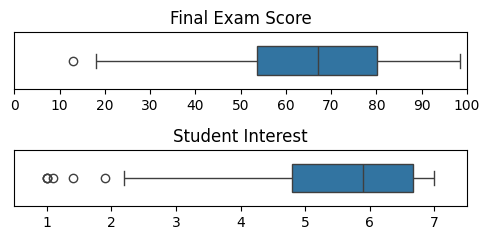

In [670]:

#create new col with average of all interest questions
df['Interest_mean'] = df[interest_questions].mean(axis=1)


import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 2.5))  # Reduced figure height for a compact layout

plt.subplot(2, 1, 1)
sns.boxplot(x='Final_Exam_Score', data=df, width=0.2)  # Thinner boxplot
plt.xlabel('')
plt.title('Final Exam Score')
plt.xlim(df['Final_Exam_Score'].min() - 1, df['Final_Exam_Score'].max() + 1)
plt.xticks(range(0, 101, 10))  # Set x-axis labels from 0 to 100

plt.ylim(-0.2, 0.2)  # Tighten y-axis limits to reduce height
plt.yticks([]) 

plt.subplot(2, 1, 2)
sns.boxplot(x='Interest_mean', data=df, width=0.2)  # Thinner boxplot
plt.xlabel('')
plt.title('Student Interest')
plt.xlim(0.5, 7.5)  # Set x-axis range from 1 to 7
plt.xticks(range(1, 8))  # Set x-axis labels from 1 to 7
plt.ylim(-0.2, 0.2)  # Tighten y-axis limits
plt.yticks([]) 
plt.subplots_adjust(hspace=0.7)  # Adjust space between plots
plt.tight_layout()

#save to file
plt.savefig('exam_and_interest_boxplots.pdf')


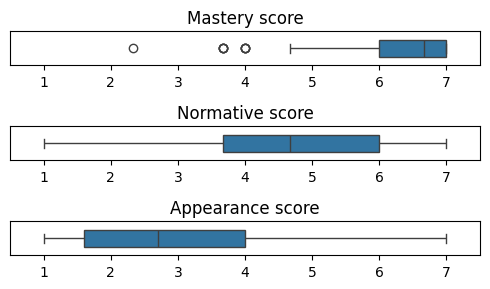

In [671]:


frame_visible = True # Set to False to hide box outlines

df['Mastery_score'] = df[mastery_questions].mean(axis=1)
df['Normative_score'] = df[normative_questions].mean(axis=1)
df['Appearance_score'] = df[appearance_questions].mean(axis=1)
df['CanDoThisTask'] = df[can_do_this_task_questions].mean(axis=1)
plt.figure(figsize=(5, 3))

# First boxplot
plt.subplot(3, 1, 1)
sns.boxplot(x='Mastery_score', data=df, width=0.2)
plt.xlabel('')
plt.title('Mastery score')
plt.xlim(0.5, 7.5)  # Set x-axis range from 1 to 7
plt.xticks(range(1, 8))  # Set x-axis labels from 1 to 7
plt.ylim(-0.2, 0.2)  # Tight y-axis for compact layout
plt.gca().spines['top'].set_visible(frame_visible)
plt.gca().spines['right'].set_visible(frame_visible)
plt.gca().spines['left'].set_visible(frame_visible)
plt.gca().spines['bottom'].set_visible(frame_visible)
plt.yticks([]) 

# Second boxplot
plt.subplot(3, 1, 2)
sns.boxplot(x='Normative_score', data=df, width=0.2)
plt.xlabel('')
plt.title('Normative score')
plt.xlim(0.5, 7.5)
plt.xticks(range(1, 8))
plt.ylim(-0.2, 0.2)
plt.gca().spines['top'].set_visible(frame_visible)
plt.gca().spines['right'].set_visible(frame_visible)
plt.gca().spines['left'].set_visible(frame_visible)
plt.gca().spines['bottom'].set_visible(frame_visible)
plt.yticks([]) 

# Third boxplot
plt.subplot(3, 1, 3)
sns.boxplot(x='Appearance_score', data=df, width=0.2)
plt.xlabel('')
plt.title('Appearance score')
plt.xlim(0.5, 7.5)
plt.xticks(range(1, 8))
plt.ylim(-0.2, 0.2)
plt.yticks([]) 
plt.gca().spines['top'].set_visible(frame_visible)
plt.gca().spines['right'].set_visible(frame_visible)
plt.gca().spines['left'].set_visible(frame_visible)
plt.gca().spines['bottom'].set_visible(frame_visible)

plt.subplots_adjust(hspace=0.7)  # Space between plots for readability
plt.tight_layout()

#save to file
#plt.savefig('mastery_normative_appearance_boxplots.pdf')


In [672]:
df[['Final_Exam_Score', 'Interest_mean']].describe()

,Final_Exam_Score,Interest_mean
count,218.000,218.000
mean,65.306,5.482
std,18.862,1.415
min,12.964,1.000
25%,53.695,4.800
50%,67.011,5.900
75%,80.258,6.675
max,98.572,7.000


In [673]:
#describe goal scores
df[['Mastery_score', 'Normative_score', 'Appearance_score']].describe()

,Mastery_score,Normative_score,Appearance_score
count,218.000,218.000,218.000
mean,6.367,4.631,2.884
std,0.846,1.628,1.459
min,2.333,1.000,1.000
25%,6.000,3.667,1.600
50%,6.667,4.667,2.700
75%,7.000,6.000,4.000
max,7.000,7.000,7.000


In [674]:
df['CanDoThisTask'].describe()

count   218.000
mean      4.945
std       0.927
min       1.125
25%       4.500
50%       5.062
75%       5.750
max       6.000
Name: CanDoThisTask, dtype: float64

### Scatterplots 

#### Interest 

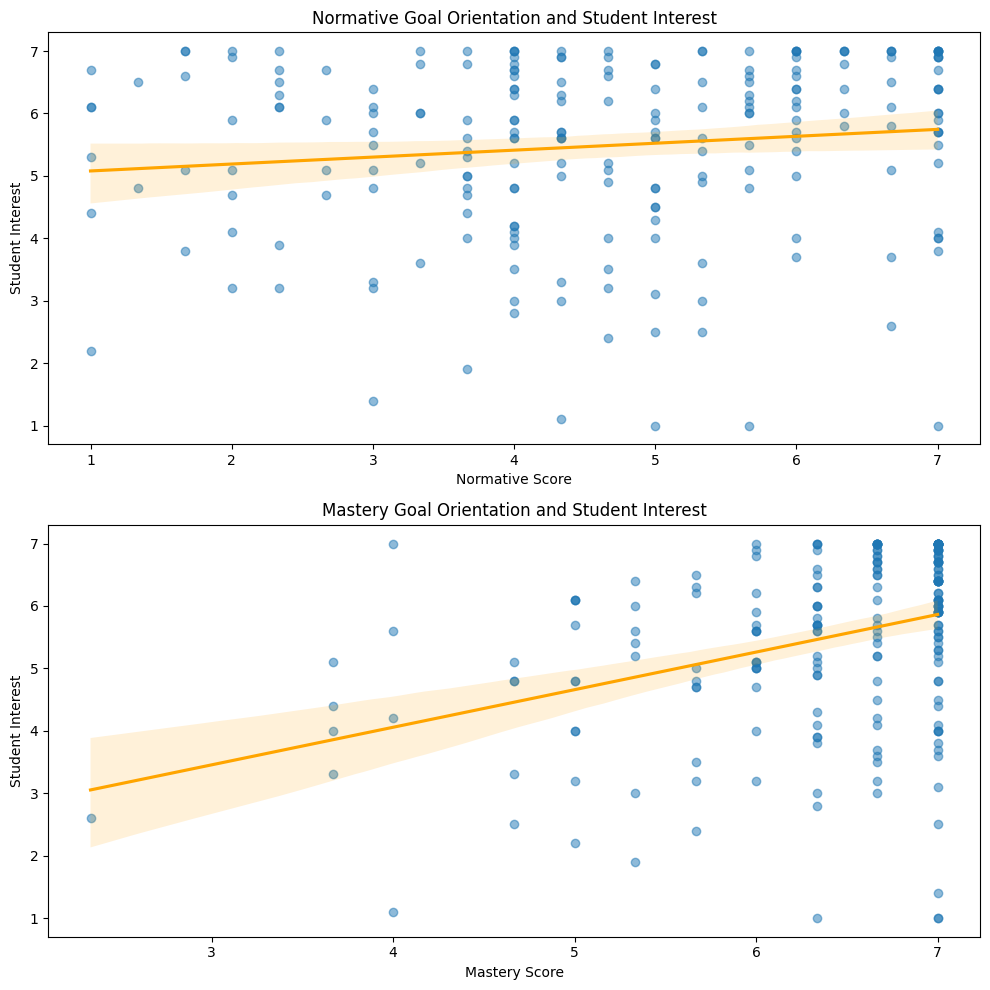

In [675]:


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# First subplot
sns.regplot(x='Normative_score', y='Interest_mean', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[0])  # Add regression line
axes[0].set_title('Normative Goal Orientation and Student Interest')
axes[0].set_xlabel('Normative Score')
axes[0].set_ylabel('Student Interest')

# Second subplot
sns.regplot(x='Mastery_score', y='Interest_mean', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[1])  # Add regression line
axes[1].set_title('Mastery Goal Orientation and Student Interest')
axes[1].set_xlabel('Mastery Score')
axes[1].set_ylabel('Student Interest')

# Adjust layout
plt.tight_layout()

#plt.savefig('achievement_goals_interest_boxplots.pdf')

#### Exam Scores 

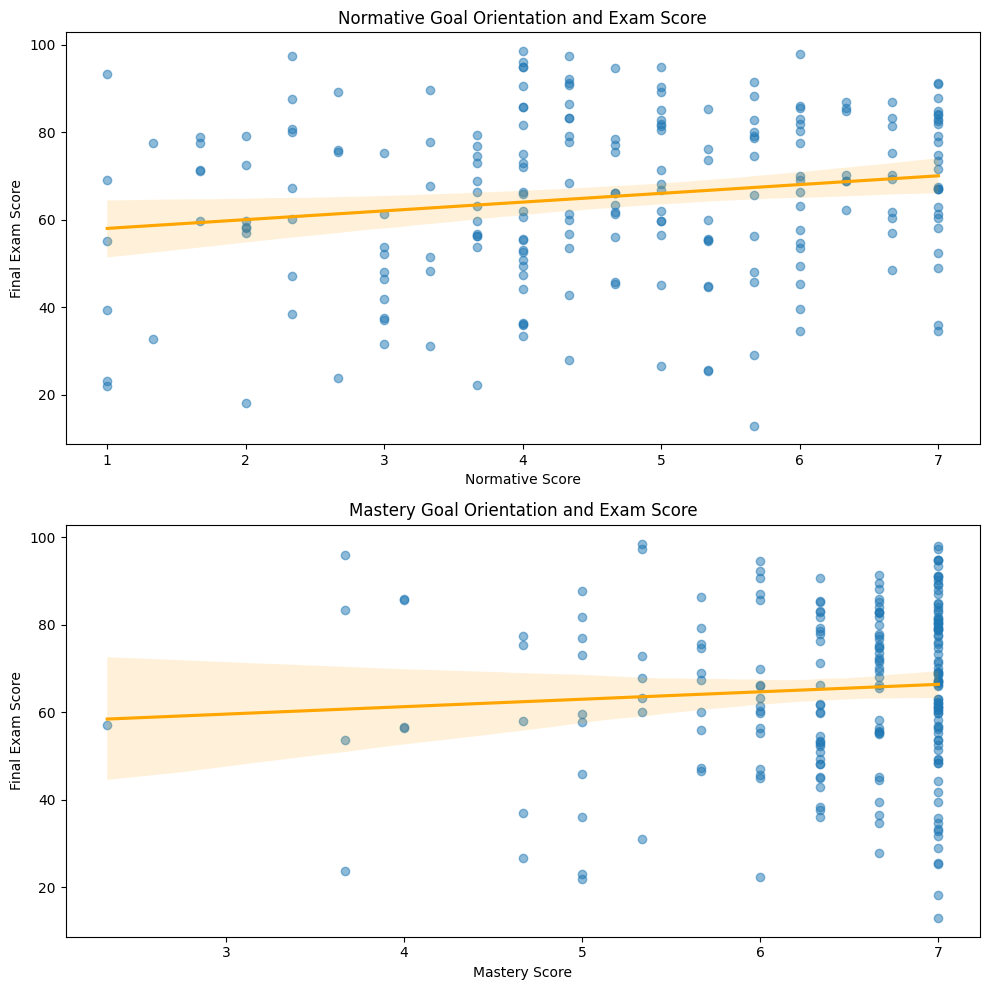

In [676]:
#scatterplot for normative and final exam score 

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# First subplot
sns.regplot(x='Normative_score', y='Final_Exam_Score', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[0])  # Add regression line
axes[0].set_title('Normative Goal Orientation and Exam Score')
axes[0].set_xlabel('Normative Score')
axes[0].set_ylabel('Final Exam Score')

# Second subplot
sns.regplot(x='Mastery_score', y='Final_Exam_Score', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'orange'}, ax=axes[1])  # Add regression line
axes[1].set_title('Mastery Goal Orientation and Exam Score')
axes[1].set_xlabel('Mastery Score')
axes[1].set_ylabel('Final Exam Score')

# Adjust layout
plt.tight_layout()

#plt.savefig('achievement_goals_exam_boxplots.pdf')



In [677]:
print(df.columns)

Index(['One of my goals is to show others that I’m good at my class work.',
       'I am striving to understand the content of this course as thoroughly as possible.',
       'My goal is to learn as much as possible.',
       'One of my goals is to have other students in my class think I am good at my class work.',
       'My aim is to perform well relative to other students.',
       'My aim is to completely master the material presented in this class.',
       'One of my goals is to show others that class work is easy for me.',
       'One of my goals is to look smart in comparison to other students in my class.',
       'My goal is to perform better than the other students.',
       'I aim to look smart compared to others in my class.',
       'I am striving to do well compared to other students.',
       'I think what we are learning in this class is interesting.',
       'I think I will be able to use what I learn in this course in other courses.',
       'I would recommend this c

In [678]:
#rows in df 
df.shape[0]

218

# Initial Statistics

## Cronbach's alpha 

In [679]:
# def compute cronbach alpha for a given set of questions
import pingouin as pg

def cronbach_alpha(df, questions):
    q = df[questions]
    return pg.cronbach_alpha(q)[0]

for t, questions in [('Mastery', mastery_questions), ('Normative', normative_questions), ('Appearance', appearance_questions), ('Interest', interest_questions)]:
    print(f'{t}: {cronbach_alpha(df, questions):.2f}')



Mastery: 0.81
Normative: 0.85
Appearance: 0.91
Interest: 0.96


In [680]:
for t, questions in [('CanDoTask', can_do_this_task_questions)]:
    print(f'{t}: {cronbach_alpha(df, questions):.2f}')

CanDoTask: 0.91


In [681]:

for t, questions in [('Read copilot output', copilot_read_output), ('Test copilot output', copilot_test_output)]:
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

for t, questions in [('Perceptions of copilot', copilot_helped_hindered)]:
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

#run cronbach alpha for the programming intelligence questions
for t, questions in [('End Survey Programming Intelligence Belief/Growth Mindset', end_progintelligencequestions)]:
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

for t, questions in [('Pre survey Programming Intelligence Belief/Growth Mindset', pre_progintelligencequestions)]: 
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

#both together? 
for t, questions in [('Pre & End Programming Intelligence Belief/Growth Mindset', pre_progintelligencequestions + end_progintelligencequestions)]: 
    if len(questions) > 1:
        print(f'{t}: {cronbach_alpha(df, questions):.2f}')

End Survey Programming Intelligence Belief/Growth Mindset: 0.88
Pre survey Programming Intelligence Belief/Growth Mindset: 0.83
Pre & End Programming Intelligence Belief/Growth Mindset: 0.89


## Descriptive Stats

In [682]:
df['Mastery'] = df[mastery_questions].mean(axis=1)
df['Normative'] = df[normative_questions].mean(axis=1)
df['Appearance'] = df[appearance_questions].mean(axis=1)
df['Interest'] = df[interest_questions].mean(axis=1)
df['EndProgIntelligenceBelief'] = df[end_progintelligencequestions].mean(axis=1)
df['PreProgIntelligenceBelief'] = df[pre_progintelligencequestions].mean(axis=1)
df['MidProgIntelligenceBelief'] = df[mid_progintelligencequestions].mean(axis=1)


category_stats = pd.concat([
    df[category].describe()
    for category in ['Mastery', 'Normative', 'Appearance', 'Interest', 'EndProgIntelligenceBelief', 'PreProgIntelligenceBelief']
], axis=1)
category_stats

,Mastery,Normative,Appearance,Interest,EndProgIntelligenceBelief,PreProgIntelligenceBelief
count,218.000,218.000,218.000,218.000,218.000,218.000
mean,6.367,4.631,2.884,5.482,1.993,1.718
std,0.846,1.628,1.459,1.415,0.787,0.619
min,2.333,1.000,1.000,1.000,0.500,0.500
25%,6.000,3.667,1.600,4.800,1.417,1.250
50%,6.667,4.667,2.700,5.900,1.792,1.667
75%,7.000,6.000,4.000,6.675,2.500,2.083
max,7.000,7.000,7.000,7.000,4.917,3.750


In [683]:
df['ReadCopilotOutput'] = df[copilot_read_output].mean(axis=1)
df['TestCopilotOutput'] = df[copilot_test_output].mean(axis=1)
df['CopilotPerceptions'] = df[copilot_helped_hindered].mean(axis=1)



copilot_stats = pd.concat([
    df[category].describe()
    for category in ['ReadCopilotOutput', 'TestCopilotOutput', 'CopilotPerceptions']
], axis=1)
copilot_stats

,ReadCopilotOutput,TestCopilotOutput,CopilotPerceptions
count,218.000,218.000,218.000
mean,74.404,68.257,0.294
std,21.528,23.588,0.883
min,10.000,0.000,-1.000
25%,70.000,50.000,-1.000
50%,80.000,70.000,1.000
75%,90.000,80.000,1.000
max,100.000,100.000,1.000


## Correlations 

In [684]:
# compute correlations between all categories including final exam score
correlations = df[['Mastery', 'Normative', 'Appearance', 'Interest', 'Prior_Knowledge', 'Final_Exam_Score']].corr()
correlations

,Mastery,Normative,Appearance,Interest,Prior_Knowledge,Final_Exam_Score
Mastery,1.000,0.240,0.073,0.360,0.101,0.076
Normative,0.240,1.000,0.578,0.128,0.034,0.173
Appearance,0.073,0.578,1.000,0.054,-0.003,0.059
Interest,0.360,0.128,0.054,1.000,0.343,0.327
Prior_Knowledge,0.101,0.034,-0.003,0.343,1.000,0.193
Final_Exam_Score,0.076,0.173,0.059,0.327,0.193,1.000


In [685]:
correlations_copilot_hygiene = df[['ReadCopilotOutput', 'TestCopilotOutput', 'CopilotPerceptions', 'Mastery', 'Normative', 'Appearance', 'EndProgIntelligenceBelief','PreProgIntelligenceBelief', 'Final_Exam_Score']].corr()
correlations_copilot_hygiene

,ReadCopilotOutput,TestCopilotOutput,CopilotPerceptions,Mastery,Normative,Appearance,EndProgIntelligenceBelief,PreProgIntelligenceBelief,Final_Exam_Score
ReadCopilotOutput,1.000,0.591,0.193,0.213,0.074,-0.075,-0.259,-0.217,0.022
TestCopilotOutput,0.591,1.000,0.195,0.168,0.087,-0.034,-0.305,-0.229,0.040
CopilotPerceptions,0.193,0.195,1.000,0.166,0.085,0.043,-0.166,-0.056,0.134
Mastery,0.213,0.168,0.166,1.000,0.240,0.073,-0.244,-0.468,0.076
Normative,0.074,0.087,0.085,0.240,1.000,0.578,-0.029,-0.054,0.173
Appearance,-0.075,-0.034,0.043,0.073,0.578,1.000,-0.026,0.136,0.059
EndProgIntelligenceBelief,-0.259,-0.305,-0.166,-0.244,-0.029,-0.026,1.000,0.430,-0.340
PreProgIntelligenceBelief,-0.217,-0.229,-0.056,-0.468,-0.054,0.136,0.430,1.000,-0.046
Final_Exam_Score,0.022,0.040,0.134,0.076,0.173,0.059,-0.340,-0.046,1.000


In [686]:
# do correlations and include significance

import scipy.stats as stats

def make_correlation_matrix(df, columns):
    corr = df[columns].corr()
    p_values = pd.DataFrame()
    for x in columns:
        p_values[x] = [stats.pearsonr(df[x], df[y])[1] for y in columns]
    p_values = p_values.set_index(columns)
    #p_values.columns = columns
    return corr, p_values

corr, p_values = make_correlation_matrix(df, ['Mastery', 'Normative', 'Appearance', 'Interest', 'EndProgIntelligenceBelief', 'Final_Exam_Score'])

pd.options.display.float_format = '{:.10f}'.format
display(p_values)

,,,,,
Mastery,Normative,Appearance,Interest,EndProgIntelligenceBelief,Final_Exam_Score
0.0000000000,0.0003504877,0.2824799289,0.0000000446,0.0002770833,0.2622732654
0.0003504877,0.0000000000,0.0000000000,0.0596732451,0.6726040375,0.0104952670
0.2824799289,0.0000000000,0.0000000000,0.4318772185,0.7019893937,0.3822147817
0.0000000446,0.0596732451,0.4318772185,0.0000000000,0.0000000000,0.0000007757
0.0002770833,0.6726040375,0.7019893937,0.0000000000,0.0000000000,0.0000002762
0.2622732654,0.0104952670,0.3822147817,0.0000007757,0.0000002762,0.0000000000


In [687]:
#correlations with copilot info
corr_copilot, p_values_copilot = make_correlation_matrix(df, ['ReadCopilotOutput', 'TestCopilotOutput','CopilotPerceptions', 'Mastery', 'Normative', 'Appearance', 'EndProgIntelligenceBelief', 'Final_Exam_Score'])
display(p_values_copilot)

Empty DataFrame
Columns: []
Index: [(0.0, 7.010638292979491e-22, 0.004138101123262679, 0.0015765066135069717, 0.2757840268042575, 0.2684433535360155, 0.00011302505565814066, 0.7489487050504362), (7.010638292979491e-22, 0.0, 0.0038409209408393264, 0.01316990746422989, 0.1995893966791834, 0.6147624558626796, 4.398811310515965e-06, 0.5569860773805274), (0.004138101123262679, 0.0038409209408393264, 0.0, 0.014362642743199953, 0.2100417735342014, 0.5284532775385558, 0.014317435673397211, 0.04845564334400485), (0.0015765066135069717, 0.01316990746422989, 0.014362642743199953, 0.0, 0.00035048774189275705, 0.28247992885897477, 0.00027708327217458204, 0.2622732654174411), (0.2757840268042575, 0.1995893966791834, 0.2100417735342014, 0.00035048774189275705, 0.0, 7.306016197209238e-21, 0.6726040375398079, 0.010495267038249954), (0.2684433535360155, 0.6147624558626796, 0.5284532775385558, 0.28247992885897477, 7.306016197209238e-21, 0.0, 0.7019893937307468, 0.38221478172447093), (0.00011302505565814066, 4.398811310515965e-06, 0.014317435673397211, 0.00027708327217458204, 0.6726040375398079, 0.7019893937307468, 0.0, 2.762251346890602e-07), (0.7489487050504362, 0.5569860773805274, 0.04845564334400485, 0.2622732654174411, 0.010495267038249954, 0.38221478172447093, 2.762251346890602e-07, 0.0)]

# Regression Setup

In [688]:
#print df cols 
df.columns

Index(['One of my goals is to show others that I’m good at my class work.',
       'I am striving to understand the content of this course as thoroughly as possible.',
       'My goal is to learn as much as possible.',
       'One of my goals is to have other students in my class think I am good at my class work.',
       'My aim is to perform well relative to other students.',
       'My aim is to completely master the material presented in this class.',
       'One of my goals is to show others that class work is easy for me.',
       'One of my goals is to look smart in comparison to other students in my class.',
       'My goal is to perform better than the other students.',
       'I aim to look smart compared to others in my class.',
       ...
       'Mastery', 'Normative', 'Appearance', 'Interest',
       'EndProgIntelligenceBelief', 'PreProgIntelligenceBelief',
       'MidProgIntelligenceBelief', 'ReadCopilotOutput', 'TestCopilotOutput',
       'CopilotPerceptions'],
      dty

### Center Columns 

In [689]:
#center all columns that are not binary
centered_cols = []
for col in df.columns:
    if df[col].nunique() > 2:
        df[col] = df[col] - df[col].mean()
        centered_cols.append(col)


### Checking Assumptions 

Check assumptions of 
- constant variance
- normal residuals/errors: done 
- outliers: done 
- leverage, 
- influential cases, 
- VIF: done 
- Homoscedasticity: done 

#focus on:

- leverage: done 
- influential cases: Cook's 

#### KS (Kolmogorov-Smirnov test for normality) Test fails so we perform Power Transformation. 

In [690]:
pt = PowerTransformer()

fit_transformed = pt.fit_transform(df[centered_cols])

df[centered_cols] = fit_transformed

#dfcopy = df.copy()

#### VIF function

In [691]:
#given equation of the form 'Q("Final Exam Score") ~ Mastery*Normative*Appearance*Prior_Knowledge' # CSMajor + SelfEfficacy + EndProgIntelligenceBelief' and data, return the VIF for each variable in the equation
#calculate VIF for each variable in the regression equation without using VIF package; do from scratch using R^2 values from output of ols(eq, data).fit().summary()
def check_vif(regression_eq_string, data):
    # Extracting the independent variables from the regression equation
    #if 1 or fewer independent variables, return an empty dictionary
    print("Checking VIF for: ", regression_eq_string)
    predictors = None
    full_model = None
    if regression_eq_string.count('+') < 1:
        return {}

    full_model = ols(formula=regression_eq_string, data=data).fit()
    predictors = full_model.model.exog_names[1:]  # Skip the intercept

    vif_dict = {}
    
    # For each predictor, regress it on the other predictors and compute R^2
    for predictor in predictors:
        other_predictors = [p for p in predictors if p != predictor]
        # Create a regression equation where the current predictor is the dependent variable
        regression_eq = f'{predictor} ~ {" + ".join(other_predictors)}'
        
        partial_model = ols(formula=regression_eq, data=data).fit()
        
        r_squared = partial_model.rsquared
        
        # Calculate the VIF for the predictor
        vif = 1 / (1 - r_squared)
        vif_dict[predictor] = vif
        print("Regression eq: ", regression_eq, "R^2: ", r_squared)
        print("Predictor: ", predictor, "VIF: ", vif)
    return vif_dict

In [692]:
#get correlation between PreProgIntelligenceBelief and EndProgIntelligenceBelief
df[['PreProgIntelligenceBelief', 'EndProgIntelligenceBelief']].corr()


,PreProgIntelligenceBelief,EndProgIntelligenceBelief
PreProgIntelligenceBelief,1.0000000000,0.4251970804
EndProgIntelligenceBelief,0.4251970804,1.0000000000


#### Outliers function

-differ substantially from the main trend of the data; have large residuals
-Standardized residuals are the residuals divided by the standard
deviation; cause for concern are any whose absolute value is greater
than 3, more than 1% greater than 2.5, or more than 5% greater than 2
(rstandard, outlierTest)

In [693]:
# Create a sample dataset


def check_outliers(model, data):
    # Get residuals from the model
    residuals = model.resid
    
    # Calculate the standard deviation of residuals
    std_dev = np.std(residuals)
    
    # Standardize residuals
    standardized_residuals = residuals / std_dev
    
    # Find positional indices for outliers based on the conditions
    outliers_abs_gt_3 = np.where(np.abs(standardized_residuals) > 3)[0]
    outliers_abs_gt_2_5 = np.where(np.abs(standardized_residuals) > 2.5)[0]
    outliers_abs_gt_2 = np.where(np.abs(standardized_residuals) > 2)[0]
    
    # Find indices that meet the percentage-based criteria
    percent_abs_gt_2_5 = len(outliers_abs_gt_2_5) / len(standardized_residuals) * 100
    percent_abs_gt_2 = len(outliers_abs_gt_2) / len(standardized_residuals) * 100

    # Check if more than 1% of residuals are > 2.5 or more than 5% > 2
    if percent_abs_gt_2_5 > 1:
        flagged_outliers_2_5 = outliers_abs_gt_2_5
    else:
        flagged_outliers_2_5 = []

    if percent_abs_gt_2 > 5:
        flagged_outliers_2 = outliers_abs_gt_2
    else:
        flagged_outliers_2 = []

    #make a dictionary of the outliers
    outlier_dict = {
        'outliers_abs_gt_3': outliers_abs_gt_3,
        'outliers_abs_gt_2_5': flagged_outliers_2_5,
        'outliers_abs_gt_2': flagged_outliers_2
    }
    print(outlier_dict)
    
    # Combine all unique positional indices of outliers and ensure they're integers
    all_outlier_indices = np.unique(np.concatenate([outliers_abs_gt_3, flagged_outliers_2_5, flagged_outliers_2])).astype(int)

    # Map positional indices to the actual index labels in the DataFrame
    outlier_labels = data.index[all_outlier_indices]
    
    return outlier_labels.tolist()


#### Leverage function

In [694]:
def check_high_leverage_points(model, data):
    """
    Identifies high-leverage points in a regression model based on leverage scores.
    
    Parameters:
    - model: A fitted statsmodels regression model.
    - data: A pandas DataFrame containing the data (including the predictors).
    
    Returns:
    - List of index labels for high-leverage points, corresponding to DataFrame indices.
    """
    # Calculate leverage (hat values)
    leverage = model.get_influence().hat_matrix_diag
    
    # Define threshold values
    k = model.model.exog.shape[1] - 1  # Number of predictors (excluding intercept)
    n = data.shape[0]                  # Number of observations
    average_leverage = (k + 1) / n
    high_leverage_threshold_2x = 2 * average_leverage
    high_leverage_threshold_3x = 3 * average_leverage
    
    # Identify high-leverage points
    high_leverage_indices = np.where(
        (leverage > high_leverage_threshold_2x) | 
        (leverage > high_leverage_threshold_3x)
    )[0]  # Get positional indices of high leverage points
    
    # Map positional indices to the actual index labels in the DataFrame
    high_leverage_labels = data.index[high_leverage_indices]
    
    return high_leverage_labels.tolist()

# Example usage:
# Assuming `model` is a fitted statsmodels OLS model and `data` is your DataFrame
# high_leverage_points = check_high_leverage_points(model, data)
# print("High leverage points:", high_leverage_points)

# Dropping high leverage points
# data_cleaned = data.drop(index=high_leverage_points)


## Table Displays & Assumption checking

In [695]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Function to add significance markers based on p-value thresholds
def add_significance_markers(row):
    p_value = row['p-value']
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Function to apply bold formatting to significant predictors 
def highlight_significant(s):
    """
    Make all significant predictors bold and ensure that they maintain their three decimal places
    """
    p_values = s['p-value'].astype(float)
    if p_values < 0.05:
        return ['font-weight: bold'] * len(s)
    else:
        return [''] * len(s)

def style_df(model):
    # Add significance markers to the index column of the summary table
    summary_df = pd.DataFrame({
        'Coefficient': model.params,
        'Standard Error': model.bse,
        't-value': model.tvalues,
        'p-value': model.pvalues
    })
    summary_df.index = summary_df.index.to_series().apply(lambda x: x + add_significance_markers(summary_df.loc[x]))
    styled_summary_df = summary_df.style.format("{:.3f}").apply(highlight_significant, axis=1)
    return styled_summary_df


def display_model_info(equation, df, print_vif=False, rsq_only=False, rsqdict=None):
    print("Equation: ", equation)
    model = ols(equation, data=df).fit()
    styled_summary_df = style_df(model)
    #if rsqdict is not None, add the model's R^2 to the dictionary. Equation is the key, R^2 is the value
    if rsqdict is not None:
        rsqdict[equation] = model.rsquared_adj
    if rsq_only:
        print(f"Model adj. R^2: {model.rsquared_adj:.3f}")
        return
    display(styled_summary_df)

    print(f"Model adj. R^2: {model.rsquared_adj:.3f}, R^2: {model.rsquared:.3f}, N. obs: {model.nobs:.0f}, F-statistic: {model.fvalue:.3f}")


    ### Checking VIF ###
    if print_vif:
        print("\nVIF of each factor:")

    vif_values = check_vif(equation, df)
    high_VIF_factors = []
    for variable, vif in vif_values.items():
        if print_vif:
            print(f"{variable}: {vif:.2f}")
        # if vif > 10, add to a list of variables with high VIF
        if vif > 10:
            high_VIF_factors.append(variable)

    #print variables with high VIF
    if len(high_VIF_factors) > 0:
        print("\n^^^^^^^^^^^^^^^^Variables with high VIF:")
        print(high_VIF_factors)
    else:
        print("\nNo variables with high VIF")
    
    ### Durbin-Watson test for independent errors/autocorrelation ###
    durbinwatsonval = sm.stats.stattools.durbin_watson(model.resid)
    if (durbinwatsonval > 1) and (durbinwatsonval < 3):
        print("Durbin-Watson test for autocorrelation: Nothing significant")
    else:
        print("^^^^^^^^^^^^^^^^Durbin-Watson test for autocorrelation: Significant")

    ### kstest for normality of residuals/normally distributed errors###
    kstestval = stats.kstest(model.resid, 'norm', alternative='less')
    if kstestval[1] > 0.05:
        print("Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant")
    else: 
        print("^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation")
        print(kstestval)

    ### Checking for Homoscedasticity ###
    breuschpaganval = sms.diagnostic.het_breuschpagan(model.resid, model.model.exog)
    if breuschpaganval[1] > 0.05:
        print("Breusch-Pagan test for homoscedasticity: Nothing significant")
    else:
        print("^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant")
        print(breuschpaganval)
    
    ### Checking for outliers ###
    #test = model.outlier_test()
    #outliers = test[test['unadj_p'] < 0.05].index
    
    outliers = check_outliers(model, df)
    print('^^^^^^^^^^^^^^^^Outliers: ', list(outliers))

    #create instance of influence
    influence = model.get_influence()

    #leverage (hat values)
    #leverage = model.hat_matrix_diag

    #Cook's D values (and p-values) as tuple of arrays
    cooks_d = influence.cooks_distance

    #print("Cooks D values: ", cooks_d[0])
    #number of points with high cooks d values
    high_cooks_d = np.where(cooks_d[0] > 1)[0]

    print("High Cook's D values: ", high_cooks_d)
    print("Cooks D values: ", cooks_d[0][high_cooks_d])
    print("Cooks D p-values: ", cooks_d[1][high_cooks_d])
    
    ### Calculate leverage values ###
    highleverage = check_high_leverage_points(model,df)
    print('^^^^^^^^^^^^^^^^High leverage points: ', highleverage)
    
    #influential points 
    #influential_points = influence.get_influence()

    
    #if there are outliers, re-run the model without them


    if len(outliers) > 0:
        print("Re-running model without outliers")
        dfcopy = df.copy()
        df_no_outliers = dfcopy.drop(outliers)
        model_no_outliers = ols(equation, data=df_no_outliers).fit()
        styled_summary_df_no_outliers = style_df(model_no_outliers)
        display(styled_summary_df_no_outliers)
        print(f"Model adj. R^2: {model_no_outliers.rsquared_adj:.3f}, R^2: {model_no_outliers.rsquared:.3f}, N. obs: {model_no_outliers.nobs:.0f}, F-statistic: {model_no_outliers.fvalue:.3f}")
    
    
    #if there are high leverage points, re-run the model without them
    if len(highleverage) > 0:
        print("Re-running model without high leverage points")
        dfcopy = df.copy()
        df_no_highleverage = dfcopy.drop(highleverage)
        model_no_highleverage = ols(equation, data=df_no_highleverage).fit()
        styled_summary_df_no_highleverage = style_df(model_no_highleverage)
        display(styled_summary_df_no_highleverage)
        print(f"Model adj. R^2: {model_no_highleverage.rsquared_adj:.3f}, R^2: {model_no_highleverage.rsquared:.3f}, N. obs: {model_no_highleverage.nobs:.0f}, F-statistic: {model_no_highleverage.fvalue:.3f}")
    

    return model


def display_anova(model1,model2): 
    print("Displaying ANOVA results:")
    print("model1: ", model1.model.formula)
    print("model2: ", model2.model.formula)
    anova_results = anova_lm(model1, model2)
    display(anova_results)

    # print apa inline format e.g., f(1, 100) = 1.23, p = 0.05
    print(f"F({anova_results.df_diff[1]}, {anova_results.df_resid[1]}) = {anova_results.F[1]:.2f}, p = {anova_results['Pr(>F)'][1]:.2f}")
    if anova_results['Pr(>F)'][1] < 0.05:
        print("NOTE: ANOVA The difference between models is significant.")

## Function for Stepwise Regression

In [696]:
def stepwise_selection(data, possible_predictors_input, dep_var, check_anova_before_adding=False, display_best_model=True):
    #dict to store the best regression model for each number of predictors. key is number of predictors, value is a tuple of the best model string equation and the model's adjusted R^2 value
    best_models = {}
    predictors = []
    best_model = None
    best_adjr2 = -1.0
    best_model_equation_string = None

    #make a copy of the possible predictors
    possible_predictors = possible_predictors_input.copy()

    #while there are still possible predictors to consider
    while len(possible_predictors) > 0:
        best_predictor = None
        for predictor in possible_predictors:
            #create a new model with the current predictors and the possible predictor
            model_eq_str = f"{dep_var} ~ {' + '.join(predictors + [predictor])}"
            model = ols(model_eq_str, data).fit()
            if model.rsquared_adj > best_adjr2:
                
                if check_anova_before_adding and best_model is not None:
                    #check if adding the predictor significantly improves the model
                    anova_results = anova_lm(best_model, model)
                    if anova_results['Pr(>F)'][1] < 0.05:
                        print(f"Adding {predictor} significantly improves the model significantly. P val: {anova_results['Pr(>F)'][1]}")
                        print("Best adj R^2 before: ", best_adjr2, " Best adj R^2 after: ", model.rsquared_adj)
                        print("models being compared: " + best_model.model.formula + " and " + model.model.formula)
                        best_predictor = predictor
                        best_model = model
                        best_adjr2 = model.rsquared_adj
                        best_models[len(predictors) + 1] = (model_eq_str, best_adjr2)
                if best_model is None: #if best model is None, then we are on the first iteration and we should add the predictor
                    best_predictor = predictor
                    best_model = model
                    best_adjr2 = model.rsquared_adj
                    best_models[len(predictors) + 1] = (model_eq_str, best_adjr2)
                elif not check_anova_before_adding:
                    best_predictor = predictor
                    best_model = model
                    best_adjr2 = model.rsquared_adj
                    best_models[len(predictors) + 1] = (model_eq_str, best_adjr2)

        if best_predictor is None:
            break
        
        #print("best equation: ", best_model_equation_string)
        #add the best predictor to the list of predictors
        predictors.append(best_predictor)
        best_model_equation_string = f"{dep_var} ~ {' + '.join(predictors)}"

        #remove the best predictor from the list of possible predictors
        possible_predictors.remove(best_predictor)
    
    #Add main effects from any interaction terms to the best model
    main_effects = set()
    for predictor in predictors:
        if ':' in predictor:  # If it's an interaction term
            # Split the interaction term and add each part as a main effect
            main_effects.update(predictor.split(':'))

    # Ensure all main effects are included in the final model
    for effect in main_effects:
        if effect not in predictors:
            predictors.append(effect)  # Add missing main effect

    # Update the final model equation string with all predictors
    best_model_equation_string = f"{dep_var} ~ {' + '.join(predictors)}"
    #print("Best model equation string: ", best_model_equation_string)
    best_model = ols(best_model_equation_string, data).fit()

    if display_best_model: 
        display_model_info(best_model_equation_string, data)

    return best_model, best_model_equation_string, best_models

In [697]:
def blockwise_selection(data, possible_blocks, base_model, check_anova_before_adding=False, display_best_model=True, display_all_models=False):
    # Dictionary to store the best model at each step. Key is number of blocks added, value is (equation, adj R^2)
    best_models = {}
    current_model_eq = base_model
    best_model = ols(current_model_eq, data).fit()
    best_adjr2 = best_model.rsquared_adj

    # Iterate over blocks to find the best sequence of additions
    for block in possible_blocks:
        new_model_eq = f"{current_model_eq} {block}"
        new_model = ols(new_model_eq, data).fit()
        if display_all_models:
            display_model_info(new_model_eq, data, rsq_only=False)
        if new_model.rsquared_adj > best_adjr2:
            if check_anova_before_adding:
                # Compare models using ANOVA to ensure significance
                anova_results = anova_lm(best_model, new_model)
                if anova_results['Pr(>F)'][1] < 0.05:
                    print(f"----------------------Adding block '{block}' improves the model significantly.")
                    current_model_eq = new_model_eq
                    best_model = new_model
                    best_adjr2 = new_model.rsquared_adj
                    best_models[len(best_models) + 1] = (current_model_eq, best_adjr2)
                    
            else:
                # If no ANOVA check, accept the block directly
                print(f"Adding block '{block}' without ANOVA check.")
                current_model_eq = new_model_eq
                best_model = new_model
                best_adjr2 = new_model.rsquared_adj
                best_models[len(best_models) + 1] = (current_model_eq, best_adjr2)

    if display_best_model:
        print("The best blockwise model is below: ")
        display_model_info(current_model_eq, data)

    return best_model, current_model_eq, best_models



# Achievement Goals Replications

In [698]:
achievement_goals_replication_base_vars = ['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge'] 

# Generate all interaction terms (pairwise and higher-order)
interaction_terms = []

# Loop over interaction orders (from 2 to the total number of variables)
for r in range(2, len(achievement_goals_replication_base_vars) + 1):
    for combo in combinations(achievement_goals_replication_base_vars, r):
        interaction_terms.append(':'.join(combo))

achievement_goals_replication_vars = achievement_goals_replication_base_vars + interaction_terms

#blockwise var interactions 

priorexpblock = '+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge'
betweenachievementsblock = '+ Mastery:Appearance + Normative:Appearance + Mastery:Normative' 
threewayinteractionsblock = '+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge'

possible_blocks = [priorexpblock, betweenachievementsblock, threewayinteractionsblock]

display_nonsignificant_tables = True #for printing tables to add nonsignificant ones to the paper. Set to false when not needed so that notebook doesn't become too cumbersome. 

## Copilot Behaviors and Sentiments 

### GenAI Helps

Both had low adj R^2 overall. 

#### GenAI Helps Problem Solving

Base: Model adj. R^2: 0.060, R^2: 0.075, N. obs: 251, F-statistic: 5.002

Significant: Mastery**	0.306	0.103	2.970	0.003

No significant improvement from blockwise/stepwise

In [699]:
base_model_eq = 'GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.050,0.095,-0.524,0.601
Mastery*,0.172,0.070,2.450,0.015
Normative,0.087,0.087,0.997,0.320
Appearance,0.033,0.084,0.388,0.698
Prior_Knowledge,0.095,0.135,0.704,0.482


Model adj. R^2: 0.036, R^2: 0.054, N. obs: 215, F-statistic: 3.009
Checking VIF for:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=i

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.038,0.095,-0.396,0.692
Mastery*,0.154,0.071,2.152,0.033
Normative,0.114,0.090,1.274,0.204
Appearance,0.008,0.086,0.096,0.923
Prior_Knowledge,0.083,0.135,0.617,0.538


Model adj. R^2: 0.033, R^2: 0.051, N. obs: 214, F-statistic: 2.812


In [700]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'GenAIHelpsProblemSolving', check_anova_before_adding=True, display_best_model=True)

Adding Normative:Prior_Knowledge significantly improves the model significantly. P val: 0.018273153750851718
Best adj R^2 before:  0.03792142444496904  Best adj R^2 after:  0.07271849593009982
models being compared: GenAIHelpsProblemSolving ~ Mastery and GenAIHelpsProblemSolving ~ Mastery + Normative:Prior_Knowledge
Equation:  GenAIHelpsProblemSolving ~ Mastery + Normative:Prior_Knowledge + Normative + Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.055,0.093,-0.589,0.556
Mastery**,0.186,0.069,2.703,0.007
Normative:Prior_Knowledge**,0.371,0.133,2.790,0.006
Normative,-0.096,0.100,-0.959,0.339
Prior_Knowledge,0.090,0.132,0.685,0.494


Model adj. R^2: 0.070, R^2: 0.087, N. obs: 215, F-statistic: 5.026
Checking VIF for:  GenAIHelpsProblemSolving ~ Mastery + Normative:Prior_Knowledge + Normative + Prior_Knowledge
Regression eq:  Mastery ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge R^2:  0.0837664462334583
Predictor:  Mastery VIF:  1.0914247747084824
Regression eq:  Normative:Prior_Knowledge ~ Mastery + Normative + Prior_Knowledge R^2:  0.5393093355806112
Predictor:  Normative:Prior_Knowledge VIF:  2.170653927316513
Regression eq:  Normative ~ Mastery + Normative:Prior_Knowledge + Prior_Knowledge R^2:  0.5645262933371875
Predictor:  Normative VIF:  2.2963498936901385
Regression eq:  Prior_Knowledge ~ Mastery + Normative:Prior_Knowledge + Normative R^2:  0.005187897576168665
Predictor:  Prior_Knowledge VIF:  1.00521495221412

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.060,0.094,-0.637,0.525
Mastery*,0.161,0.072,2.237,0.026
Normative:Prior_Knowledge**,0.393,0.140,2.800,0.006
Normative,-0.058,0.105,-0.554,0.580
Prior_Knowledge,0.060,0.135,0.445,0.657


Model adj. R^2: 0.074, R^2: 0.093, N. obs: 205, F-statistic: 5.098


In [701]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.052,0.094,-0.559,0.577
Mastery**,0.255,0.096,2.644,0.009
Normative,-0.139,0.121,-1.143,0.255
Appearance,0.031,0.109,0.287,0.774
Prior_Knowledge,0.093,0.133,0.699,0.486
Mastery:Prior_Knowledge,-0.139,0.139,-1.000,0.318
Normative:Prior_Knowledge*,0.419,0.174,2.413,0.017
Appearance:Prior_Knowledge,-0.020,0.168,-0.116,0.908


Model adj. R^2: 0.062, R^2: 0.092, N. obs: 215, F-statistic: 3.004
Checking VIF for:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + N

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.061,0.093,-0.655,0.513
Mastery*,0.259,0.100,2.585,0.010
Normative,-0.108,0.127,-0.849,0.397
Appearance,0.023,0.112,0.207,0.836
Prior_Knowledge,0.112,0.132,0.851,0.396
Mastery:Prior_Knowledge,-0.151,0.142,-1.066,0.288
Normative:Prior_Knowledge**,0.491,0.182,2.694,0.008
Appearance:Prior_Knowledge,-0.105,0.174,-0.603,0.547


Model adj. R^2: 0.077, R^2: 0.107, N. obs: 211, F-statistic: 3.489
----------------------Adding block '+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge' improves the model significantly.
Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.072,0.103,-0.702,0.484
Mastery,0.199,0.102,1.953,0.052
Normative,-0.133,0.128,-1.042,0.299
Appearance,0.054,0.113,0.474,0.636
Prior_Knowledge,0.079,0.133,0.596,0.552
Mastery:Prior_Knowledge,-0.132,0.140,-0.949,0.344
Normative:Prior_Knowledge**,0.492,0.179,2.756,0.006
Appearance:Prior_Knowledge,-0.087,0.172,-0.503,0.615
Mastery:Appearance,0.106,0.085,1.248,0.214
Normative:Appearance,0.095,0.075,1.262,0.208


Model adj. R^2: 0.069, R^2: 0.113, N. obs: 215, F-statistic: 2.598
Checking VIF for:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.58261242930554
Predictor:  Mastery VIF:  2.395854764760184
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.7335721035427103
Predictor:  Normative VIF:  3.7533607152143964
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appea

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.027,0.108,-0.247,0.805
Mastery,0.179,0.109,1.640,0.103
Normative,-0.122,0.137,-0.893,0.373
Appearance,0.045,0.117,0.388,0.698
Prior_Knowledge,0.068,0.136,0.500,0.618
Mastery:Prior_Knowledge,-0.083,0.145,-0.572,0.568
Normative:Prior_Knowledge**,0.551,0.186,2.966,0.003
Appearance:Prior_Knowledge,-0.159,0.179,-0.889,0.375
Mastery:Appearance,0.150,0.096,1.562,0.120
Normative:Appearance,0.035,0.083,0.425,0.671


Model adj. R^2: 0.072, R^2: 0.117, N. obs: 204, F-statistic: 2.567
Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.048,0.096,-0.499,0.618
Mastery**,0.260,0.100,2.609,0.010
Normative,-0.136,0.122,-1.121,0.264
Appearance,0.035,0.110,0.316,0.752
Prior_Knowledge,0.032,0.155,0.208,0.836
Mastery:Prior_Knowledge,-0.188,0.146,-1.293,0.197
Normative:Prior_Knowledge**,0.492,0.186,2.652,0.009
Appearance:Prior_Knowledge,-0.071,0.172,-0.413,0.680
Mastery:Normative:Appearance,-0.014,0.068,-0.200,0.842
Mastery:Normative:Prior_Knowledge,-0.158,0.141,-1.126,0.262


Model adj. R^2: 0.064, R^2: 0.112, N. obs: 215, F-statistic: 2.337
Checking VIF for:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.5638238232518913
Predictor:  Mastery VIF:  2.2926515782119363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.058,0.100,-0.579,0.563
Mastery*,0.252,0.114,2.219,0.028
Normative,-0.117,0.130,-0.904,0.367
Appearance,0.004,0.121,0.033,0.973
Prior_Knowledge,0.099,0.169,0.586,0.559
Mastery:Prior_Knowledge,-0.143,0.162,-0.881,0.379
Normative:Prior_Knowledge*,0.468,0.219,2.134,0.034
Appearance:Prior_Knowledge,-0.099,0.194,-0.511,0.610
Mastery:Normative:Appearance,0.019,0.093,0.207,0.837
Mastery:Normative:Prior_Knowledge,0.023,0.191,0.120,0.905


Model adj. R^2: 0.047, R^2: 0.101, N. obs: 195, F-statistic: 1.875
The best blockwise model is below: 
Equation:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.052,0.094,-0.559,0.577
Mastery**,0.255,0.096,2.644,0.009
Normative,-0.139,0.121,-1.143,0.255
Appearance,0.031,0.109,0.287,0.774
Prior_Knowledge,0.093,0.133,0.699,0.486
Mastery:Prior_Knowledge,-0.139,0.139,-1.000,0.318
Normative:Prior_Knowledge*,0.419,0.174,2.413,0.017
Appearance:Prior_Knowledge,-0.020,0.168,-0.116,0.908


Model adj. R^2: 0.062, R^2: 0.092, N. obs: 215, F-statistic: 3.004
Checking VIF for:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + N

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.061,0.093,-0.655,0.513
Mastery*,0.259,0.100,2.585,0.010
Normative,-0.108,0.127,-0.849,0.397
Appearance,0.023,0.112,0.207,0.836
Prior_Knowledge,0.112,0.132,0.851,0.396
Mastery:Prior_Knowledge,-0.151,0.142,-1.066,0.288
Normative:Prior_Knowledge**,0.491,0.182,2.694,0.008
Appearance:Prior_Knowledge,-0.105,0.174,-0.603,0.547


Model adj. R^2: 0.077, R^2: 0.107, N. obs: 211, F-statistic: 3.489
Displaying ANOVA results:
model1:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  GenAIHelpsProblemSolving ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,203.282,0.000,NaN,NaN,NaN
1,207.000,195.112,3.000,8.171,2.889,0.037


F(3.0, 207.0) = 2.89, p = 0.04
NOTE: ANOVA The difference between models is significant.


#### GenAI Helps Programming 
Base Model adj. R^2: 0.034, R^2: 0.050, N. obs: 251, F-statistic: 3.229

No significant factors 

Adding blockwise prior knowledge interactions improved model significantly. 
GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Model adj. R^2: 0.055, R^2: 0.082, N. obs: 251, F-statistic: 3.098

Normative:Prior_Knowledge**	0.338	0.123	2.759	0.006

In [702]:
base_model_eq = 'GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.083,0.095,-0.875,0.383
Mastery,0.058,0.070,0.831,0.407
Normative,0.100,0.087,1.143,0.254
Appearance,0.113,0.084,1.346,0.180
Prior_Knowledge,0.143,0.135,1.064,0.289


Model adj. R^2: 0.032, R^2: 0.050, N. obs: 215, F-statistic: 2.769
Checking VIF for:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int6

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.073,0.095,-0.767,0.444
Mastery,0.043,0.072,0.607,0.544
Normative,0.122,0.090,1.361,0.175
Appearance,0.093,0.086,1.079,0.282
Prior_Knowledge,0.134,0.135,0.991,0.323


Model adj. R^2: 0.030, R^2: 0.048, N. obs: 214, F-statistic: 2.660


In [703]:
_, best_stepwise_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'GenAIHelpsProgramming', check_anova_before_adding=True, display_best_model=True)

Adding Normative:Prior_Knowledge significantly improves the model significantly. P val: 0.0011182215230389995
Best adj R^2 before:  0.004884998309281241  Best adj R^2 after:  0.05995447088024186
models being compared: GenAIHelpsProgramming ~ Mastery and GenAIHelpsProgramming ~ Normative:Prior_Knowledge
Equation:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.089,0.094,-0.955,0.341
Normative:Prior_Knowledge*,0.345,0.133,2.596,0.010
Normative,-0.002,0.097,-0.023,0.982
Prior_Knowledge,0.144,0.133,1.086,0.279


Model adj. R^2: 0.056, R^2: 0.070, N. obs: 215, F-statistic: 5.258
Checking VIF for:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge
Regression eq:  Normative:Prior_Knowledge ~ Normative + Prior_Knowledge R^2:  0.5356272244908982
Predictor:  Normative:Prior_Knowledge VIF:  2.15344234791473
Regression eq:  Normative ~ Normative:Prior_Knowledge + Prior_Knowledge R^2:  0.5359094802271287
Predictor:  Normative VIF:  2.1547520524431443
Regression eq:  Prior_Knowledge ~ Normative:Prior_Knowledge + Normative R^2:  0.0016518953868718267
Predictor:  Prior_Knowledge VIF:  1.0016546286603227

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.11273990819972723, pvalue=0.003884746535991708, statistic_location=0.3047367005589841, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'out

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.096,0.096,-1.002,0.317
Normative:Prior_Knowledge*,0.345,0.142,2.425,0.016
Normative,-0.001,0.103,-0.006,0.995
Prior_Knowledge,0.158,0.137,1.157,0.249


Model adj. R^2: 0.053, R^2: 0.067, N. obs: 205, F-statistic: 4.815


In [704]:
print("stepwise anova: ")

display_anova(ols(base_model_eq, df).fit(), ols(best_stepwise_model_eq , df).fit())

stepwise anova: 
Displaying ANOVA results:
model1:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,203.366,0.000,NaN,NaN,NaN
1,211.000,199.202,-1.000,4.165,-4.411,NaN


F(-1.0, 211.0) = -4.41, p = nan


In [705]:
_, best_blockwise_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_blockwise_model_eq, df).fit())

Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.087,0.094,-0.922,0.357
Mastery,0.131,0.097,1.356,0.177
Normative,-0.130,0.122,-1.073,0.285
Appearance,0.143,0.109,1.311,0.191
Prior_Knowledge,0.142,0.133,1.064,0.289
Mastery:Prior_Knowledge,-0.123,0.140,-0.883,0.378
Normative:Prior_Knowledge*,0.440,0.174,2.529,0.012
Appearance:Prior_Knowledge,-0.092,0.169,-0.544,0.587


Model adj. R^2: 0.054, R^2: 0.085, N. obs: 215, F-statistic: 2.749
Checking VIF for:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + Norm

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.097,0.094,-1.025,0.307
Mastery,0.140,0.101,1.385,0.167
Normative,-0.111,0.129,-0.860,0.391
Appearance,0.142,0.114,1.252,0.212
Prior_Knowledge,0.155,0.134,1.159,0.248
Mastery:Prior_Knowledge,-0.141,0.144,-0.984,0.326
Normative:Prior_Knowledge**,0.483,0.185,2.616,0.010
Appearance:Prior_Knowledge,-0.147,0.176,-0.833,0.406


Model adj. R^2: 0.061, R^2: 0.092, N. obs: 211, F-statistic: 2.951
Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.090,0.105,-0.856,0.393
Mastery,0.069,0.076,0.900,0.369
Normative,0.069,0.096,0.727,0.468
Appearance,0.124,0.088,1.412,0.159
Prior_Knowledge,0.158,0.136,1.157,0.249
Mastery:Appearance,0.080,0.085,0.937,0.350
Normative:Appearance,-0.013,0.076,-0.168,0.867
Mastery:Normative,0.006,0.087,0.071,0.944


Model adj. R^2: 0.024, R^2: 0.056, N. obs: 215, F-statistic: 1.761
Checking VIF for:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  Pr

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.088,0.113,-0.783,0.435
Mastery,0.062,0.083,0.744,0.458
Normative,0.080,0.106,0.758,0.450
Appearance,0.067,0.094,0.708,0.480
Prior_Knowledge,0.158,0.141,1.122,0.263
Mastery:Appearance,0.131,0.100,1.309,0.192
Normative:Appearance,-0.024,0.088,-0.278,0.781
Mastery:Normative,0.004,0.108,0.034,0.973


Model adj. R^2: 0.018, R^2: 0.052, N. obs: 201, F-statistic: 1.512
Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.075,0.097,-0.770,0.442
Mastery,0.103,0.080,1.286,0.200
Normative,0.043,0.092,0.471,0.638
Appearance,0.135,0.086,1.572,0.117
Prior_Knowledge,0.113,0.157,0.718,0.473
Mastery:Normative:Appearance,-0.026,0.068,-0.373,0.709
Mastery:Normative:Prior_Knowledge,0.178,0.136,1.307,0.193
Mastery:Appearance:Prior_Knowledge,0.046,0.142,0.326,0.745
Normative:Appearance:Prior_Knowledge,-0.017,0.106,-0.161,0.872


Model adj. R^2: 0.038, R^2: 0.074, N. obs: 215, F-statistic: 2.054
Checking VIF for:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Ma

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.051,0.102,-0.502,0.616
Mastery,0.147,0.094,1.567,0.119
Normative,-0.002,0.104,-0.020,0.984
Appearance,0.111,0.099,1.128,0.261
Prior_Knowledge,0.111,0.173,0.640,0.523
Mastery:Normative:Appearance,-0.080,0.094,-0.850,0.396
Mastery:Normative:Prior_Knowledge,0.319,0.166,1.924,0.056
Mastery:Appearance:Prior_Knowledge,0.032,0.175,0.180,0.857
Normative:Appearance:Prior_Knowledge,-0.064,0.144,-0.442,0.659


Model adj. R^2: 0.042, R^2: 0.082, N. obs: 195, F-statistic: 2.068
The best blockwise model is below: 
Equation:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.083,0.095,-0.875,0.383
Mastery,0.058,0.070,0.831,0.407
Normative,0.100,0.087,1.143,0.254
Appearance,0.113,0.084,1.346,0.180
Prior_Knowledge,0.143,0.135,1.064,0.289


Model adj. R^2: 0.032, R^2: 0.050, N. obs: 215, F-statistic: 2.769
Checking VIF for:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int6

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.073,0.095,-0.767,0.444
Mastery,0.043,0.072,0.607,0.544
Normative,0.122,0.090,1.361,0.175
Appearance,0.093,0.086,1.079,0.282
Prior_Knowledge,0.134,0.135,0.991,0.323


Model adj. R^2: 0.030, R^2: 0.048, N. obs: 214, F-statistic: 2.660
Displaying ANOVA results:
model1:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,203.366,0.000,NaN,NaN,NaN
1,210.000,203.366,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


In [706]:
#anova between best blockwise and best stepwise 

display_anova(ols(best_stepwise_model_eq, df).fit(), ols(best_blockwise_model_eq, df).fit())

Displaying ANOVA results:
model1:  GenAIHelpsProgramming ~ Normative:Prior_Knowledge + Normative + Prior_Knowledge
model2:  GenAIHelpsProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,211.000,199.202,0.000,NaN,NaN,NaN
1,210.000,203.366,1.000,-4.165,-4.300,1.000


F(1.0, 210.0) = -4.30, p = 1.00


### Independent Coding Ability & Fundamentals 
All had decent adj r^2 of 0.13-0.16.

Mastery, normative, prior knowledge persistently significant 


#### Confidence in Fundamental Understanding of Programming
How confident or unconfident are you that you have a fundamental understanding of programming concepts?

Base Model adj. R^2: 0.160, R^2: 0.173, N. obs: 251, F-statistic: 12.897

Sig: Mastery, normative, prior knowledge

None of stepwise/blockwise improved the model significantly. 

In [707]:
base_model_eq = 'ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.259,0.090,-2.863,0.005
Mastery,0.127,0.067,1.904,0.058
Normative*,0.195,0.083,2.349,0.020
Appearance,0.021,0.080,0.265,0.791
Prior_Knowledge***,0.519,0.128,4.038,0.000


Model adj. R^2: 0.132, R^2: 0.148, N. obs: 215, F-statistic: 9.118
Checking VIF for:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.268,0.089,-3.023,0.003
Mastery,0.119,0.066,1.810,0.072
Normative**,0.241,0.082,2.958,0.003
Appearance,0.008,0.078,0.100,0.920
Prior_Knowledge***,0.552,0.125,4.401,0.000


Model adj. R^2: 0.162, R^2: 0.178, N. obs: 211, F-statistic: 11.115
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.258,0.091,-2.827,0.005
Mastery,0.125,0.068,1.831,0.069
Normative*,0.198,0.086,2.309,0.022
Appearance,0.018,0.082,0.224,0.823
Prior_Knowledge***,0.517,0.129,4.009,0.000


Model adj. R^2: 0.131, R^2: 0.147, N. obs: 214, F-statistic: 9.027


In [708]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentFundamental', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 0.031997920053664086
Best adj R^2 before:  0.03488563109226417  Best adj R^2 after:  0.0709977459833323
models being compared: ConfidentFundamental ~ Mastery and ConfidentFundamental ~ Prior_Knowledge
Adding Mastery significantly improves the model significantly. P val: 0.0059177368066588845
Best adj R^2 before:  0.0709977459833323  Best adj R^2 after:  0.09945427530079909
models being compared: ConfidentFundamental ~ Prior_Knowledge and ConfidentFundamental ~ Prior_Knowledge + Mastery
Adding Normative significantly improves the model significantly. P val: 0.001933002303240284
Best adj R^2 before:  0.09945427530079909  Best adj R^2 after:  0.13557333299674523
models being compared: ConfidentFundamental ~ Prior_Knowledge + Mastery and ConfidentFundamental ~ Prior_Knowledge + Mastery + Normative
Equation:  ConfidentFundamental ~ Prior_Knowledge + Mastery + Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.259,0.090,-2.865,0.005
Prior_Knowledge***,0.518,0.128,4.043,0.000
Mastery,0.125,0.066,1.890,0.060
Normative**,0.209,0.066,3.140,0.002


Model adj. R^2: 0.136, R^2: 0.148, N. obs: 215, F-statistic: 12.188
Checking VIF for:  ConfidentFundamental ~ Prior_Knowledge + Mastery + Normative
Regression eq:  Prior_Knowledge ~ Mastery + Normative R^2:  0.005108472016826515
Predictor:  Prior_Knowledge VIF:  1.005134702500867
Regression eq:  Mastery ~ Prior_Knowledge + Normative R^2:  0.07644336810392238
Predictor:  Mastery VIF:  1.082770634159145
Regression eq:  Normative ~ Prior_Knowledge + Mastery R^2:  0.07371600735149408
Predictor:  Normative VIF:  1.079582512422264

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  8, 112, 177]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 274, 440]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.283,0.089,-3.198,0.002
Prior_Knowledge***,0.567,0.125,4.522,0.000
Mastery,0.119,0.065,1.819,0.070
Normative***,0.239,0.065,3.662,0.000


Model adj. R^2: 0.164, R^2: 0.176, N. obs: 212, F-statistic: 14.833
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.281,0.091,-3.090,0.002
Prior_Knowledge***,0.530,0.129,4.098,0.000
Mastery,0.105,0.069,1.524,0.129
Normative***,0.246,0.070,3.525,0.001


Model adj. R^2: 0.150, R^2: 0.162, N. obs: 209, F-statistic: 13.231


In [709]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.256,0.090,-2.830,0.005
Mastery**,0.247,0.093,2.647,0.009
Normative,0.083,0.117,0.712,0.477
Appearance,0.031,0.105,0.297,0.767
Prior_Knowledge***,0.520,0.128,4.059,0.000
Mastery:Prior_Knowledge,-0.238,0.134,-1.768,0.079
Normative:Prior_Knowledge,0.211,0.168,1.261,0.209
Appearance:Prior_Knowledge,-0.045,0.163,-0.278,0.782


Model adj. R^2: 0.136, R^2: 0.164, N. obs: 215, F-statistic: 5.805
Checking VIF for:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + Norma

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.262,0.092,-2.852,0.005
Mastery**,0.261,0.099,2.641,0.009
Normative,0.069,0.125,0.555,0.580
Appearance,0.045,0.110,0.405,0.686
Prior_Knowledge***,0.522,0.130,4.004,0.000
Mastery:Prior_Knowledge,-0.264,0.140,-1.886,0.061
Normative:Prior_Knowledge,0.258,0.180,1.436,0.153
Appearance:Prior_Knowledge,-0.085,0.171,-0.494,0.622


Model adj. R^2: 0.136, R^2: 0.164, N. obs: 211, F-statistic: 5.703
Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.300,0.100,-3.000,0.003
Mastery,0.098,0.073,1.344,0.180
Normative*,0.231,0.091,2.540,0.012
Appearance,-0.003,0.084,-0.038,0.970
Prior_Knowledge***,0.502,0.130,3.866,0.000
Mastery:Appearance,-0.023,0.081,-0.283,0.778
Normative:Appearance,0.091,0.073,1.246,0.214
Mastery:Normative,-0.011,0.083,-0.135,0.893


Model adj. R^2: 0.126, R^2: 0.154, N. obs: 215, F-statistic: 5.398
Checking VIF for:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  Pri

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.285,0.109,-2.609,0.010
Mastery,0.116,0.081,1.437,0.152
Normative*,0.213,0.103,2.074,0.039
Appearance,-0.017,0.091,-0.185,0.854
Prior_Knowledge***,0.463,0.137,3.389,0.001
Mastery:Appearance,-0.032,0.097,-0.333,0.740
Normative:Appearance,0.066,0.085,0.775,0.439
Mastery:Normative,0.004,0.104,0.034,0.973


Model adj. R^2: 0.097, R^2: 0.128, N. obs: 201, F-statistic: 4.058
Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.264,0.093,-2.837,0.005
Mastery,0.122,0.077,1.583,0.115
Normative*,0.185,0.088,2.102,0.037
Appearance,0.014,0.082,0.168,0.867
Prior_Knowledge**,0.455,0.150,3.028,0.003
Mastery:Normative:Appearance,0.015,0.065,0.224,0.823
Mastery:Normative:Prior_Knowledge,0.036,0.131,0.278,0.781
Mastery:Appearance:Prior_Knowledge,0.114,0.136,0.839,0.402
Normative:Appearance:Prior_Knowledge,0.089,0.101,0.880,0.380


Model adj. R^2: 0.130, R^2: 0.162, N. obs: 215, F-statistic: 4.988
Checking VIF for:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mas

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.249,0.092,-2.695,0.008
Mastery,0.137,0.076,1.813,0.071
Normative*,0.200,0.087,2.305,0.022
Appearance,0.006,0.081,0.070,0.944
Prior_Knowledge**,0.472,0.149,3.176,0.002
Mastery:Normative:Appearance,0.009,0.064,0.145,0.885
Mastery:Normative:Prior_Knowledge,0.040,0.128,0.310,0.757
Mastery:Appearance:Prior_Knowledge,0.118,0.134,0.887,0.376
Normative:Appearance:Prior_Knowledge,0.077,0.100,0.771,0.441


Model adj. R^2: 0.145, R^2: 0.178, N. obs: 212, F-statistic: 5.484
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.270,0.099,-2.739,0.007
Mastery,0.137,0.091,1.510,0.133
Normative,0.178,0.101,1.772,0.078
Appearance,-0.025,0.096,-0.260,0.795
Prior_Knowledge**,0.441,0.167,2.638,0.009
Mastery:Normative:Appearance,0.039,0.091,0.428,0.669
Mastery:Normative:Prior_Knowledge,0.106,0.161,0.663,0.508
Mastery:Appearance:Prior_Knowledge,0.055,0.170,0.323,0.747
Normative:Appearance:Prior_Knowledge,-0.010,0.139,-0.075,0.940


Model adj. R^2: 0.098, R^2: 0.135, N. obs: 195, F-statistic: 3.635
The best blockwise model is below: 
Equation:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.259,0.090,-2.863,0.005
Mastery,0.127,0.067,1.904,0.058
Normative*,0.195,0.083,2.349,0.020
Appearance,0.021,0.080,0.265,0.791
Prior_Knowledge***,0.519,0.128,4.038,0.000


Model adj. R^2: 0.132, R^2: 0.148, N. obs: 215, F-statistic: 9.118
Checking VIF for:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.268,0.089,-3.023,0.003
Mastery,0.119,0.066,1.810,0.072
Normative**,0.241,0.082,2.958,0.003
Appearance,0.008,0.078,0.100,0.920
Prior_Knowledge***,0.552,0.125,4.401,0.000


Model adj. R^2: 0.162, R^2: 0.178, N. obs: 211, F-statistic: 11.115
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.258,0.091,-2.827,0.005
Mastery,0.125,0.068,1.831,0.069
Normative*,0.198,0.086,2.309,0.022
Appearance,0.018,0.082,0.224,0.823
Prior_Knowledge***,0.517,0.129,4.009,0.000


Model adj. R^2: 0.131, R^2: 0.147, N. obs: 214, F-statistic: 9.027
Displaying ANOVA results:
model1:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentFundamental ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,185.177,0.000,NaN,NaN,NaN
1,210.000,185.177,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


#### Confident Without Copilot 
How confident or unconfident are you that you can: [Do the tasks in CSE8A without Copilot.]

Base Model adj. R^2: 0.153, R^2: 0.167, N. obs: 251, F-statistic: 12.315

Sig: Mastery, normative, prior knowledge

None of stepwise/blockwise improved the model significantly. 

In [710]:
base_model_eq = 'ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.289,0.090,-3.212,0.002
Mastery**,0.175,0.067,2.629,0.009
Normative,0.127,0.083,1.529,0.128
Appearance,0.010,0.080,0.126,0.900
Prior_Knowledge***,0.590,0.128,4.612,0.000


Model adj. R^2: 0.140, R^2: 0.156, N. obs: 215, F-statistic: 9.700
Checking VIF for:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=in

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.277,0.090,-3.066,0.002
Mastery*,0.157,0.068,2.309,0.022
Normative,0.155,0.085,1.817,0.071
Appearance,-0.015,0.082,-0.183,0.855
Prior_Knowledge***,0.578,0.128,4.517,0.000


Model adj. R^2: 0.136, R^2: 0.152, N. obs: 214, F-statistic: 9.350


In [711]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentWithoutCopilot', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 0.015083542147060787
Best adj R^2 before:  0.04921576192341859  Best adj R^2 after:  0.09193088252620363
models being compared: ConfidentWithoutCopilot ~ Mastery and ConfidentWithoutCopilot ~ Prior_Knowledge
Adding Mastery significantly improves the model significantly. P val: 0.001226872921584537
Best adj R^2 before:  0.09193088252620363  Best adj R^2 after:  0.1316275464169736
models being compared: ConfidentWithoutCopilot ~ Prior_Knowledge and ConfidentWithoutCopilot ~ Prior_Knowledge + Mastery
Adding Normative significantly improves the model significantly. P val: 0.04582930265300472
Best adj R^2 before:  0.1316275464169736  Best adj R^2 after:  0.14388536130386242
models being compared: ConfidentWithoutCopilot ~ Prior_Knowledge + Mastery and ConfidentWithoutCopilot ~ Prior_Knowledge + Mastery + Normative
Adding Mastery:Appearance:Prior_Knowledge significantly improves the model significantly. P val: 0.02

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.290,0.089,-3.245,0.001
Prior_Knowledge***,0.590,0.127,4.660,0.000
Mastery**,0.184,0.066,2.788,0.006
Normative,0.103,0.083,1.251,0.212
Mastery:Appearance:Prior_Knowledge*,0.210,0.094,2.220,0.027
Appearance,0.016,0.079,0.203,0.840


Model adj. R^2: 0.156, R^2: 0.175, N. obs: 215, F-statistic: 8.891
Checking VIF for:  ConfidentWithoutCopilot ~ Prior_Knowledge + Mastery + Normative + Mastery:Appearance:Prior_Knowledge + Appearance
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Mastery:Appearance:Prior_Knowledge + Appearance R^2:  0.00541600911457274
Predictor:  Prior_Knowledge VIF:  1.0054455020030546
Regression eq:  Mastery ~ Prior_Knowledge + Normative + Mastery:Appearance:Prior_Knowledge + Appearance R^2:  0.0929525384070431
Predictor:  Mastery VIF:  1.102478141820495
Regression eq:  Normative ~ Prior_Knowledge + Mastery + Mastery:Appearance:Prior_Knowledge + Appearance R^2:  0.41565590132725827
Predictor:  Normative VIF:  1.7113204399109432
Regression eq:  Mastery:Appearance:Prior_Knowledge ~ Prior_Knowledge + Mastery + Normative + Appearance R^2:  0.019174274907781896
Predictor:  Mastery:Appearance:Prior_Knowledge VIF:  1.0195491150132499
Regression eq:  Appearance ~ Prior_Knowledge + Mastery + Normati

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.413,0.081,-5.127,0.000
Prior_Knowledge***,0.737,0.114,6.454,0.000
Mastery***,0.221,0.059,3.724,0.000
Normative,0.026,0.075,0.342,0.733
Mastery:Appearance:Prior_Knowledge**,0.258,0.084,3.050,0.003
Appearance,0.036,0.071,0.509,0.611


Model adj. R^2: 0.254, R^2: 0.272, N. obs: 204, F-statistic: 14.815
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.276,0.090,-3.063,0.003
Prior_Knowledge***,0.545,0.130,4.186,0.000
Mastery**,0.205,0.070,2.952,0.004
Normative,0.107,0.089,1.211,0.227
Mastery:Appearance:Prior_Knowledge,0.215,0.111,1.938,0.054
Appearance,-0.005,0.085,-0.053,0.957


Model adj. R^2: 0.150, R^2: 0.171, N. obs: 203, F-statistic: 8.122


In [712]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.284,0.090,-3.146,0.002
Mastery**,0.250,0.093,2.686,0.008
Normative,0.136,0.117,1.161,0.247
Appearance,0.010,0.105,0.096,0.924
Prior_Knowledge***,0.592,0.128,4.616,0.000
Mastery:Prior_Knowledge,-0.162,0.135,-1.205,0.230
Normative:Prior_Knowledge,-0.019,0.168,-0.111,0.911
Appearance:Prior_Knowledge,-0.010,0.163,-0.059,0.953


Model adj. R^2: 0.135, R^2: 0.163, N. obs: 215, F-statistic: 5.759
Checking VIF for:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + No

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.283,0.091,-3.095,0.002
Mastery*,0.232,0.098,2.365,0.019
Normative,0.186,0.124,1.495,0.137
Appearance,-0.018,0.110,-0.166,0.868
Prior_Knowledge***,0.578,0.129,4.466,0.000
Mastery:Prior_Knowledge,-0.159,0.139,-1.146,0.253
Normative:Prior_Knowledge,-0.057,0.179,-0.319,0.750
Appearance:Prior_Knowledge,0.014,0.170,0.083,0.934


Model adj. R^2: 0.130, R^2: 0.159, N. obs: 211, F-statistic: 5.473
Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.332,0.099,-3.335,0.001
Mastery*,0.178,0.073,2.448,0.015
Normative,0.116,0.091,1.279,0.202
Appearance,-0.002,0.083,-0.022,0.982
Prior_Knowledge***,0.593,0.129,4.589,0.000
Mastery:Appearance,0.017,0.081,0.208,0.835
Normative:Appearance,0.042,0.073,0.576,0.565
Mastery:Normative,0.054,0.083,0.655,0.513


Model adj. R^2: 0.134, R^2: 0.162, N. obs: 215, F-statistic: 5.725
Checking VIF for:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.302,0.107,-2.824,0.005
Mastery*,0.187,0.079,2.359,0.019
Normative,0.096,0.100,0.953,0.342
Appearance,-0.021,0.089,-0.232,0.817
Prior_Knowledge***,0.565,0.134,4.223,0.000
Mastery:Appearance,0.074,0.095,0.781,0.436
Normative:Appearance,-0.012,0.083,-0.149,0.881
Mastery:Normative,0.018,0.102,0.176,0.860


Model adj. R^2: 0.116, R^2: 0.147, N. obs: 201, F-statistic: 4.752
Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.258,0.092,-2.812,0.005
Mastery**,0.229,0.076,3.018,0.003
Normative,0.119,0.087,1.367,0.173
Appearance,0.029,0.081,0.356,0.723
Prior_Knowledge***,0.506,0.148,3.417,0.001
Mastery:Normative:Appearance,-0.097,0.065,-1.507,0.133
Mastery:Normative:Prior_Knowledge,-0.019,0.129,-0.151,0.880
Mastery:Appearance:Prior_Knowledge,0.194,0.134,1.444,0.150
Normative:Appearance:Prior_Knowledge,0.102,0.100,1.019,0.310


Model adj. R^2: 0.155, R^2: 0.187, N. obs: 215, F-statistic: 5.903
Checking VIF for:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + 

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.299,0.088,-3.385,0.001
Mastery***,0.274,0.073,3.742,0.000
Normative,0.100,0.083,1.200,0.232
Appearance,0.051,0.078,0.651,0.516
Prior_Knowledge***,0.577,0.142,4.048,0.000
Mastery:Normative:Appearance,-0.109,0.062,-1.762,0.080
Mastery:Normative:Prior_Knowledge,-0.004,0.123,-0.031,0.975
Mastery:Appearance:Prior_Knowledge,0.193,0.128,1.501,0.135
Normative:Appearance:Prior_Knowledge,0.085,0.096,0.891,0.374


Model adj. R^2: 0.201, R^2: 0.232, N. obs: 212, F-statistic: 7.645
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.278,0.096,-2.890,0.004
Mastery*,0.211,0.088,2.390,0.018
Normative,0.129,0.098,1.316,0.190
Appearance,-0.019,0.093,-0.205,0.838
Prior_Knowledge**,0.474,0.163,2.913,0.004
Mastery:Normative:Appearance,-0.012,0.089,-0.134,0.894
Mastery:Normative:Prior_Knowledge,0.062,0.156,0.399,0.690
Mastery:Appearance:Prior_Knowledge,0.213,0.165,1.291,0.198
Normative:Appearance:Prior_Knowledge,0.057,0.135,0.421,0.674


Model adj. R^2: 0.138, R^2: 0.174, N. obs: 195, F-statistic: 4.884
The best blockwise model is below: 
Equation:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.289,0.090,-3.212,0.002
Mastery**,0.175,0.067,2.629,0.009
Normative,0.127,0.083,1.529,0.128
Appearance,0.010,0.080,0.126,0.900
Prior_Knowledge***,0.590,0.128,4.612,0.000


Model adj. R^2: 0.140, R^2: 0.156, N. obs: 215, F-statistic: 9.700
Checking VIF for:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=in

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.277,0.090,-3.066,0.002
Mastery*,0.157,0.068,2.309,0.022
Normative,0.155,0.085,1.817,0.071
Appearance,-0.015,0.082,-0.183,0.855
Prior_Knowledge***,0.578,0.128,4.517,0.000


Model adj. R^2: 0.136, R^2: 0.152, N. obs: 214, F-statistic: 9.350
Displaying ANOVA results:
model1:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentWithoutCopilot ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,183.465,0.000,NaN,NaN,NaN
1,210.000,183.465,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


#### Confident You're Learning To Code Yourself 
How confident or unconfident are you that you are learning how to write programs yourself, when using GenAI tools?

Base Model adj. R^2: 0.132, R^2: 0.146, N. obs: 251, F-statistic: 10.512

Very highly sig: Mastery,
Highly sig: Normative**, 
Sig: Prior Knowledge

None of stepwise/blockwise improved the model significantly. 


In [713]:
base_model_eq = 'ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)



Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.116,0.090,-1.289,0.199
Mastery***,0.265,0.067,3.982,0.000
Normative**,0.233,0.083,2.819,0.005
Appearance,-0.083,0.080,-1.037,0.301
Prior_Knowledge,0.233,0.128,1.823,0.070


Model adj. R^2: 0.141, R^2: 0.157, N. obs: 215, F-statistic: 9.814
Checking VIF for:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], 

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.091,0.088,-1.032,0.303
Mastery***,0.284,0.064,4.412,0.000
Normative**,0.258,0.081,3.195,0.002
Appearance,-0.089,0.077,-1.144,0.254
Prior_Knowledge,0.230,0.124,1.853,0.065


Model adj. R^2: 0.173, R^2: 0.188, N. obs: 212, F-statistic: 12.020
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.113,0.091,-1.250,0.213
Mastery***,0.261,0.068,3.835,0.000
Normative**,0.239,0.085,2.798,0.006
Appearance,-0.088,0.082,-1.073,0.285
Prior_Knowledge,0.230,0.128,1.795,0.074


Model adj. R^2: 0.141, R^2: 0.157, N. obs: 214, F-statistic: 9.721


In [714]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentIndependentProgramming', check_anova_before_adding=True, display_best_model=True)

Adding Normative significantly improves the model significantly. P val: 0.007368301237156466
Best adj R^2 before:  0.10406045704076305  Best adj R^2 after:  0.12952751273256669
models being compared: ConfidentIndependentProgramming ~ Mastery and ConfidentIndependentProgramming ~ Mastery + Normative
Equation:  ConfidentIndependentProgramming ~ Mastery + Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,0.000,0.063,0.000,1.000
Mastery***,0.280,0.066,4.241,0.000
Normative**,0.178,0.066,2.705,0.007


Model adj. R^2: 0.130, R^2: 0.138, N. obs: 218, F-statistic: 17.145
Checking VIF for:  ConfidentIndependentProgramming ~ Mastery + Normative
Regression eq:  Mastery ~ Normative R^2:  0.0767072731496169
Predictor:  Mastery VIF:  1.083080122824413
Regression eq:  Normative ~ Mastery R^2:  0.07670727314961667
Predictor:  Normative VIF:  1.0830801228244127

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  8,  11, 199]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 31, 500]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [225, 245, 274, 334, 352, 356, 377, 438, 441, 478, 517]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,0.038,0.060,0.637,0.525
Mastery***,0.308,0.063,4.923,0.000
Normative***,0.219,0.063,3.484,0.001


Model adj. R^2: 0.180, R^2: 0.187, N. obs: 215, F-statistic: 24.425
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.021,0.065,-0.327,0.744
Mastery***,0.251,0.072,3.510,0.001
Normative**,0.231,0.076,3.046,0.003


Model adj. R^2: 0.138, R^2: 0.147, N. obs: 207, F-statistic: 17.519


In [715]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.113,0.089,-1.259,0.210
Mastery***,0.399,0.092,4.324,0.000
Normative,0.094,0.116,0.813,0.417
Appearance,-0.081,0.104,-0.777,0.438
Prior_Knowledge,0.234,0.127,1.844,0.067
Mastery:Prior_Knowledge*,-0.263,0.133,-1.974,0.050
Normative:Prior_Knowledge,0.258,0.166,1.554,0.122
Appearance:Prior_Knowledge,-0.030,0.161,-0.187,0.852


Model adj. R^2: 0.152, R^2: 0.180, N. obs: 215, F-statistic: 6.484
Checking VIF for:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowle

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.089,0.088,-1.012,0.313
Mastery***,0.412,0.089,4.613,0.000
Normative,0.134,0.114,1.172,0.242
Appearance,-0.089,0.101,-0.878,0.381
Prior_Knowledge,0.242,0.124,1.946,0.053
Mastery:Prior_Knowledge*,-0.268,0.130,-2.057,0.041
Normative:Prior_Knowledge,0.224,0.162,1.382,0.168
Appearance:Prior_Knowledge,-0.021,0.156,-0.137,0.891


Model adj. R^2: 0.179, R^2: 0.207, N. obs: 211, F-statistic: 7.552
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.118,0.091,-1.294,0.197
Mastery***,0.410,0.098,4.196,0.000
Normative,0.084,0.124,0.676,0.500
Appearance,-0.070,0.109,-0.641,0.522
Prior_Knowledge,0.227,0.129,1.757,0.080
Mastery:Prior_Knowledge*,-0.287,0.138,-2.076,0.039
Normative:Prior_Knowledge,0.267,0.178,1.503,0.134
Appearance:Prior_Knowledge,-0.034,0.170,-0.199,0.842


Model adj. R^2: 0.144, R^2: 0.173, N. obs: 211, F-statistic: 6.058
Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.157,0.099,-1.576,0.117
Mastery**,0.241,0.072,3.328,0.001
Normative**,0.275,0.091,3.034,0.003
Appearance,-0.113,0.083,-1.360,0.175
Prior_Knowledge,0.213,0.129,1.648,0.101
Mastery:Appearance,-0.079,0.081,-0.979,0.329
Normative:Appearance,0.085,0.072,1.174,0.242
Mastery:Normative,0.021,0.083,0.256,0.798


Model adj. R^2: 0.137, R^2: 0.165, N. obs: 215, F-statistic: 5.849
Checking VIF for:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Pred

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.136,0.097,-1.401,0.163
Mastery***,0.269,0.070,3.827,0.000
Normative**,0.291,0.088,3.307,0.001
Appearance,-0.120,0.081,-1.486,0.139
Prior_Knowledge,0.213,0.126,1.691,0.092
Mastery:Appearance,-0.089,0.078,-1.140,0.256
Normative:Appearance,0.078,0.070,1.112,0.267
Mastery:Normative,0.051,0.080,0.637,0.525


Model adj. R^2: 0.169, R^2: 0.197, N. obs: 212, F-statistic: 7.136
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.189,0.106,-1.784,0.076
Mastery**,0.245,0.079,3.126,0.002
Normative*,0.239,0.100,2.393,0.018
Appearance,-0.121,0.088,-1.371,0.172
Prior_Knowledge,0.223,0.133,1.680,0.095
Mastery:Appearance,-0.107,0.094,-1.132,0.259
Normative:Appearance,0.093,0.083,1.126,0.261
Mastery:Normative,0.023,0.101,0.230,0.819


Model adj. R^2: 0.120, R^2: 0.151, N. obs: 201, F-statistic: 4.887
Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.118,0.092,-1.277,0.203
Mastery***,0.276,0.076,3.614,0.000
Normative*,0.207,0.088,2.368,0.019
Appearance,-0.086,0.082,-1.057,0.292
Prior_Knowledge,0.111,0.149,0.740,0.460
Mastery:Normative:Appearance,0.007,0.065,0.102,0.919
Mastery:Normative:Prior_Knowledge,0.207,0.130,1.598,0.112
Mastery:Appearance:Prior_Knowledge,-0.124,0.135,-0.917,0.360
Normative:Appearance:Prior_Knowledge,0.122,0.101,1.205,0.229


Model adj. R^2: 0.141, R^2: 0.173, N. obs: 215, F-statistic: 5.392
Checking VIF for:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Know

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.091,0.090,-1.009,0.314
Mastery***,0.301,0.074,4.063,0.000
Normative**,0.229,0.086,2.676,0.008
Appearance,-0.089,0.079,-1.118,0.265
Prior_Knowledge,0.116,0.145,0.796,0.427
Mastery:Normative:Appearance,-0.000,0.063,-0.001,0.999
Mastery:Normative:Prior_Knowledge,0.208,0.125,1.662,0.098
Mastery:Appearance:Prior_Knowledge,-0.120,0.131,-0.914,0.362
Normative:Appearance:Prior_Knowledge,0.108,0.098,1.111,0.268


Model adj. R^2: 0.173, R^2: 0.204, N. obs: 212, F-statistic: 6.504
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.108,0.097,-1.105,0.271
Mastery**,0.274,0.089,3.069,0.002
Normative,0.184,0.099,1.856,0.065
Appearance,-0.109,0.094,-1.162,0.247
Prior_Knowledge,0.048,0.165,0.292,0.771
Mastery:Normative:Appearance,0.008,0.090,0.086,0.931
Mastery:Normative:Prior_Knowledge,0.281,0.158,1.772,0.078
Mastery:Appearance:Prior_Knowledge,-0.213,0.167,-1.276,0.203
Normative:Appearance:Prior_Knowledge,0.141,0.137,1.027,0.306


Model adj. R^2: 0.119, R^2: 0.155, N. obs: 195, F-statistic: 4.278
The best blockwise model is below: 
Equation:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.116,0.090,-1.289,0.199
Mastery***,0.265,0.067,3.982,0.000
Normative**,0.233,0.083,2.819,0.005
Appearance,-0.083,0.080,-1.037,0.301
Prior_Knowledge,0.233,0.128,1.823,0.070


Model adj. R^2: 0.141, R^2: 0.157, N. obs: 215, F-statistic: 9.814
Checking VIF for:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], 

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.091,0.088,-1.032,0.303
Mastery***,0.284,0.064,4.412,0.000
Normative**,0.258,0.081,3.195,0.002
Appearance,-0.089,0.077,-1.144,0.254
Prior_Knowledge,0.230,0.124,1.853,0.065


Model adj. R^2: 0.173, R^2: 0.188, N. obs: 212, F-statistic: 12.020
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.113,0.091,-1.250,0.213
Mastery***,0.261,0.068,3.835,0.000
Normative**,0.239,0.085,2.798,0.006
Appearance,-0.088,0.082,-1.073,0.285
Prior_Knowledge,0.230,0.128,1.795,0.074


Model adj. R^2: 0.141, R^2: 0.157, N. obs: 214, F-statistic: 9.721
Displaying ANOVA results:
model1:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentIndependentProgramming ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,183.115,0.000,NaN,NaN,NaN
1,210.000,183.115,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


#### Confident In Identifying Non-Copilot Problems 
How confident or unconfident are you that you can: [Identify the types of coding problems that I should be able to complete without copilot]

Very Highly Sig: Mastery, Prior Knowledge

Somewhat high R^2

Base model: Model adj. R^2: 0.166, R^2: 0.179, N. obs: 251, F-statistic: 13.407
Mastery, normative, prior knowledge are significant. 

No significant improvement from block or stepwise 


In [716]:
base_model_eq = 'ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)


Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.311,0.089,-3.505,0.001
Mastery*,0.144,0.066,2.193,0.029
Normative,0.144,0.082,1.764,0.079
Appearance,0.056,0.079,0.713,0.476
Prior_Knowledge***,0.637,0.126,5.056,0.000


Model adj. R^2: 0.161, R^2: 0.177, N. obs: 215, F-statistic: 11.282
Checking VIF for:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([],

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.297,0.089,-3.343,0.001
Mastery,0.123,0.067,1.844,0.067
Normative*,0.176,0.084,2.096,0.037
Appearance,0.028,0.080,0.347,0.729
Prior_Knowledge***,0.624,0.126,4.954,0.000


Model adj. R^2: 0.157, R^2: 0.173, N. obs: 214, F-statistic: 10.914


In [717]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentIdentifyCodingProblems', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 0.0007059187082637423
Best adj R^2 before:  0.03926097177386412  Best adj R^2 after:  0.10682357376553608
models being compared: ConfidentIdentifyCodingProblems ~ Mastery and ConfidentIdentifyCodingProblems ~ Prior_Knowledge
Adding Mastery significantly improves the model significantly. P val: 0.003796384677195914
Best adj R^2 before:  0.10682357376553608  Best adj R^2 after:  0.13746587551307166
models being compared: ConfidentIdentifyCodingProblems ~ Prior_Knowledge and ConfidentIdentifyCodingProblems ~ Prior_Knowledge + Mastery
Adding Normative significantly improves the model significantly. P val: 0.006669264675117187
Best adj R^2 before:  0.13746587551307166  Best adj R^2 after:  0.163154838125117
models being compared: ConfidentIdentifyCodingProblems ~ Prior_Knowledge + Mastery and ConfidentIdentifyCodingProblems ~ Prior_Knowledge + Mastery + Normative
Equation:  ConfidentIdentifyCodingProblems ~ Prior_

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.310,0.089,-3.497,0.001
Prior_Knowledge***,0.635,0.126,5.050,0.000
Mastery*,0.138,0.065,2.126,0.035
Normative**,0.179,0.065,2.740,0.007


Model adj. R^2: 0.163, R^2: 0.175, N. obs: 215, F-statistic: 14.907
Checking VIF for:  ConfidentIdentifyCodingProblems ~ Prior_Knowledge + Mastery + Normative
Regression eq:  Prior_Knowledge ~ Mastery + Normative R^2:  0.005108472016826515
Predictor:  Prior_Knowledge VIF:  1.005134702500867
Regression eq:  Mastery ~ Prior_Knowledge + Normative R^2:  0.07644336810392238
Predictor:  Mastery VIF:  1.082770634159145
Regression eq:  Normative ~ Prior_Knowledge + Mastery R^2:  0.07371600735149408
Predictor:  Normative VIF:  1.079582512422264

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 8, 16, 62]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22, 51, 176]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.353,0.086,-4.125,0.000
Prior_Knowledge***,0.701,0.121,5.780,0.000
Mastery*,0.155,0.063,2.484,0.014
Normative**,0.171,0.063,2.742,0.007


Model adj. R^2: 0.199, R^2: 0.211, N. obs: 212, F-statistic: 18.507
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.314,0.089,-3.517,0.001
Prior_Knowledge***,0.613,0.127,4.832,0.000
Mastery,0.101,0.067,1.496,0.136
Normative***,0.239,0.069,3.485,0.001


Model adj. R^2: 0.172, R^2: 0.184, N. obs: 209, F-statistic: 15.397


In [718]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.304,0.089,-3.435,0.001
Mastery*,0.234,0.091,2.558,0.011
Normative,0.190,0.115,1.656,0.099
Appearance,0.076,0.103,0.739,0.461
Prior_Knowledge***,0.641,0.126,5.101,0.000
Mastery:Prior_Knowledge,-0.204,0.132,-1.547,0.123
Normative:Prior_Knowledge,-0.080,0.164,-0.484,0.629
Appearance:Prior_Knowledge,-0.057,0.159,-0.355,0.723


Model adj. R^2: 0.166, R^2: 0.193, N. obs: 215, F-statistic: 7.086
Checking VIF for:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowle

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.316,0.087,-3.646,0.000
Mastery**,0.248,0.089,2.797,0.006
Normative,0.176,0.113,1.558,0.121
Appearance,0.092,0.101,0.908,0.365
Prior_Knowledge***,0.673,0.123,5.488,0.000
Mastery:Prior_Knowledge,-0.198,0.128,-1.543,0.124
Normative:Prior_Knowledge,-0.059,0.161,-0.365,0.716
Appearance:Prior_Knowledge,-0.072,0.155,-0.461,0.646


Model adj. R^2: 0.192, R^2: 0.219, N. obs: 212, F-statistic: 8.164
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.298,0.090,-3.328,0.001
Mastery*,0.206,0.096,2.146,0.033
Normative*,0.247,0.122,2.028,0.044
Appearance,0.039,0.108,0.367,0.714
Prior_Knowledge***,0.626,0.127,4.930,0.000
Mastery:Prior_Knowledge,-0.189,0.136,-1.384,0.168
Normative:Prior_Knowledge,-0.126,0.175,-0.722,0.471
Appearance:Prior_Knowledge,-0.025,0.167,-0.151,0.880


Model adj. R^2: 0.160, R^2: 0.188, N. obs: 211, F-statistic: 6.721
Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.318,0.098,-3.240,0.001
Mastery,0.138,0.072,1.926,0.055
Normative,0.139,0.090,1.552,0.122
Appearance,0.059,0.082,0.717,0.474
Prior_Knowledge***,0.640,0.128,5.011,0.000
Mastery:Appearance,0.052,0.080,0.649,0.517
Normative:Appearance,0.014,0.072,0.199,0.842
Mastery:Normative,-0.023,0.082,-0.281,0.779


Model adj. R^2: 0.151, R^2: 0.179, N. obs: 215, F-statistic: 6.455
Checking VIF for:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Pred

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.370,0.095,-3.887,0.000
Mastery*,0.163,0.069,2.366,0.019
Normative,0.117,0.086,1.357,0.176
Appearance,0.071,0.079,0.899,0.370
Prior_Knowledge***,0.709,0.123,5.760,0.000
Mastery:Appearance,0.041,0.076,0.542,0.588
Normative:Appearance,0.013,0.069,0.185,0.853
Mastery:Normative,0.005,0.079,0.066,0.947


Model adj. R^2: 0.190, R^2: 0.216, N. obs: 212, F-statistic: 8.049
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.243,0.106,-2.291,0.023
Mastery,0.111,0.078,1.409,0.160
Normative,0.181,0.100,1.820,0.070
Appearance,0.055,0.088,0.627,0.532
Prior_Knowledge***,0.582,0.133,4.391,0.000
Mastery:Appearance,0.140,0.094,1.485,0.139
Normative:Appearance,-0.054,0.083,-0.651,0.516
Mastery:Normative,-0.129,0.101,-1.276,0.203


Model adj. R^2: 0.141, R^2: 0.171, N. obs: 201, F-statistic: 5.687
Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.279,0.091,-3.078,0.002
Mastery*,0.185,0.075,2.466,0.014
Normative,0.160,0.086,1.859,0.064
Appearance,0.071,0.080,0.889,0.375
Prior_Knowledge***,0.598,0.147,4.076,0.000
Mastery:Normative:Appearance,-0.099,0.064,-1.545,0.124
Mastery:Normative:Prior_Knowledge,-0.136,0.127,-1.066,0.288
Mastery:Appearance:Prior_Knowledge,0.225,0.133,1.692,0.092
Normative:Appearance:Prior_Knowledge,0.072,0.099,0.723,0.471


Model adj. R^2: 0.169, R^2: 0.200, N. obs: 215, F-statistic: 6.452
Checking VIF for:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Know

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.305,0.087,-3.511,0.001
Mastery**,0.211,0.072,2.945,0.004
Normative,0.145,0.082,1.762,0.080
Appearance,0.103,0.077,1.335,0.183
Prior_Knowledge***,0.646,0.140,4.605,0.000
Mastery:Normative:Appearance,-0.089,0.061,-1.451,0.148
Mastery:Normative:Prior_Knowledge,-0.104,0.121,-0.859,0.392
Mastery:Appearance:Prior_Knowledge*,0.252,0.127,1.986,0.048
Normative:Appearance:Prior_Knowledge,0.095,0.095,0.995,0.321


Model adj. R^2: 0.223, R^2: 0.252, N. obs: 212, F-statistic: 8.571
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.287,0.094,-3.034,0.003
Mastery,0.152,0.087,1.756,0.081
Normative*,0.197,0.096,2.048,0.042
Appearance,0.051,0.091,0.557,0.578
Prior_Knowledge***,0.568,0.160,3.550,0.000
Mastery:Normative:Appearance,-0.046,0.087,-0.523,0.601
Mastery:Normative:Prior_Knowledge,-0.070,0.154,-0.455,0.649
Mastery:Appearance:Prior_Knowledge,0.269,0.162,1.656,0.099
Normative:Appearance:Prior_Knowledge,0.079,0.133,0.595,0.553


Model adj. R^2: 0.170, R^2: 0.204, N. obs: 195, F-statistic: 5.953
The best blockwise model is below: 
Equation:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.311,0.089,-3.505,0.001
Mastery*,0.144,0.066,2.193,0.029
Normative,0.144,0.082,1.764,0.079
Appearance,0.056,0.079,0.713,0.476
Prior_Knowledge***,0.637,0.126,5.056,0.000


Model adj. R^2: 0.161, R^2: 0.177, N. obs: 215, F-statistic: 11.282
Checking VIF for:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([],

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.297,0.089,-3.343,0.001
Mastery,0.123,0.067,1.844,0.067
Normative*,0.176,0.084,2.096,0.037
Appearance,0.028,0.080,0.347,0.729
Prior_Knowledge***,0.624,0.126,4.954,0.000


Model adj. R^2: 0.157, R^2: 0.173, N. obs: 214, F-statistic: 10.914
Displaying ANOVA results:
model1:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentIdentifyCodingProblems ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,178.250,0.000,NaN,NaN,NaN
1,210.000,178.250,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


### Understanding Copilot Output

decent r^2


#### Confident In Recognizing & Understanding Copilot Output 

How confident are you that you can recognize and understand copilot output? Somewhat high R^2

Base model: Model adj. R^2: 0.137, R^2: 0.150, N. obs: 251, F-statistic: 10.882

Significant: Mastery, normative, prior knowledge are 

No significant improvement from block or stepwise 


In [719]:
base_model_eq = 'ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.239,0.091,-2.616,0.010
Mastery**,0.196,0.068,2.904,0.004
Normative,0.153,0.084,1.825,0.069
Appearance,-0.090,0.081,-1.112,0.267
Prior_Knowledge***,0.479,0.130,3.693,0.000


Model adj. R^2: 0.116, R^2: 0.133, N. obs: 215, F-statistic: 8.030
Checking VIF for:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([8])

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.238,0.089,-2.666,0.008
Mastery**,0.208,0.066,3.151,0.002
Normative,0.158,0.082,1.924,0.056
Appearance,-0.090,0.079,-1.139,0.256
Prior_Knowledge***,0.505,0.127,3.979,0.000


Model adj. R^2: 0.134, R^2: 0.150, N. obs: 214, F-statistic: 9.250
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.235,0.092,-2.553,0.011
Mastery**,0.190,0.069,2.749,0.007
Normative,0.163,0.087,1.877,0.062
Appearance,-0.098,0.083,-1.183,0.238
Prior_Knowledge***,0.475,0.130,3.647,0.000


Model adj. R^2: 0.115, R^2: 0.131, N. obs: 214, F-statistic: 7.906


In [720]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'ConfidentRecognizeCopilotOutput', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 0.007380696991200967
Best adj R^2 before:  0.05758004994908783  Best adj R^2 after:  0.1105859137445735
models being compared: ConfidentRecognizeCopilotOutput ~ Mastery and ConfidentRecognizeCopilotOutput ~ Mastery + Prior_Knowledge
Adding Mastery:Prior_Knowledge significantly improves the model significantly. P val: 0.02949317999873963
Best adj R^2 before:  0.1105859137445735  Best adj R^2 after:  0.12626241068839383
models being compared: ConfidentRecognizeCopilotOutput ~ Mastery + Prior_Knowledge and ConfidentRecognizeCopilotOutput ~ Mastery + Prior_Knowledge + Mastery:Prior_Knowledge
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery + Prior_Knowledge + Mastery:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.234,0.091,-2.582,0.010
Mastery***,0.363,0.088,4.124,0.000
Prior_Knowledge***,0.489,0.129,3.796,0.000
Mastery:Prior_Knowledge*,-0.282,0.129,-2.192,0.029


Model adj. R^2: 0.126, R^2: 0.139, N. obs: 215, F-statistic: 11.308
Checking VIF for:  ConfidentRecognizeCopilotOutput ~ Mastery + Prior_Knowledge + Mastery:Prior_Knowledge
Regression eq:  Mastery ~ Prior_Knowledge + Mastery:Prior_Knowledge R^2:  0.46982544438365526
Predictor:  Mastery VIF:  1.8861712419176138
Regression eq:  Prior_Knowledge ~ Mastery + Mastery:Prior_Knowledge R^2:  0.004732163820009627
Predictor:  Prior_Knowledge VIF:  1.0047546636673927
Regression eq:  Mastery:Prior_Knowledge ~ Mastery + Prior_Knowledge R^2:  0.4690204798390043
Predictor:  Mastery:Prior_Knowledge VIF:  1.8833118077638755

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.1342316734122717, pvalue=0.0003854943368405056, statistic_location=-0.08919308215957775, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.234,0.089,-2.634,0.009
Mastery***,0.363,0.086,4.208,0.000
Prior_Knowledge***,0.514,0.127,4.062,0.000
Mastery:Prior_Knowledge*,-0.255,0.126,-2.014,0.045


Model adj. R^2: 0.140, R^2: 0.152, N. obs: 214, F-statistic: 12.520
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.206,0.092,-2.228,0.027
Mastery***,0.413,0.093,4.429,0.000
Prior_Knowledge***,0.468,0.131,3.579,0.000
Mastery:Prior_Knowledge*,-0.344,0.135,-2.558,0.011


Model adj. R^2: 0.131, R^2: 0.144, N. obs: 207, F-statistic: 11.355


In [721]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.232,0.091,-2.554,0.011
Mastery***,0.353,0.093,3.776,0.000
Normative,0.081,0.117,0.689,0.492
Appearance,-0.121,0.105,-1.148,0.252
Prior_Knowledge***,0.481,0.129,3.739,0.000
Mastery:Prior_Knowledge*,-0.316,0.135,-2.339,0.020
Normative:Prior_Knowledge,0.120,0.168,0.713,0.477
Appearance:Prior_Knowledge,0.048,0.163,0.294,0.769


Model adj. R^2: 0.129, R^2: 0.157, N. obs: 215, F-statistic: 5.520
Checking VIF for:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowle

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.225,0.088,-2.555,0.011
Mastery***,0.351,0.090,3.888,0.000
Normative,0.092,0.115,0.806,0.421
Appearance,-0.129,0.102,-1.266,0.207
Prior_Knowledge***,0.522,0.125,4.169,0.000
Mastery:Prior_Knowledge*,-0.289,0.131,-2.213,0.028
Normative:Prior_Knowledge,0.126,0.164,0.769,0.443
Appearance:Prior_Knowledge,0.064,0.158,0.404,0.687


Model adj. R^2: 0.156, R^2: 0.184, N. obs: 212, F-statistic: 6.559
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.232,0.092,-2.506,0.013
Mastery***,0.352,0.099,3.551,0.000
Normative,0.083,0.126,0.658,0.512
Appearance,-0.122,0.111,-1.095,0.275
Prior_Knowledge***,0.482,0.131,3.678,0.000
Mastery:Prior_Knowledge*,-0.319,0.141,-2.270,0.024
Normative:Prior_Knowledge,0.143,0.181,0.794,0.428
Appearance:Prior_Knowledge,0.027,0.172,0.156,0.876


Model adj. R^2: 0.125, R^2: 0.154, N. obs: 211, F-statistic: 5.284
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.178,0.101,-1.773,0.078
Mastery*,0.187,0.073,2.551,0.011
Normative,0.154,0.092,1.678,0.095
Appearance,-0.061,0.084,-0.731,0.466
Prior_Knowledge***,0.482,0.131,3.685,0.000
Mastery:Appearance,0.073,0.082,0.897,0.371
Normative:Appearance,-0.056,0.073,-0.769,0.443
Mastery:Normative,-0.125,0.084,-1.487,0.138


Model adj. R^2: 0.116, R^2: 0.145, N. obs: 215, F-statistic: 5.001
Checking VIF for:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Pred

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.161,0.098,-1.647,0.101
Mastery**,0.204,0.071,2.870,0.005
Normative,0.163,0.089,1.832,0.068
Appearance,-0.059,0.081,-0.730,0.466
Prior_Knowledge***,0.527,0.127,4.150,0.000
Mastery:Appearance,0.078,0.079,0.991,0.323
Normative:Appearance,-0.077,0.071,-1.081,0.281
Mastery:Normative,-0.122,0.081,-1.513,0.132


Model adj. R^2: 0.147, R^2: 0.175, N. obs: 212, F-statistic: 6.177
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.162,0.108,-1.501,0.135
Mastery*,0.181,0.080,2.272,0.024
Normative,0.155,0.101,1.534,0.127
Appearance,-0.057,0.090,-0.631,0.529
Prior_Knowledge***,0.488,0.135,3.621,0.000
Mastery:Appearance,0.156,0.096,1.628,0.105
Normative:Appearance,-0.072,0.084,-0.857,0.393
Mastery:Normative,-0.179,0.103,-1.736,0.084


Model adj. R^2: 0.122, R^2: 0.153, N. obs: 201, F-statistic: 4.965
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.230,0.094,-2.442,0.015
Mastery**,0.218,0.078,2.792,0.006
Normative,0.137,0.089,1.533,0.127
Appearance,-0.079,0.083,-0.945,0.346
Prior_Knowledge**,0.475,0.153,3.116,0.002
Mastery:Normative:Appearance,-0.026,0.066,-0.392,0.696
Mastery:Normative:Prior_Knowledge,0.014,0.132,0.105,0.916
Mastery:Appearance:Prior_Knowledge,0.092,0.138,0.665,0.507
Normative:Appearance:Prior_Knowledge,-0.007,0.103,-0.067,0.947


Model adj. R^2: 0.105, R^2: 0.138, N. obs: 215, F-statistic: 4.134
Checking VIF for:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Know

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.228,0.092,-2.474,0.014
Mastery**,0.236,0.076,3.092,0.002
Normative,0.136,0.087,1.562,0.120
Appearance,-0.075,0.082,-0.923,0.357
Prior_Knowledge***,0.511,0.149,3.421,0.001
Mastery:Normative:Appearance,-0.031,0.065,-0.474,0.636
Mastery:Normative:Prior_Knowledge,0.024,0.129,0.182,0.856
Mastery:Appearance:Prior_Knowledge,0.095,0.135,0.707,0.480
Normative:Appearance:Prior_Knowledge,-0.024,0.101,-0.242,0.809


Model adj. R^2: 0.125, R^2: 0.158, N. obs: 214, F-statistic: 4.806
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.210,0.099,-2.116,0.036
Mastery*,0.229,0.091,2.517,0.013
Normative,0.115,0.101,1.135,0.258
Appearance,-0.080,0.096,-0.834,0.405
Prior_Knowledge**,0.462,0.168,2.753,0.006
Mastery:Normative:Appearance,-0.017,0.091,-0.188,0.851
Mastery:Normative:Prior_Knowledge,0.077,0.161,0.479,0.633
Mastery:Appearance:Prior_Knowledge,0.114,0.170,0.668,0.505
Normative:Appearance:Prior_Knowledge,-0.037,0.140,-0.266,0.791


Model adj. R^2: 0.100, R^2: 0.137, N. obs: 195, F-statistic: 3.705
The best blockwise model is below: 
Equation:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.239,0.091,-2.616,0.010
Mastery**,0.196,0.068,2.904,0.004
Normative,0.153,0.084,1.825,0.069
Appearance,-0.090,0.081,-1.112,0.267
Prior_Knowledge***,0.479,0.130,3.693,0.000


Model adj. R^2: 0.116, R^2: 0.133, N. obs: 215, F-statistic: 8.030
Checking VIF for:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([8])

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.238,0.089,-2.666,0.008
Mastery**,0.208,0.066,3.151,0.002
Normative,0.158,0.082,1.924,0.056
Appearance,-0.090,0.079,-1.139,0.256
Prior_Knowledge***,0.505,0.127,3.979,0.000


Model adj. R^2: 0.134, R^2: 0.150, N. obs: 214, F-statistic: 9.250
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.235,0.092,-2.553,0.011
Mastery**,0.190,0.069,2.749,0.007
Normative,0.163,0.087,1.877,0.062
Appearance,-0.098,0.083,-1.183,0.238
Prior_Knowledge***,0.475,0.130,3.647,0.000


Model adj. R^2: 0.115, R^2: 0.131, N. obs: 214, F-statistic: 7.906
Displaying ANOVA results:
model1:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  ConfidentRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,188.524,0.000,NaN,NaN,NaN
1,210.000,188.524,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


#### Percentage Recognize copilot output 

How often do you recognize copilot output? 

Base model mastery and prior knowledge is significant. Model adj. R^2: 0.094, R^2: 0.108, N. obs: 251, F-statistic: 7.460

significant: mastery, PK 

no significant improvements from block or stepwise 

In [722]:
base_model_eq = 'PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)





Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.098,0.093,-1.057,0.292
Mastery***,0.255,0.068,3.724,0.000
Normative,0.093,0.085,1.092,0.276
Appearance,-0.035,0.082,-0.430,0.667
Prior_Knowledge,0.218,0.131,1.659,0.099


Model adj. R^2: 0.082, R^2: 0.099, N. obs: 215, F-statistic: 5.789
Checking VIF for:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([],

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.086,0.091,-0.955,0.341
Mastery***,0.282,0.066,4.252,0.000
Normative,0.114,0.083,1.384,0.168
Appearance,-0.046,0.079,-0.579,0.563
Prior_Knowledge,0.204,0.128,1.597,0.112


Model adj. R^2: 0.108, R^2: 0.125, N. obs: 212, F-statistic: 7.390
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.098,0.093,-1.056,0.292
Mastery***,0.256,0.070,3.655,0.000
Normative,0.091,0.088,1.038,0.300
Appearance,-0.034,0.084,-0.402,0.688
Prior_Knowledge,0.219,0.132,1.656,0.099


Model adj. R^2: 0.081, R^2: 0.099, N. obs: 214, F-statistic: 5.720


In [723]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'PercentageRecognizeCopilotOutput', check_anova_before_adding=True, display_best_model=True)


Equation:  PercentageRecognizeCopilotOutput ~ Mastery


,Coefficient,Standard Error,t-value,p-value
Intercept,0.000,0.065,0.000,1.000
Mastery***,0.290,0.065,4.451,0.000


Model adj. R^2: 0.080, R^2: 0.084, N. obs: 218, F-statistic: 19.815
Checking VIF for:  PercentageRecognizeCopilotOutput ~ Mastery

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([77]), 'outliers_abs_gt_2_5': array([ 39,  77, 148, 199, 200]), 'outliers_abs_gt_2': array([  1,   8,  10,  39,  77, 121, 135, 148, 199, 200, 202])}
^^^^^^^^^^^^^^^^Outliers:  [6, 22, 26, 116, 214, 287, 334, 365, 500, 502, 508]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 23, 177, 356, 444, 492, 495, 508, 544]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept,0.034,0.057,0.596,0.552
Mastery***,0.374,0.057,6.532,0.000


Model adj. R^2: 0.168, R^2: 0.172, N. obs: 207, F-statistic: 42.668
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.022,0.067,0.326,0.745
Mastery***,0.249,0.071,3.503,0.001


Model adj. R^2: 0.051, R^2: 0.056, N. obs: 209, F-statistic: 12.272


In [724]:
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.096,0.093,-1.031,0.304
Mastery*,0.230,0.096,2.394,0.018
Normative,0.189,0.121,1.569,0.118
Appearance,-0.063,0.108,-0.584,0.560
Prior_Knowledge,0.219,0.132,1.656,0.099
Mastery:Prior_Knowledge,0.044,0.138,0.321,0.748
Normative:Prior_Knowledge,-0.191,0.173,-1.104,0.271
Appearance:Prior_Knowledge,0.074,0.167,0.443,0.658


Model adj. R^2: 0.075, R^2: 0.105, N. obs: 215, F-statistic: 3.466
Checking VIF for:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowl

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.051,0.083,-0.613,0.541
Mastery***,0.331,0.085,3.906,0.000
Normative*,0.233,0.108,2.160,0.032
Appearance,-0.023,0.096,-0.238,0.812
Prior_Knowledge,0.218,0.118,1.843,0.067
Mastery:Prior_Knowledge,-0.019,0.124,-0.152,0.880
Normative:Prior_Knowledge,-0.227,0.154,-1.479,0.141
Appearance:Prior_Knowledge,0.020,0.148,0.133,0.895


Model adj. R^2: 0.172, R^2: 0.200, N. obs: 204, F-statistic: 7.021
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.107,0.094,-1.139,0.256
Mastery*,0.245,0.101,2.424,0.016
Normative,0.195,0.128,1.520,0.130
Appearance,-0.055,0.113,-0.486,0.628
Prior_Knowledge,0.217,0.133,1.628,0.105
Mastery:Prior_Knowledge,0.021,0.143,0.145,0.885
Normative:Prior_Knowledge,-0.223,0.184,-1.213,0.227
Appearance:Prior_Knowledge,0.095,0.175,0.542,0.589


Model adj. R^2: 0.075, R^2: 0.106, N. obs: 211, F-statistic: 3.441
Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.089,0.103,-0.872,0.384
Mastery**,0.245,0.075,3.271,0.001
Normative,0.108,0.094,1.156,0.249
Appearance,-0.036,0.086,-0.423,0.673
Prior_Knowledge,0.212,0.133,1.587,0.114
Mastery:Appearance,-0.011,0.083,-0.127,0.899
Normative:Appearance,0.007,0.075,0.095,0.925
Mastery:Normative,-0.032,0.085,-0.373,0.710


Model adj. R^2: 0.070, R^2: 0.101, N. obs: 215, F-statistic: 3.305
Checking VIF for:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Pre

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.030,0.092,-0.322,0.748
Mastery***,0.346,0.069,5.032,0.000
Normative,0.097,0.086,1.123,0.263
Appearance,0.008,0.076,0.105,0.917
Prior_Knowledge,0.231,0.119,1.931,0.055
Mastery:Appearance,0.056,0.074,0.760,0.448
Normative:Appearance,-0.073,0.069,-1.060,0.290
Mastery:Normative,-0.062,0.078,-0.797,0.426


Model adj. R^2: 0.169, R^2: 0.198, N. obs: 204, F-statistic: 6.893
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.059,0.109,-0.540,0.590
Mastery***,0.276,0.081,3.421,0.001
Normative,0.107,0.103,1.040,0.300
Appearance,-0.018,0.091,-0.200,0.842
Prior_Knowledge,0.141,0.137,1.036,0.302
Mastery:Appearance,0.016,0.097,0.166,0.868
Normative:Appearance,-0.036,0.085,-0.420,0.675
Mastery:Normative,-0.054,0.104,-0.514,0.608


Model adj. R^2: 0.075, R^2: 0.107, N. obs: 201, F-statistic: 3.303
Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.072,0.095,-0.751,0.453
Mastery***,0.292,0.079,3.703,0.000
Normative,0.106,0.090,1.171,0.243
Appearance,-0.027,0.084,-0.314,0.754
Prior_Knowledge,0.125,0.154,0.810,0.419
Mastery:Normative:Appearance,-0.080,0.067,-1.190,0.235
Mastery:Normative:Prior_Knowledge,0.025,0.134,0.185,0.853
Mastery:Appearance:Prior_Knowledge,-0.088,0.140,-0.629,0.530
Normative:Appearance:Prior_Knowledge,0.107,0.104,1.028,0.305


Model adj. R^2: 0.075, R^2: 0.109, N. obs: 215, F-statistic: 3.161
Checking VIF for:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Kno

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.040,0.094,-0.424,0.672
Mastery***,0.312,0.078,4.015,0.000
Normative,0.112,0.089,1.262,0.208
Appearance,-0.025,0.083,-0.300,0.765
Prior_Knowledge,0.092,0.152,0.607,0.544
Mastery:Normative:Appearance,-0.091,0.066,-1.383,0.168
Mastery:Normative:Prior_Knowledge,0.023,0.131,0.172,0.863
Mastery:Appearance:Prior_Knowledge,-0.089,0.137,-0.647,0.518
Normative:Appearance:Prior_Knowledge,0.110,0.102,1.074,0.284


Model adj. R^2: 0.086, R^2: 0.120, N. obs: 214, F-statistic: 3.509
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.090,0.099,-0.907,0.365
Mastery**,0.297,0.091,3.249,0.001
Normative,0.104,0.101,1.029,0.305
Appearance,-0.037,0.096,-0.380,0.705
Prior_Knowledge,0.194,0.169,1.153,0.250
Mastery:Normative:Appearance,-0.065,0.092,-0.711,0.478
Mastery:Normative:Prior_Knowledge,0.003,0.162,0.021,0.983
Mastery:Appearance:Prior_Knowledge,0.012,0.171,0.069,0.945
Normative:Appearance:Prior_Knowledge,-0.043,0.140,-0.307,0.759


Model adj. R^2: 0.064, R^2: 0.103, N. obs: 195, F-statistic: 2.662
The best blockwise model is below: 
Equation:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.098,0.093,-1.057,0.292
Mastery***,0.255,0.068,3.724,0.000
Normative,0.093,0.085,1.092,0.276
Appearance,-0.035,0.082,-0.430,0.667
Prior_Knowledge,0.218,0.131,1.659,0.099


Model adj. R^2: 0.082, R^2: 0.099, N. obs: 215, F-statistic: 5.789
Checking VIF for:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([],

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.086,0.091,-0.955,0.341
Mastery***,0.282,0.066,4.252,0.000
Normative,0.114,0.083,1.384,0.168
Appearance,-0.046,0.079,-0.579,0.563
Prior_Knowledge,0.204,0.128,1.597,0.112


Model adj. R^2: 0.108, R^2: 0.125, N. obs: 212, F-statistic: 7.390
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.098,0.093,-1.056,0.292
Mastery***,0.256,0.070,3.655,0.000
Normative,0.091,0.088,1.038,0.300
Appearance,-0.034,0.084,-0.402,0.688
Prior_Knowledge,0.219,0.132,1.656,0.099


Model adj. R^2: 0.081, R^2: 0.099, N. obs: 214, F-statistic: 5.720
Displaying ANOVA results:
model1:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  PercentageRecognizeCopilotOutput ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,193.904,0.000,NaN,NaN,NaN
1,210.000,193.904,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


### Reading & Testing Copilot Output

Not very high r2


#### Test Code 
How often do you test the code copilot outputs?

Base model mastery is significant. Model adj. R^2: 0.032, R^2: 0.048, N. obs: 251, F-statistic: 3.076

Sig: Mastery

--- --- --- --- --- 


Threeway block 

Mastery:Normative:Prior_Knowledge*	5.727	2.557	2.239	0.026
Mastery:Appearance:Prior_Knowledge**	-8.885	3.080	-2.885	0.004 

are significant, Mastery is Not significant 

In [725]:
base_model_eq = 'EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.029,0.096,-0.306,0.760
Mastery,0.123,0.071,1.727,0.086
Normative,0.121,0.088,1.362,0.175
Appearance,-0.114,0.085,-1.340,0.182
Prior_Knowledge,0.058,0.137,0.424,0.672


Model adj. R^2: 0.015, R^2: 0.034, N. obs: 215, F-statistic: 1.837
Checking VIF for:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'out

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.045,0.096,-0.468,0.640
Mastery*,0.146,0.072,2.022,0.044
Normative,0.085,0.091,0.931,0.353
Appearance,-0.082,0.087,-0.946,0.345
Prior_Knowledge,0.073,0.136,0.535,0.593


Model adj. R^2: 0.016, R^2: 0.035, N. obs: 214, F-statistic: 1.874


In [726]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'EndQ_TestCode', check_anova_before_adding=True, display_best_model=True)

Equation:  EndQ_TestCode ~ Mastery


,Coefficient,Standard Error,t-value,p-value
Intercept,0.000,0.067,0.000,1.000
Mastery*,0.152,0.067,2.262,0.025


Model adj. R^2: 0.019, R^2: 0.023, N. obs: 218, F-statistic: 5.116
Checking VIF for:  EndQ_TestCode ~ Mastery

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09188615733047367, pvalue=0.023618327904223718, statistic_location=1.4197611575795954, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 23, 177, 356, 444, 492, 495, 508, 544]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.016,0.068,0.240,0.811
Mastery,0.123,0.072,1.702,0.090


Model adj. R^2: 0.009, R^2: 0.014, N. obs: 209, F-statistic: 2.898


In [727]:
# Run the blockwise selection
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.024,0.096,-0.254,0.800
Mastery*,0.204,0.099,2.053,0.041
Normative,0.131,0.125,1.051,0.294
Appearance,-0.073,0.112,-0.657,0.512
Prior_Knowledge,0.061,0.137,0.449,0.654
Mastery:Prior_Knowledge,-0.185,0.143,-1.288,0.199
Normative:Prior_Knowledge,-0.005,0.179,-0.027,0.978
Appearance:Prior_Knowledge,-0.107,0.174,-0.618,0.537


Model adj. R^2: 0.014, R^2: 0.046, N. obs: 215, F-statistic: 1.422
Checking VIF for:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + Normative:Pr

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.052,0.096,-0.545,0.587
Mastery**,0.273,0.103,2.645,0.009
Normative,0.045,0.131,0.347,0.729
Appearance,-0.000,0.116,-0.004,0.997
Prior_Knowledge,0.095,0.136,0.698,0.486
Mastery:Prior_Knowledge,-0.228,0.146,-1.561,0.120
Normative:Prior_Knowledge,-0.018,0.188,-0.094,0.925
Appearance:Prior_Knowledge,-0.098,0.179,-0.545,0.586


Model adj. R^2: 0.018, R^2: 0.051, N. obs: 211, F-statistic: 1.563
Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.053,0.107,-0.499,0.618
Mastery,0.108,0.078,1.392,0.166
Normative,0.137,0.097,1.407,0.161
Appearance,-0.127,0.089,-1.420,0.157
Prior_Knowledge,0.051,0.139,0.365,0.715
Mastery:Appearance,-0.005,0.087,-0.055,0.957
Normative:Appearance,0.049,0.078,0.625,0.533
Mastery:Normative,-0.004,0.089,-0.043,0.966


Model adj. R^2: 0.003, R^2: 0.036, N. obs: 215, F-statistic: 1.094
Checking VIF for:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  Prior_Know

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.052,0.112,-0.465,0.643
Mastery*,0.171,0.083,2.060,0.041
Normative,0.045,0.106,0.426,0.670
Appearance,-0.080,0.094,-0.850,0.396
Prior_Knowledge,0.044,0.141,0.310,0.757
Mastery:Appearance,-0.051,0.100,-0.514,0.608
Normative:Appearance,0.002,0.088,0.022,0.983
Mastery:Normative,0.048,0.107,0.449,0.654


Model adj. R^2: 0.000, R^2: 0.035, N. obs: 201, F-statistic: 1.001
Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.036,0.099,-0.369,0.712
Mastery,0.114,0.082,1.393,0.165
Normative,0.122,0.093,1.305,0.193
Appearance,-0.129,0.087,-1.474,0.142
Prior_Knowledge,-0.054,0.159,-0.339,0.735
Mastery:Normative:Appearance,0.022,0.069,0.320,0.749
Mastery:Normative:Prior_Knowledge,0.179,0.138,1.293,0.197
Mastery:Appearance:Prior_Knowledge*,-0.297,0.144,-2.056,0.041
Normative:Appearance:Prior_Knowledge,0.119,0.108,1.105,0.270


Model adj. R^2: 0.020, R^2: 0.057, N. obs: 215, F-statistic: 1.547
Checking VIF for:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Ap

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.050,0.101,-0.499,0.619
Mastery,0.161,0.093,1.737,0.084
Normative,0.093,0.103,0.902,0.368
Appearance,-0.054,0.098,-0.552,0.582
Prior_Knowledge,-0.001,0.171,-0.006,0.996
Mastery:Normative:Appearance,0.018,0.093,0.198,0.843
Mastery:Normative:Prior_Knowledge,0.090,0.164,0.546,0.586
Mastery:Appearance:Prior_Knowledge,-0.234,0.173,-1.352,0.178
Normative:Appearance:Prior_Knowledge,0.024,0.142,0.172,0.864


Model adj. R^2: 0.010, R^2: 0.050, N. obs: 195, F-statistic: 1.235
The best blockwise model is below: 
Equation:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.029,0.096,-0.306,0.760
Mastery,0.123,0.071,1.727,0.086
Normative,0.121,0.088,1.362,0.175
Appearance,-0.114,0.085,-1.340,0.182
Prior_Knowledge,0.058,0.137,0.424,0.672


Model adj. R^2: 0.015, R^2: 0.034, N. obs: 215, F-statistic: 1.837
Checking VIF for:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'out

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.045,0.096,-0.468,0.640
Mastery*,0.146,0.072,2.022,0.044
Normative,0.085,0.091,0.931,0.353
Appearance,-0.082,0.087,-0.946,0.345
Prior_Knowledge,0.073,0.136,0.535,0.593


Model adj. R^2: 0.016, R^2: 0.035, N. obs: 214, F-statistic: 1.874
Displaying ANOVA results:
model1:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  EndQ_TestCode ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,209.623,0.000,NaN,NaN,NaN
1,210.000,209.623,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


#### Read Code 
How often do you read the code copilot outputs?

Base Model adj. R^2: 0.043, R^2: 0.058, N. obs: 251, F-statistic: 3.781

Mastery is significant 

No interesting blockwise/stepwisevariations


In [728]:
base_model_eq = 'EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

#print average value of EndQ_Read_Code, and average value of all the factors 
print("Average value of EndQ_Read_Code: ", df['EndQ_Read_Code'].mean())
print("Average value of each factor in a table: ")
df[['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge']].mean()



Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.084,0.096,-0.876,0.382
Mastery,0.119,0.071,1.683,0.094
Normative,0.129,0.088,1.464,0.145
Appearance,-0.148,0.085,-1.742,0.083
Prior_Knowledge,0.171,0.136,1.259,0.210


Model adj. R^2: 0.027, R^2: 0.045, N. obs: 215, F-statistic: 2.477
Checking VIF for:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09097076957281436, pvalue=0.026723994057137646, statistic_location=1.2071853101034

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.069,0.096,-0.718,0.473
Mastery,0.097,0.072,1.343,0.181
Normative,0.163,0.091,1.805,0.073
Appearance*,-0.178,0.087,-2.053,0.041
Prior_Knowledge,0.157,0.136,1.153,0.250


Model adj. R^2: 0.029, R^2: 0.047, N. obs: 214, F-statistic: 2.594
Average value of EndQ_Read_Code:  1.6296851737616978e-17
Average value of each factor in a table: 


Mastery           -0.000
Normative         -0.000
Appearance         0.000
Prior_Knowledge    0.498
dtype: float64

In [729]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'EndQ_Read_Code', check_anova_before_adding=True, display_best_model=True)

Adding Mastery:Normative:Appearance significantly improves the model significantly. P val: 0.024176011518167964
Best adj R^2 before:  0.018301044208043238  Best adj R^2 after:  0.03682691954098116
models being compared: EndQ_Read_Code ~ Mastery and EndQ_Read_Code ~ Mastery + Mastery:Normative:Appearance
Equation:  EndQ_Read_Code ~ Mastery + Mastery:Normative:Appearance + Appearance + Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,0.030,0.068,0.435,0.664
Mastery*,0.201,0.079,2.536,0.012
Mastery:Normative:Appearance*,-0.132,0.065,-2.015,0.045
Appearance,-0.111,0.084,-1.322,0.187
Normative,0.121,0.086,1.415,0.159


Model adj. R^2: 0.039, R^2: 0.056, N. obs: 218, F-statistic: 3.173
Checking VIF for:  EndQ_Read_Code ~ Mastery + Mastery:Normative:Appearance + Appearance + Normative
Regression eq:  Mastery ~ Mastery:Normative:Appearance + Appearance + Normative R^2:  0.29477782576281053
Predictor:  Mastery VIF:  1.4179928489651645
Regression eq:  Mastery:Normative:Appearance ~ Mastery + Appearance + Normative R^2:  0.27303773577937696
Predictor:  Mastery:Normative:Appearance VIF:  1.3755872198842412
Regression eq:  Appearance ~ Mastery + Mastery:Normative:Appearance + Normative R^2:  0.37555414673467447
Predictor:  Appearance VIF:  1.6014198745509203
Regression eq:  Normative ~ Mastery + Mastery:Normative:Appearance + Appearance R^2:  0.3961958610901082
Predictor:  Normative VIF:  1.6561661895948583

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic

,Coefficient,Standard Error,t-value,p-value
Intercept,0.001,0.070,0.021,0.983
Mastery,0.141,0.086,1.632,0.104
Mastery:Normative:Appearance,0.007,0.100,0.073,0.942
Appearance,-0.164,0.090,-1.828,0.069
Normative,0.126,0.092,1.370,0.172


Model adj. R^2: 0.030, R^2: 0.049, N. obs: 204, F-statistic: 2.572


In [730]:
# Run the blockwise selection
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.080,0.096,-0.832,0.406
Mastery,0.143,0.099,1.443,0.151
Normative,0.190,0.125,1.524,0.129
Appearance,-0.185,0.112,-1.655,0.099
Prior_Knowledge,0.172,0.137,1.260,0.209
Mastery:Prior_Knowledge,-0.053,0.144,-0.370,0.712
Normative:Prior_Knowledge,-0.130,0.179,-0.727,0.468
Appearance:Prior_Knowledge,0.088,0.174,0.506,0.613


Model adj. R^2: 0.017, R^2: 0.049, N. obs: 215, F-statistic: 1.530
Checking VIF for:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + Normative:P

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.058,0.097,-0.592,0.554
Mastery,0.085,0.104,0.817,0.415
Normative*,0.267,0.132,2.017,0.045
Appearance*,-0.248,0.117,-2.121,0.035
Prior_Knowledge,0.140,0.138,1.018,0.310
Mastery:Prior_Knowledge,0.003,0.148,0.023,0.982
Normative:Prior_Knowledge,-0.250,0.190,-1.314,0.190
Appearance:Prior_Knowledge,0.192,0.181,1.060,0.290


Model adj. R^2: 0.017, R^2: 0.049, N. obs: 211, F-statistic: 1.507
Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.118,0.106,-1.118,0.265
Mastery,0.140,0.077,1.810,0.072
Normative,0.099,0.097,1.026,0.306
Appearance,-0.153,0.089,-1.730,0.085
Prior_Knowledge,0.183,0.138,1.332,0.184
Mastery:Appearance,0.012,0.086,0.140,0.889
Normative:Appearance,0.006,0.077,0.077,0.938
Mastery:Normative,0.089,0.088,1.007,0.315


Model adj. R^2: 0.021, R^2: 0.053, N. obs: 215, F-statistic: 1.657
Checking VIF for:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  Prior_Kno

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.027,0.112,-0.239,0.812
Mastery,0.120,0.083,1.455,0.147
Normative,0.096,0.105,0.917,0.360
Appearance,-0.176,0.093,-1.886,0.061
Prior_Knowledge,0.096,0.140,0.687,0.493
Mastery:Appearance,0.108,0.099,1.083,0.280
Normative:Appearance,-0.066,0.087,-0.755,0.451
Mastery:Normative,0.016,0.107,0.154,0.878


Model adj. R^2: 0.019, R^2: 0.053, N. obs: 201, F-statistic: 1.541
Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.041,0.098,-0.422,0.673
Mastery*,0.201,0.081,2.473,0.014
Normative,0.116,0.093,1.248,0.214
Appearance,-0.121,0.087,-1.389,0.166
Prior_Knowledge,0.038,0.159,0.240,0.810
Mastery:Normative:Appearance,-0.131,0.069,-1.892,0.060
Mastery:Normative:Prior_Knowledge,0.147,0.138,1.067,0.287
Mastery:Appearance:Prior_Knowledge,-0.163,0.144,-1.133,0.259
Normative:Appearance:Prior_Knowledge,0.114,0.107,1.063,0.289


Model adj. R^2: 0.035, R^2: 0.071, N. obs: 215, F-statistic: 1.963
Checking VIF for:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:A

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.028,0.102,-0.274,0.784
Mastery,0.131,0.094,1.398,0.164
Normative,0.167,0.104,1.602,0.111
Appearance,-0.182,0.099,-1.849,0.066
Prior_Knowledge,0.097,0.173,0.561,0.575
Mastery:Normative:Appearance,-0.073,0.094,-0.776,0.438
Mastery:Normative:Prior_Knowledge,-0.009,0.166,-0.056,0.956
Mastery:Appearance:Prior_Knowledge,0.038,0.175,0.216,0.829
Normative:Appearance:Prior_Knowledge,0.070,0.144,0.487,0.627


Model adj. R^2: 0.017, R^2: 0.058, N. obs: 195, F-statistic: 1.425
The best blockwise model is below: 
Equation:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.084,0.096,-0.876,0.382
Mastery,0.119,0.071,1.683,0.094
Normative,0.129,0.088,1.464,0.145
Appearance,-0.148,0.085,-1.742,0.083
Prior_Knowledge,0.171,0.136,1.259,0.210


Model adj. R^2: 0.027, R^2: 0.045, N. obs: 215, F-statistic: 2.477
Checking VIF for:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09097076957281436, pvalue=0.026723994057137646, statistic_location=1.2071853101034

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.069,0.096,-0.718,0.473
Mastery,0.097,0.072,1.343,0.181
Normative,0.163,0.091,1.805,0.073
Appearance*,-0.178,0.087,-2.053,0.041
Prior_Knowledge,0.157,0.136,1.153,0.250


Model adj. R^2: 0.029, R^2: 0.047, N. obs: 214, F-statistic: 2.594
Displaying ANOVA results:
model1:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  EndQ_Read_Code ~ Mastery+Normative+Appearance+Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,207.972,0.000,NaN,NaN,NaN
1,210.000,207.972,-0.000,-0.000,NaN,NaN


F(-0.0, 210.0) = nan, p = nan


## Exam Scores

In [731]:
#dataframe of students whose mastery goals are higher than appearance goals and higher than normative goals
df[(df['Mastery'] > df['Appearance']) & (df['Mastery'] > df['Normative'])]

#same for appearance goals

df[(df['Appearance'] > df['Mastery']) & (df['Appearance'] > df['Normative'])]

#same for normative goals

df[(df['Normative'] > df['Mastery']) & (df['Normative'] > df['Appearance'])]


,One of my goals is to show others that I’m good at my class work.,I am striving to understand the content of this course as thoroughly as possible.,My goal is to learn as much as possible.,One of my goals is to have other students in my class think I am good at my class work.,My aim is to perform well relative to other students.,My aim is to completely master the material presented in this class.,One of my goals is to show others that class work is easy for me.,One of my goals is to look smart in comparison to other students in my class.,My goal is to perform better than the other students.,I aim to look smart compared to others in my class.,...,Mastery,Normative,Appearance,Interest,EndProgIntelligenceBelief,PreProgIntelligenceBelief,MidProgIntelligenceBelief,ReadCopilotOutput,TestCopilotOutput,CopilotPerceptions
10,1.280,0.656,0.621,1.464,1.269,0.992,0.716,1.386,1.543,1.976,...,1.031,1.567,1.540,1.402,-0.715,-0.273,-0.989,1.514,0.417,-0.713
12,1.280,0.656,0.621,1.855,1.269,0.992,1.173,1.027,1.543,0.832,...,1.031,1.567,1.358,-1.136,1.249,1.234,1.041,-1.686,-1.464,0.838
18,0.314,-1.356,-1.489,0.045,0.490,-0.429,0.716,1.386,1.001,0.322,...,-0.934,0.838,0.636,-0.206,0.160,0.901,0.238,0.053,0.417,0.838
26,0.314,0.656,0.621,1.044,1.269,-1.107,0.716,0.568,1.001,0.322,...,-0.545,1.320,0.636,0.735,1.171,-1.071,-0.396,1.514,0.417,0.838
31,0.810,0.656,0.621,-0.612,1.269,0.992,0.716,0.568,1.543,0.832,...,1.031,1.567,0.517,0.068,-1.456,0.017,-1.631,1.514,0.417,-1.358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,-1.448,0.656,0.621,-1.356,0.490,-0.429,-1.075,-1.131,0.466,0.322,...,0.084,0.605,-1.117,0.496,-1.777,-0.580,-0.746,0.053,-0.495,0.838
533,-1.448,0.656,0.621,0.045,1.269,-0.429,-1.075,1.027,1.543,-1.215,...,0.084,1.567,-0.543,0.990,1.249,-1.417,1.122,0.053,-0.833,0.838
536,1.280,0.656,0.621,1.464,1.269,0.992,1.530,1.386,1.543,1.257,...,1.031,1.567,1.540,0.613,0.371,1.126,0.429,0.053,0.417,0.838
544,-1.448,-1.672,-1.821,-1.356,1.269,-1.815,-1.075,-1.131,-1.574,-1.215,...,-1.828,-0.259,-1.530,-2.087,1.009,-0.740,0.701,0.053,-1.766,0.838


Mastery
1.031     90
0.084     38
-0.545    31
-0.934    18
-1.534    10
-1.196    10
-1.387     7
-1.652     5
-1.897     4
-1.828     4
-2.097     1
Name: count, dtype: int64

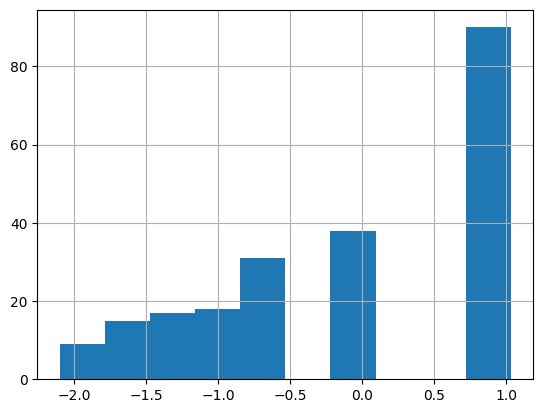

In [732]:



#histogram of exam scores for mastery students
df['Mastery'].hist()

#print bucketed exam scores for mastery students
df['Mastery'].value_counts()


<Axes: >

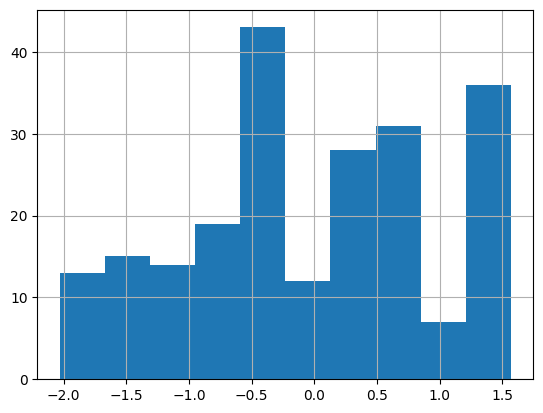

In [733]:
df['Normative'].hist()

<Axes: >

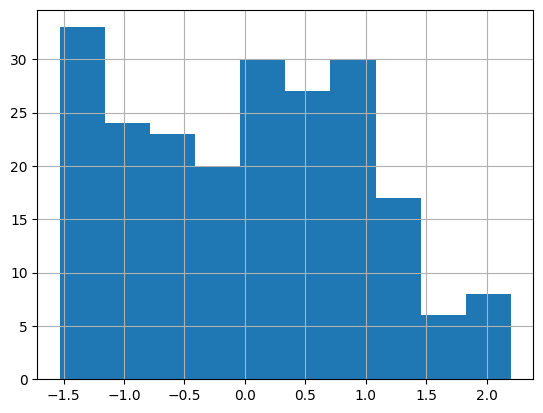

In [734]:
df['Appearance'].hist()

### Total Final Exam Score (Copilot & Noncopilot together)

Base Model for Total Final Exam Score (Copilot & Noncopilot together)

In [735]:
base_model_eq = 'Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_model_eq, df)

Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.170,0.094,-1.815,0.071
Mastery,0.021,0.069,0.299,0.765
Normative*,0.190,0.086,2.197,0.029
Appearance,-0.063,0.083,-0.757,0.450
Prior_Knowledge**,0.363,0.133,2.725,0.007


Model adj. R^2: 0.047, R^2: 0.065, N. obs: 215, F-statistic: 3.637
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), '

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.164,0.095,-1.732,0.085
Mastery,0.011,0.071,0.150,0.881
Normative*,0.205,0.089,2.301,0.022
Appearance,-0.077,0.086,-0.897,0.370
Prior_Knowledge**,0.357,0.134,2.667,0.008


Model adj. R^2: 0.048, R^2: 0.066, N. obs: 214, F-statistic: 3.678


Best Stepwise Model for Total Final Exam Score (Copilot & Noncopilot together)

In [736]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'Final_Exam_Score', check_anova_before_adding=True, display_best_model=True)

#Dict of best models for each number of predictors. Keys are number of predictors, value is a tuple of the best model string equation and the model's adjusted R^2 value
#achievement_goals_dict_best_models

Adding Prior_Knowledge significantly improves the model significantly. P val: 0.011669235085314438
Best adj R^2 before:  0.0017282687862436585  Best adj R^2 after:  0.03203071583627903
models being compared: Final_Exam_Score ~ Mastery and Final_Exam_Score ~ Prior_Knowledge
Adding Normative significantly improves the model significantly. P val: 0.018381788857925904
Best adj R^2 before:  0.03203071583627903  Best adj R^2 after:  0.05269518944328533
models being compared: Final_Exam_Score ~ Prior_Knowledge and Final_Exam_Score ~ Prior_Knowledge + Normative
Adding Mastery:Normative:Prior_Knowledge significantly improves the model significantly. P val: 0.04518605563305511
Best adj R^2 before:  0.05269518944328533  Best adj R^2 after:  0.066172896565733
models being compared: Final_Exam_Score ~ Prior_Knowledge + Normative and Final_Exam_Score ~ Prior_Knowledge + Normative + Mastery:Normative:Prior_Knowledge
Equation:  Final_Exam_Score ~ Prior_Knowledge + Normative + Mastery:Normative:Prior_K

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.172,0.093,-1.845,0.067
Prior_Knowledge**,0.404,0.134,3.020,0.003
Normative**,0.192,0.072,2.679,0.008
Mastery:Normative:Prior_Knowledge,-0.186,0.095,-1.971,0.050
Mastery,0.000,0.070,0.006,0.995


Model adj. R^2: 0.062, R^2: 0.079, N. obs: 215, F-statistic: 4.520
Checking VIF for:  Final_Exam_Score ~ Prior_Knowledge + Normative + Mastery:Normative:Prior_Knowledge + Mastery
Regression eq:  Prior_Knowledge ~ Normative + Mastery:Normative:Prior_Knowledge + Mastery R^2:  0.02652404875937797
Predictor:  Prior_Knowledge VIF:  1.0272467426910497
Regression eq:  Normative ~ Prior_Knowledge + Mastery:Normative:Prior_Knowledge + Mastery R^2:  0.15507914622633934
Predictor:  Normative VIF:  1.1835428082212802
Regression eq:  Mastery:Normative:Prior_Knowledge ~ Prior_Knowledge + Normative + Mastery R^2:  0.11670233423577137
Predictor:  Mastery:Normative:Prior_Knowledge VIF:  1.132121184917658
Regression eq:  Mastery ~ Prior_Knowledge + Normative + Mastery:Normative:Prior_Knowledge R^2:  0.11100843365207247
Predictor:  Mastery VIF:  1.1248700638501072

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alt

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.168,0.094,-1.781,0.076
Prior_Knowledge**,0.421,0.141,2.975,0.003
Normative*,0.178,0.084,2.127,0.035
Mastery:Normative:Prior_Knowledge,-0.135,0.130,-1.045,0.297
Mastery,-0.020,0.075,-0.261,0.795


Model adj. R^2: 0.050, R^2: 0.069, N. obs: 201, F-statistic: 3.650


### Blockwise testing for Total Final Exam Scores

In [737]:

# Run the blockwise selection
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True, display_all_models=display_nonsignificant_tables)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())

Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.170,0.095,-1.793,0.075
Mastery,-0.000,0.098,-0.004,0.997
Normative*,0.250,0.123,2.042,0.042
Appearance,-0.086,0.110,-0.780,0.436
Prior_Knowledge**,0.364,0.134,2.709,0.007
Mastery:Prior_Knowledge,0.040,0.141,0.286,0.775
Normative:Prior_Knowledge,-0.122,0.176,-0.695,0.488
Appearance:Prior_Knowledge,0.059,0.170,0.349,0.727


Model adj. R^2: 0.035, R^2: 0.067, N. obs: 215, F-statistic: 2.124
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + Normative

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.150,0.096,-1.564,0.119
Mastery,-0.043,0.103,-0.419,0.676
Normative*,0.292,0.130,2.238,0.026
Appearance,-0.127,0.115,-1.102,0.272
Prior_Knowledge*,0.353,0.136,2.597,0.010
Mastery:Prior_Knowledge,0.093,0.146,0.635,0.526
Normative:Prior_Knowledge,-0.163,0.187,-0.870,0.385
Appearance:Prior_Knowledge,0.096,0.179,0.539,0.591


Model adj. R^2: 0.036, R^2: 0.068, N. obs: 211, F-statistic: 2.123


Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.150,0.104,-1.443,0.151
Mastery,0.015,0.076,0.193,0.847
Normative*,0.202,0.095,2.124,0.035
Appearance,-0.059,0.087,-0.680,0.497
Prior_Knowledge**,0.359,0.135,2.651,0.009
Mastery:Appearance,-0.013,0.084,-0.152,0.879
Normative:Appearance,-0.012,0.076,-0.161,0.872
Mastery:Normative,-0.036,0.087,-0.417,0.677


Model adj. R^2: 0.035, R^2: 0.067, N. obs: 215, F-statistic: 2.120
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  Prior_K

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.110,0.113,-0.976,0.330
Mastery,0.014,0.083,0.166,0.869
Normative,0.202,0.106,1.906,0.058
Appearance,-0.098,0.094,-1.040,0.299
Prior_Knowledge*,0.364,0.141,2.582,0.011
Mastery:Appearance,0.053,0.100,0.530,0.597
Normative:Appearance,-0.066,0.088,-0.752,0.453
Mastery:Normative,-0.050,0.108,-0.468,0.641


Model adj. R^2: 0.034, R^2: 0.067, N. obs: 201, F-statistic: 1.992
Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.177,0.095,-1.867,0.063
Mastery,-0.018,0.079,-0.234,0.815
Normative*,0.234,0.090,2.600,0.010
Appearance,-0.066,0.084,-0.780,0.436
Prior_Knowledge***,0.576,0.154,3.749,0.000
Mastery:Normative:Appearance,0.021,0.067,0.311,0.756
Mastery:Normative:Prior_Knowledge**,-0.376,0.133,-2.818,0.005
Mastery:Appearance:Prior_Knowledge*,0.288,0.139,2.068,0.040
Normative:Appearance:Prior_Knowledge,-0.195,0.104,-1.885,0.061


Model adj. R^2: 0.077, R^2: 0.111, N. obs: 215, F-statistic: 3.220
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.169,0.098,-1.728,0.086
Mastery,-0.045,0.090,-0.496,0.621
Normative*,0.245,0.100,2.455,0.015
Appearance,-0.094,0.095,-0.989,0.324
Prior_Knowledge**,0.541,0.166,3.263,0.001
Mastery:Normative:Appearance,0.107,0.090,1.191,0.235
Mastery:Normative:Prior_Knowledge,-0.280,0.159,-1.761,0.080
Mastery:Appearance:Prior_Knowledge*,0.342,0.168,2.034,0.043
Normative:Appearance:Prior_Knowledge,-0.266,0.138,-1.929,0.055


Model adj. R^2: 0.059, R^2: 0.098, N. obs: 195, F-statistic: 2.532
----------------------Adding block '+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge' improves the model significantly.
The best blockwise model is below: 
Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.177,0.095,-1.867,0.063
Mastery,-0.018,0.079,-0.234,0.815
Normative*,0.234,0.090,2.600,0.010
Appearance,-0.066,0.084,-0.780,0.436
Prior_Knowledge***,0.576,0.154,3.749,0.000
Mastery:Normative:Appearance,0.021,0.067,0.311,0.756
Mastery:Normative:Prior_Knowledge**,-0.376,0.133,-2.818,0.005
Mastery:Appearance:Prior_Knowledge*,0.288,0.139,2.068,0.040
Normative:Appearance:Prior_Knowledge,-0.195,0.104,-1.885,0.061


Model adj. R^2: 0.077, R^2: 0.111, N. obs: 215, F-statistic: 3.220
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.169,0.098,-1.728,0.086
Mastery,-0.045,0.090,-0.496,0.621
Normative*,0.245,0.100,2.455,0.015
Appearance,-0.094,0.095,-0.989,0.324
Prior_Knowledge**,0.541,0.166,3.263,0.001
Mastery:Normative:Appearance,0.107,0.090,1.191,0.235
Mastery:Normative:Prior_Knowledge,-0.280,0.159,-1.761,0.080
Mastery:Appearance:Prior_Knowledge*,0.342,0.168,2.034,0.043
Normative:Appearance:Prior_Knowledge,-0.266,0.138,-1.929,0.055


Model adj. R^2: 0.059, R^2: 0.098, N. obs: 195, F-statistic: 2.532
Displaying ANOVA results:
model1:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,199.703,0.000,NaN,NaN,NaN
1,206.000,189.805,4.000,9.898,2.686,0.032


F(4.0, 206.0) = 2.69, p = 0.03
NOTE: ANOVA The difference between models is significant.


### Copilot Final Exam Question 

Base Model for Copilot Final Exam Question

In [738]:
"""
base_model_eq = 'Final_copilot_question ~ Mastery+Normative+Appearance+Prior_Knowledge'
base_model = display_model_info(base_model_eq, df)
"""

"\nbase_model_eq = 'Final_copilot_question ~ Mastery+Normative+Appearance+Prior_Knowledge'\nbase_model = display_model_info(base_model_eq, df)\n"

Best Stepwise Model for Copilot Final Exam Question

In [739]:
"""
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars, 'Final_copilot_question', display_best_model=True)
"""

"\n_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars, 'Final_copilot_question', display_best_model=True)\n"

### Blockwise testing for Copilot Question Scores

In [740]:
"""
_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())
"""

'\n_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True)\n\ndisplay_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())\n'

### Non-Copilot Final Exam Question 

Base Model for Non-Copilot Final Exam Question

In [741]:
base_model_eq = 'Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge'
base_model = display_model_info(base_model_eq, df)


Equation:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.221,0.093,-2.372,0.019
Mastery,0.002,0.069,0.026,0.979
Normative*,0.185,0.086,2.165,0.032
Appearance,-0.054,0.083,-0.653,0.514
Prior_Knowledge***,0.466,0.132,3.523,0.001


Model adj. R^2: 0.066, R^2: 0.084, N. obs: 215, F-statistic: 4.785
Checking VIF for:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.211,0.094,-2.260,0.025
Mastery,-0.012,0.070,-0.173,0.863
Normative*,0.207,0.088,2.341,0.020
Appearance,-0.073,0.085,-0.860,0.391
Prior_Knowledge***,0.457,0.132,3.447,0.001


Model adj. R^2: 0.067, R^2: 0.085, N. obs: 214, F-statistic: 4.849


Best Stepwise Model for Non-Copilot Final Exam Question

In [742]:
#_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars,'Final_noncopilot_questions', check_anova_before_adding=True, display_best_model=True)

### Blockwise testing for Non-Copilot Scores

In [743]:

_, best_model_eq, best_models = blockwise_selection(df, possible_blocks, base_model_eq,check_anova_before_adding=True, display_best_model=True)

display_anova(ols(base_model_eq, df).fit(), ols(best_model_eq, df).fit())


----------------------Adding block '+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge' improves the model significantly.
The best blockwise model is below: 
Equation:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.228,0.094,-2.430,0.016
Mastery,-0.045,0.078,-0.575,0.566
Normative**,0.241,0.089,2.707,0.007
Appearance,-0.061,0.083,-0.734,0.463
Prior_Knowledge***,0.673,0.152,4.437,0.000
Mastery:Normative:Appearance,0.021,0.066,0.321,0.749
Mastery:Normative:Prior_Knowledge**,-0.420,0.132,-3.195,0.002
Mastery:Appearance:Prior_Knowledge*,0.323,0.137,2.348,0.020
Normative:Appearance:Prior_Knowledge,-0.173,0.102,-1.694,0.092


Model adj. R^2: 0.102, R^2: 0.136, N. obs: 215, F-statistic: 4.039
Checking VIF for:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.220,0.097,-2.265,0.025
Mastery,-0.089,0.089,-0.998,0.320
Normative**,0.265,0.099,2.683,0.008
Appearance,-0.100,0.094,-1.070,0.286
Prior_Knowledge***,0.632,0.164,3.843,0.000
Mastery:Normative:Appearance,0.117,0.090,1.305,0.194
Mastery:Normative:Prior_Knowledge*,-0.333,0.158,-2.113,0.036
Mastery:Appearance:Prior_Knowledge*,0.381,0.167,2.285,0.023
Normative:Appearance:Prior_Knowledge,-0.194,0.137,-1.416,0.158


Model adj. R^2: 0.084, R^2: 0.121, N. obs: 195, F-statistic: 3.211
Displaying ANOVA results:
model1:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Final_noncopilot_questions ~ Mastery+Normative+Appearance+Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,196.137,0.000,NaN,NaN,NaN
1,206.000,185.000,4.000,11.137,3.100,0.017


F(4.0, 206.0) = 3.10, p = 0.02
NOTE: ANOVA The difference between models is significant.


## Interest

Base Model for Interest

In [744]:
base_interest_eq = 'Interest ~ Mastery+Normative+Appearance+Prior_Knowledge' 
base_model = display_model_info(base_interest_eq, df)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.317,0.085,-3.709,0.000
Mastery***,0.334,0.063,5.285,0.000
Normative,0.038,0.079,0.479,0.632
Appearance,0.035,0.076,0.467,0.641
Prior_Knowledge***,0.628,0.121,5.179,0.000


Model adj. R^2: 0.223, R^2: 0.237, N. obs: 215, F-statistic: 16.323
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge R^2:  0.0893422592783627
Predictor:  Mastery VIF:  1.0981073956584004
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge R^2:  0.4062091620707189
Predictor:  Normative VIF:  1.6840946948378097
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge R^2:  0.36193447116798927
Predictor:  Appearance VIF:  1.567237148558262
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance R^2:  0.0054109174741615584
Predictor:  Prior_Knowledge VIF:  1.005440354784933

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([8]), 'outliers_abs_gt_2_5

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.313,0.083,-3.766,0.000
Mastery***,0.360,0.061,5.889,0.000
Normative,0.054,0.076,0.716,0.475
Appearance,0.041,0.072,0.565,0.573
Prior_Knowledge***,0.687,0.118,5.842,0.000


Model adj. R^2: 0.279, R^2: 0.293, N. obs: 204, F-statistic: 20.620
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.310,0.086,-3.611,0.000
Mastery***,0.324,0.065,5.022,0.000
Normative,0.052,0.081,0.647,0.518
Appearance,0.022,0.078,0.286,0.775
Prior_Knowledge***,0.622,0.122,5.110,0.000


Model adj. R^2: 0.215, R^2: 0.229, N. obs: 214, F-statistic: 15.558


Best model for Interest

In [745]:
_, best_model_eq, best_models = stepwise_selection(df, achievement_goals_replication_vars, 'Interest', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 2.2753631573753024e-05
Best adj R^2 before:  0.13227963245173513  Best adj R^2 after:  0.22587867661925265
models being compared: Interest ~ Mastery and Interest ~ Mastery + Prior_Knowledge
Equation:  Interest ~ Mastery + Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.317,0.085,-3.722,0.000
Mastery***,0.347,0.060,5.744,0.000
Prior_Knowledge***,0.630,0.121,5.206,0.000


Model adj. R^2: 0.226, R^2: 0.233, N. obs: 215, F-statistic: 32.221
Checking VIF for:  Interest ~ Mastery + Prior_Knowledge
Regression eq:  Mastery ~ Prior_Knowledge R^2:  0.004578133795059003
Predictor:  Mastery VIF:  1.0045991894999386
Regression eq:  Prior_Knowledge ~ Mastery R^2:  0.004578133795059447
Predictor:  Prior_Knowledge VIF:  1.004599189499939

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([8]), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [22]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [356]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.317,0.083,-3.795,0.000
Mastery***,0.359,0.059,6.070,0.000
Prior_Knowledge***,0.655,0.119,5.518,0.000


Model adj. R^2: 0.247, R^2: 0.254, N. obs: 214, F-statistic: 35.907
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.312,0.086,-3.638,0.000
Mastery***,0.341,0.061,5.584,0.000
Prior_Knowledge***,0.625,0.121,5.149,0.000


Model adj. R^2: 0.218, R^2: 0.225, N. obs: 214, F-statistic: 30.639


### Blockwise testing for Interest

Equations: 


eq = base_model_eq + priorexpblock 


eq = base_model_eq + betweenachievementsblock


eq = base_model_eq + threewayinteractionsblock

Result: None are significant

In [746]:
eq = base_interest_eq + priorexpblock
block_model = display_model_info(eq, df)
display_anova(base_model, block_model)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.317,0.086,-3.690,0.000
Mastery***,0.361,0.089,4.077,0.000
Normative,-0.022,0.111,-0.200,0.841
Appearance,0.029,0.100,0.294,0.769
Prior_Knowledge***,0.628,0.122,5.148,0.000
Mastery:Prior_Knowledge,-0.046,0.128,-0.363,0.717
Normative:Prior_Knowledge,0.109,0.160,0.684,0.495
Appearance:Prior_Knowledge,0.008,0.155,0.050,0.961


Model adj. R^2: 0.214, R^2: 0.240, N. obs: 215, F-statistic: 9.348
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.5318426106437928
Predictor:  Mastery VIF:  2.1360337842262047
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.7016947280090498
Predictor:  Normative VIF:  3.35227062306273
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge R^2:  0.6278461976732327
Predictor:  Appearance VIF:  2.6870610853572745
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Prior_Knowledge + Normative:Prior_Kn

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.299,0.085,-3.527,0.001
Mastery***,0.348,0.087,3.992,0.000
Normative,-0.001,0.110,-0.010,0.992
Appearance,0.015,0.098,0.156,0.876
Prior_Knowledge***,0.634,0.120,5.288,0.000
Mastery:Prior_Knowledge,-0.008,0.126,-0.060,0.952
Normative:Prior_Knowledge,0.096,0.157,0.616,0.539
Appearance:Prior_Knowledge,0.023,0.152,0.150,0.881


Model adj. R^2: 0.229, R^2: 0.255, N. obs: 212, F-statistic: 9.961
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.307,0.087,-3.519,0.001
Mastery***,0.338,0.094,3.607,0.000
Normative,0.003,0.119,0.025,0.980
Appearance,0.006,0.105,0.053,0.957
Prior_Knowledge***,0.603,0.124,4.881,0.000
Mastery:Prior_Knowledge,-0.040,0.133,-0.299,0.765
Normative:Prior_Knowledge,0.090,0.170,0.530,0.597
Appearance:Prior_Knowledge,0.032,0.163,0.198,0.844


Model adj. R^2: 0.191, R^2: 0.218, N. obs: 211, F-statistic: 8.063
Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Prior_Knowledge + Normative:Prior_Knowledge + Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,165.220,0.000,NaN,NaN,NaN
1,207.000,164.568,3.000,0.652,0.273,0.845


F(3.0, 207.0) = 0.27, p = 0.84


In [747]:
eq3 = base_interest_eq + betweenachievementsblock
m3 = display_model_info(eq3, df)

display_anova(base_model, m3)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Appearance + Normative:Appearance + Mastery:Normative


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.308,0.095,-3.255,0.001
Mastery***,0.329,0.069,4.763,0.000
Normative,0.056,0.086,0.646,0.519
Appearance,0.031,0.079,0.386,0.700
Prior_Knowledge***,0.620,0.123,5.039,0.000
Mastery:Appearance,-0.050,0.077,-0.650,0.516
Normative:Appearance,0.001,0.069,0.017,0.987
Mastery:Normative,-0.007,0.079,-0.094,0.925


Model adj. R^2: 0.214, R^2: 0.240, N. obs: 215, F-statistic: 9.333
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Appearance + Normative:Appearance + Mastery:Normative
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.22717444389908514
Predictor:  Mastery VIF:  1.2939530688467824
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.5024687297337997
Predictor:  Normative VIF:  2.009923917877479
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.41001987010701224
Predictor:  Appearance VIF:  1.6949723377656511
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + Mastery:Appearance + Normative:Appearance + Mastery:Normative R^2:  0.021475980874982925
Predictor:  Prior_Knowledge 

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.303,0.093,-3.280,0.001
Mastery***,0.346,0.068,5.108,0.000
Normative,0.053,0.084,0.632,0.528
Appearance,0.033,0.077,0.430,0.668
Prior_Knowledge***,0.647,0.121,5.368,0.000
Mastery:Appearance,-0.048,0.075,-0.639,0.523
Normative:Appearance,-0.012,0.068,-0.171,0.864
Mastery:Normative,0.001,0.077,0.014,0.989


Model adj. R^2: 0.236, R^2: 0.261, N. obs: 214, F-statistic: 10.402
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.286,0.102,-2.809,0.005
Mastery***,0.322,0.075,4.268,0.000
Normative,0.059,0.096,0.618,0.537
Appearance,0.058,0.085,0.684,0.495
Prior_Knowledge***,0.580,0.127,4.546,0.000
Mastery:Appearance,-0.017,0.090,-0.183,0.855
Normative:Appearance,0.015,0.079,0.187,0.852
Mastery:Normative,-0.068,0.097,-0.694,0.488


Model adj. R^2: 0.200, R^2: 0.228, N. obs: 201, F-statistic: 8.130
Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Appearance + Normative:Appearance + Mastery:Normative


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,165.220,0.000,NaN,NaN,NaN
1,207.000,164.631,3.000,0.589,0.247,0.863


F(3.0, 207.0) = 0.25, p = 0.86


In [748]:
eq4 = base_interest_eq + threewayinteractionsblock
m4 = display_model_info(eq4, df)
display_anova(base_model, m4)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.279,0.088,-3.180,0.002
Mastery***,0.390,0.073,5.377,0.000
Normative,0.049,0.083,0.587,0.558
Appearance,0.059,0.078,0.755,0.451
Prior_Knowledge***,0.597,0.142,4.207,0.000
Mastery:Normative:Appearance,-0.116,0.062,-1.884,0.061
Mastery:Normative:Prior_Knowledge,-0.082,0.123,-0.666,0.506
Mastery:Appearance:Prior_Knowledge,0.089,0.129,0.695,0.488
Normative:Appearance:Prior_Knowledge,0.037,0.096,0.386,0.700


Model adj. R^2: 0.223, R^2: 0.252, N. obs: 215, F-statistic: 8.669
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.31006621500721976
Predictor:  Mastery VIF:  1.4494144536065363
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge R^2:  0.47080845819976913
Predictor:  Normative VIF:  1.8896749494486416
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearan

,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.267,0.085,-3.152,0.002
Mastery***,0.431,0.070,6.168,0.000
Normative,0.062,0.080,0.782,0.435
Appearance,0.071,0.074,0.968,0.334
Prior_Knowledge***,0.681,0.137,4.982,0.000
Mastery:Normative:Appearance*,-0.136,0.059,-2.324,0.021
Mastery:Normative:Prior_Knowledge,-0.112,0.117,-0.951,0.343
Mastery:Appearance:Prior_Knowledge,0.126,0.122,1.039,0.300
Normative:Appearance:Prior_Knowledge,-0.001,0.092,-0.016,0.987


Model adj. R^2: 0.288, R^2: 0.316, N. obs: 204, F-statistic: 11.255
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept**,-0.273,0.092,-2.956,0.004
Mastery***,0.347,0.085,4.095,0.000
Normative,0.071,0.094,0.755,0.451
Appearance,0.028,0.089,0.318,0.751
Prior_Knowledge***,0.638,0.157,4.074,0.000
Mastery:Normative:Appearance,-0.056,0.085,-0.659,0.511
Mastery:Normative:Prior_Knowledge,-0.193,0.150,-1.285,0.200
Mastery:Appearance:Prior_Knowledge,0.222,0.159,1.401,0.163
Normative:Appearance:Prior_Knowledge,0.019,0.130,0.144,0.886


Model adj. R^2: 0.203, R^2: 0.236, N. obs: 195, F-statistic: 7.178
Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+ Mastery:Normative:Appearance + Mastery:Normative:Prior_Knowledge + Mastery:Appearance:Prior_Knowledge + Normative:Appearance:Prior_Knowledge


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,210.000,165.220,0.000,NaN,NaN,NaN
1,206.000,162.039,4.000,3.181,1.011,0.403


F(4.0, 206.0) = 1.01, p = 0.40


# 2nd paper: Self Efficacy & Other Attributes

Independent variables attributes we're considering: 
- Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief + CSMajor + SelfEfficacy + CanDoThisTask

Dependent variables we're considering: 
- attitudes, performance, and self-reported use of GenAI 

Note: 
Self efficacy was measured pre, and sense of belonging was measured post. 

In [772]:
all_factors = ['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge', 'CSMajor', 'SelfEfficacy', 'EndProgIntelligenceBelief', 'CanDoThisTask', 'Belonging', 'PreProgIntelligenceBelief', 'MidProgIntelligenceBelief']

In [773]:
base_factors = ['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge', 'CSMajor']

### Default/Non temporal blocks? 

Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief + CSMajor

### Pre-Survey Blocks 

Programming Intelligence, Self Efficacy


### End-Survey Blocks 

Programming Intelligence
CanDoThisTask
Belonging 


### Interactions we're interested in 

In [774]:
priorexp_interactions = [f'Mastery*Prior_Knowledge', f'Normative*Prior_Knowledge', f'Appearance*Prior_Knowledge', f'CSMajor*Prior_Knowledge', f'SelfEfficacy*Prior_Knowledge', f'EndProgIntelligenceBelief*Prior_Knowledge', f'CanDoThisTask*Prior_Knowledge', f'Belonging*Prior_Knowledge']
progintelligence_interactions = [f'Mastery*EndProgIntelligenceBelief', f'Normative*EndProgIntelligenceBelief', f'Appearance*EndProgIntelligenceBelief', f'CSMajor*EndProgIntelligenceBelief', f'SelfEfficacy*EndProgIntelligenceBelief', f'CanDoThisTask*EndProgIntelligenceBelief', f'Belonging*EndProgIntelligenceBelief']
candothistask_interactions = [f'Mastery*CanDoThisTask', f'Normative*CanDoThisTask', f'Appearance*CanDoThisTask', f'CSMajor*CanDoThisTask', f'SelfEfficacy*CanDoThisTask', f'EndProgIntelligenceBelief*CanDoThisTask', f'Belonging*CanDoThisTask']
csmajor_interactions = [f'Mastery*CSMajor', f'Normative*CSMajor', f'Appearance*CSMajor', f'SelfEfficacy*CSMajor', f'EndProgIntelligenceBelief*CSMajor', f'CanDoThisTask*CSMajor', f'Belonging*CSMajor']
belonging_interactions = [f'Mastery*Belonging', f'Normative*Belonging', f'Appearance*Belonging', f'CSMajor*Belonging', f'SelfEfficacy*Belonging', f'EndProgIntelligenceBelief*Belonging', f'CanDoThisTask*Belonging']
mastery_interactions = [f'Normative*Mastery', f'Appearance*Mastery', f'CSMajor*Mastery', f'SelfEfficacy*Mastery', f'EndProgIntelligenceBelief*Mastery', f'CanDoThisTask*Mastery', f'Belonging*Mastery']
normative_interactions = [f'Appearance*Normative', f'CSMajor*Normative', f'SelfEfficacy*Normative', f'EndProgIntelligenceBelief*Normative', f'CanDoThisTask*Normative', f'Belonging*Normative']

#TODO: Add Preprogramming intelligence belief to the interactions


## Interest

#### Base  

In [775]:
base_all_factors_interest_eq = 'Interest ~ ' + '+'.join(base_factors)
base_model = display_model_info(base_all_factors_interest_eq, df)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.573,0.090,-6.343,0.000
Mastery***,0.245,0.061,4.038,0.000
Normative,0.048,0.073,0.665,0.507
Appearance,-0.016,0.071,-0.224,0.823
Prior_Knowledge***,0.484,0.115,4.206,0.000
CSMajor***,0.714,0.121,5.917,0.000


Model adj. R^2: 0.331, R^2: 0.347, N. obs: 215, F-statistic: 22.175
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor R^2:  0.14621343819482113
Predictor:  Mastery VIF:  1.1712529158173666
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor R^2:  0.4065844902678787
Predictor:  Normative VIF:  1.6851598645465442
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor R^2:  0.37147177723202973
Predictor:  Appearance VIF:  1.5910184519576673
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + CSMajor R^2:  0.049852035396446115
Predictor:  Prior_Knowledge VIF:  1.0524676547796918
Regression eq:  CSMajor ~ Mastery + Normative + Appearance + Prior_Knowledge R^2:  0.12862934125989145
Predictor:  CSMajor VIF:  1.1476172510167753

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogor

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.614,0.088,-7.010,0.000
Mastery***,0.266,0.058,4.628,0.000
Normative,0.040,0.068,0.584,0.560
Appearance,-0.055,0.067,-0.820,0.413
Prior_Knowledge***,0.500,0.110,4.559,0.000
CSMajor***,0.786,0.115,6.816,0.000


Model adj. R^2: 0.404, R^2: 0.419, N. obs: 203, F-statistic: 28.368
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.566,0.091,-6.243,0.000
Mastery***,0.234,0.062,3.793,0.000
Normative,0.064,0.075,0.850,0.396
Appearance,-0.030,0.073,-0.406,0.685
Prior_Knowledge***,0.478,0.115,4.136,0.000
CSMajor***,0.714,0.121,5.917,0.000


Model adj. R^2: 0.325, R^2: 0.340, N. obs: 214, F-statistic: 21.475


In [776]:
pre_factors_block = '+ PreProgIntelligenceBelief' #+ SelfEfficacy'
mid_factors_block = '+ MidProgIntelligenceBelief' #+ Belonging' 
end_factors_block = '+ EndProgIntelligenceBelief' #+ CanDoThisTask + Belonging'


#possible_blocks = [pre_factors_block, end_factors_block]

### Pre-Factors Block

In [777]:
pre_eq = base_all_factors_interest_eq + pre_factors_block

pre_model = display_model_info(pre_eq, df)


Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ PreProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.552,0.089,-6.173,0.000
Mastery*,0.169,0.066,2.542,0.012
Normative,0.046,0.072,0.637,0.525
Appearance,0.013,0.071,0.189,0.850
Prior_Knowledge***,0.467,0.114,4.104,0.000
CSMajor***,0.688,0.119,5.768,0.000
PreProgIntelligenceBelief**,-0.167,0.064,-2.611,0.010


Model adj. R^2: 0.349, R^2: 0.367, N. obs: 215, F-statistic: 20.130
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ PreProgIntelligenceBelief
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor + PreProgIntelligenceBelief R^2:  0.30911713915825667
Predictor:  Mastery VIF:  1.4474233718602325
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor + PreProgIntelligenceBelief R^2:  0.4067070262129232
Predictor:  Normative VIF:  1.6855079095524292
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor + PreProgIntelligenceBelief R^2:  0.38716858677534005
Predictor:  Appearance VIF:  1.6317701384432892
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + CSMajor + PreProgIntelligenceBelief R^2:  0.05309332020876778
Predictor:  Prior_Knowledge VIF:  1.0560702774010142
Regression eq:  CSMajor ~ Mastery + Normative + Appearance + Prior_Knowledge + PreProgIntelligenceBelief R

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.526,0.088,-5.968,0.000
Mastery**,0.190,0.065,2.902,0.004
Normative,0.040,0.070,0.567,0.572
Appearance,0.011,0.069,0.159,0.874
Prior_Knowledge***,0.489,0.112,4.371,0.000
CSMajor***,0.665,0.117,5.662,0.000
PreProgIntelligenceBelief**,-0.178,0.063,-2.810,0.005


Model adj. R^2: 0.378, R^2: 0.396, N. obs: 210, F-statistic: 22.183
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.539,0.090,-5.954,0.000
Mastery*,0.160,0.068,2.345,0.020
Normative,0.062,0.074,0.835,0.405
Appearance,0.000,0.073,0.007,0.995
Prior_Knowledge***,0.458,0.115,3.985,0.000
CSMajor***,0.688,0.120,5.734,0.000
PreProgIntelligenceBelief*,-0.159,0.066,-2.391,0.018


Model adj. R^2: 0.337, R^2: 0.355, N. obs: 212, F-statistic: 18.836


In [778]:
display_anova(base_model, pre_model)

Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ PreProgIntelligenceBelief


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,209.000,141.514,0.000,NaN,NaN,NaN
1,208.000,137.024,1.000,4.490,6.816,0.010


F(1.0, 208.0) = 6.82, p = 0.01
NOTE: ANOVA The difference between models is significant.


In [779]:
pre_eq = base_all_factors_interest_eq + mid_factors_block

mid_model = display_model_info(pre_eq, df)


Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ MidProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.405,0.086,-4.695,0.000
Mastery*,0.146,0.057,2.543,0.012
Normative,0.082,0.067,1.231,0.220
Appearance,-0.053,0.065,-0.823,0.411
Prior_Knowledge**,0.315,0.108,2.917,0.004
CSMajor***,0.533,0.113,4.703,0.000
MidProgIntelligenceBelief***,-0.381,0.058,-6.569,0.000


Model adj. R^2: 0.443, R^2: 0.459, N. obs: 215, F-statistic: 29.400
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ MidProgIntelligenceBelief
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor + MidProgIntelligenceBelief R^2:  0.20523073808374337
Predictor:  Mastery VIF:  1.2582268186730252
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor + MidProgIntelligenceBelief R^2:  0.4100782650619875
Predictor:  Normative VIF:  1.6951401190618576
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor + MidProgIntelligenceBelief R^2:  0.37635326596590324
Predictor:  Appearance VIF:  1.603471878272238
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + CSMajor + MidProgIntelligenceBelief R^2:  0.10355392416191689
Predictor:  Prior_Knowledge VIF:  1.1155160661115113
Regression eq:  CSMajor ~ Mastery + Normative + Appearance + Prior_Knowledge + MidProgIntelligenceBelief R^

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.353,0.083,-4.266,0.000
Mastery*,0.127,0.055,2.329,0.021
Normative,0.107,0.063,1.699,0.091
Appearance,-0.080,0.062,-1.283,0.201
Prior_Knowledge*,0.221,0.104,2.127,0.035
CSMajor***,0.595,0.107,5.553,0.000
MidProgIntelligenceBelief***,-0.445,0.056,-7.879,0.000


Model adj. R^2: 0.517, R^2: 0.531, N. obs: 203, F-statistic: 37.004
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.405,0.087,-4.664,0.000
Mastery*,0.140,0.059,2.392,0.018
Normative,0.096,0.069,1.401,0.163
Appearance,-0.075,0.067,-1.124,0.262
Prior_Knowledge**,0.302,0.108,2.785,0.006
CSMajor***,0.549,0.114,4.805,0.000
MidProgIntelligenceBelief***,-0.371,0.059,-6.284,0.000


Model adj. R^2: 0.437, R^2: 0.453, N. obs: 213, F-statistic: 28.443


In [780]:
display_anova(base_model, mid_model)

Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ MidProgIntelligenceBelief


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,209.000,141.514,0.000,NaN,NaN,NaN
1,208.000,117.198,1.000,24.317,43.156,0.000


F(1.0, 208.0) = 43.16, p = 0.00
NOTE: ANOVA The difference between models is significant.


count   218.000
mean      0.000
std       1.002
min      -2.456
25%      -0.715
50%      -0.129
75%       0.752
max       2.722
Name: EndProgIntelligenceBelief, dtype: float64

### End-Factors Block

In [781]:
end_eq = base_all_factors_interest_eq + end_factors_block

end_model = display_model_info(end_eq, df)



Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ EndProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.379,0.082,-4.617,0.000
Mastery**,0.147,0.054,2.721,0.007
Normative,0.088,0.064,1.391,0.166
Appearance,-0.035,0.062,-0.564,0.573
Prior_Knowledge*,0.258,0.104,2.487,0.014
CSMajor***,0.534,0.107,4.984,0.000
EndProgIntelligenceBelief***,-0.447,0.054,-8.248,0.000


Model adj. R^2: 0.493, R^2: 0.508, N. obs: 215, F-statistic: 35.744
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ EndProgIntelligenceBelief
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor + EndProgIntelligenceBelief R^2:  0.18718433288648362
Predictor:  Mastery VIF:  1.230291246170507
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor + EndProgIntelligenceBelief R^2:  0.4100306905714184
Predictor:  Normative VIF:  1.6950034247858692
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor + EndProgIntelligenceBelief R^2:  0.37234629145027687
Predictor:  Appearance VIF:  1.5932352288822322
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + CSMajor + EndProgIntelligenceBelief R^2:  0.11596973506579544
Predictor:  Prior_Knowledge VIF:  1.13118299187916
Regression eq:  CSMajor ~ Mastery + Normative + Appearance + Prior_Knowledge + EndProgIntelligenceBelief R^2:

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.374,0.083,-4.526,0.000
Mastery*,0.143,0.056,2.550,0.012
Normative,0.108,0.066,1.653,0.100
Appearance,-0.055,0.063,-0.871,0.385
Prior_Knowledge*,0.267,0.105,2.537,0.012
CSMajor***,0.528,0.109,4.847,0.000
EndProgIntelligenceBelief***,-0.431,0.058,-7.373,0.000


Model adj. R^2: 0.482, R^2: 0.497, N. obs: 211, F-statistic: 33.611


In [782]:
display_anova(base_model, end_model)

Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+ EndProgIntelligenceBelief


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,209.000,141.514,0.000,NaN,NaN,NaN
1,208.000,106.637,1.000,34.877,68.028,0.000


F(1.0, 208.0) = 68.03, p = 0.00
NOTE: ANOVA The difference between models is significant.


In [783]:
#model with all factors 

all_factors_interest_eq = 'Interest ~ ' + '+'.join(all_factors)

all_factors_model = display_model_info(all_factors_interest_eq, df)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+CanDoThisTask+Belonging+PreProgIntelligenceBelief+MidProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.172,0.079,-2.173,0.031
Mastery,0.105,0.053,1.957,0.052
Normative,0.052,0.058,0.890,0.374
Appearance,-0.032,0.057,-0.569,0.570
Prior_Knowledge,-0.006,0.101,-0.058,0.954
CSMajor***,0.369,0.099,3.730,0.000
SelfEfficacy,-0.035,0.053,-0.662,0.508
EndProgIntelligenceBelief***,-0.243,0.071,-3.438,0.001
CanDoThisTask***,0.195,0.054,3.620,0.000
Belonging***,0.346,0.054,6.380,0.000


Model adj. R^2: 0.600, R^2: 0.620, N. obs: 215, F-statistic: 30.137
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+CanDoThisTask+Belonging+PreProgIntelligenceBelief+MidProgIntelligenceBelief
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + CanDoThisTask + Belonging + PreProgIntelligenceBelief + MidProgIntelligenceBelief R^2:  0.3441659249135598
Predictor:  Mastery VIF:  1.524775912060071
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + CanDoThisTask + Belonging + PreProgIntelligenceBelief + MidProgIntelligenceBelief R^2:  0.44519384758392866
Predictor:  Normative VIF:  1.8024313458767487
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + CanDoThisTask + Belonging + PreProgIntelligenceBelief + MidPro

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.151,0.078,-1.937,0.054
Mastery*,0.119,0.053,2.273,0.024
Normative,0.059,0.057,1.035,0.302
Appearance,-0.035,0.055,-0.632,0.528
Prior_Knowledge,0.005,0.099,0.051,0.959
CSMajor***,0.330,0.097,3.390,0.001
SelfEfficacy,-0.038,0.052,-0.736,0.463
EndProgIntelligenceBelief***,-0.254,0.069,-3.670,0.000
CanDoThisTask***,0.191,0.053,3.615,0.000
Belonging***,0.368,0.054,6.864,0.000


Model adj. R^2: 0.616, R^2: 0.636, N. obs: 214, F-statistic: 32.048
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.163,0.082,-1.996,0.047
Mastery,0.100,0.056,1.798,0.074
Normative,0.058,0.061,0.955,0.341
Appearance,-0.043,0.059,-0.718,0.474
Prior_Knowledge,-0.019,0.103,-0.184,0.854
CSMajor***,0.373,0.101,3.702,0.000
SelfEfficacy,-0.030,0.055,-0.549,0.584
EndProgIntelligenceBelief**,-0.241,0.073,-3.308,0.001
CanDoThisTask***,0.198,0.055,3.585,0.000
Belonging***,0.343,0.056,6.140,0.000


Model adj. R^2: 0.588, R^2: 0.609, N. obs: 211, F-statistic: 28.223


In [784]:
#anova
display_anova(base_model, all_factors_model)

Displaying ANOVA results:
model1:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor
model2:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+CanDoThisTask+Belonging+PreProgIntelligenceBelief+MidProgIntelligenceBelief


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,209.000,141.514,0.000,NaN,NaN,NaN
1,203.000,82.259,6.000,59.256,24.372,0.000


F(6.0, 203.0) = 24.37, p = 0.00
NOTE: ANOVA The difference between models is significant.


In [801]:
#binarize final exam score to be 1 if above median, 0 if below. store as new variable binarized_final_exam_score
df['binarized_final_exam_score'] = df['Final_Exam_Score'].apply(lambda x: 1 if x > df['Final_Exam_Score'].median() else 0)

/var/folders/rj/v7fdl50s2r399r_h_3s2xrjr0000gn/T/ipykernel_33404/3288725663.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['binarized_final_exam_score'] = df['Final_Exam_Score'].apply(lambda x: 1 if x > df['Final_Exam_Score'].median() else 0)


In [802]:
all_factors_interest_eq = 'Interest ~ ' + '+'.join(all_factors) + ' + EndProgIntelligenceBelief*binarized_final_exam_score'
display_model_info(all_factors_interest_eq, df)

Equation:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+CanDoThisTask+Belonging+PreProgIntelligenceBelief+MidProgIntelligenceBelief + EndProgIntelligenceBelief*binarized_final_exam_score


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.181,0.097,-1.867,0.063
Mastery,0.102,0.054,1.900,0.059
Normative,0.049,0.059,0.837,0.404
Appearance,-0.037,0.057,-0.640,0.523
Prior_Knowledge,-0.010,0.101,-0.103,0.918
CSMajor***,0.370,0.099,3.724,0.000
SelfEfficacy,-0.033,0.053,-0.624,0.533
EndProgIntelligenceBelief*,-0.193,0.084,-2.305,0.022
CanDoThisTask**,0.192,0.058,3.328,0.001
Belonging***,0.355,0.055,6.435,0.000


Model adj. R^2: 0.598, R^2: 0.622, N. obs: 215, F-statistic: 25.496
Checking VIF for:  Interest ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+CanDoThisTask+Belonging+PreProgIntelligenceBelief+MidProgIntelligenceBelief + EndProgIntelligenceBelief*binarized_final_exam_score
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + CanDoThisTask + Belonging + PreProgIntelligenceBelief + MidProgIntelligenceBelief + binarized_final_exam_score + EndProgIntelligenceBelief:binarized_final_exam_score R^2:  0.3456394360722528
Predictor:  Mastery VIF:  1.5282094538179067
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + CanDoThisTask + Belonging + PreProgIntelligenceBelief + MidProgIntelligenceBelief + binarized_final_exam_score + EndProgIntelligenceBelief:binarized_final_exam_score R^2:  0.4549570599778412
Predicto

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.136,0.096,-1.419,0.157
Mastery*,0.117,0.053,2.222,0.027
Normative,0.060,0.058,1.035,0.302
Appearance,-0.041,0.056,-0.730,0.466
Prior_Knowledge,0.001,0.099,0.009,0.993
CSMajor**,0.328,0.098,3.338,0.001
SelfEfficacy,-0.037,0.052,-0.704,0.482
EndProgIntelligenceBelief*,-0.213,0.082,-2.585,0.010
CanDoThisTask***,0.196,0.056,3.471,0.001
Belonging***,0.377,0.054,6.924,0.000


Model adj. R^2: 0.614, R^2: 0.638, N. obs: 214, F-statistic: 27.087
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.144,0.100,-1.449,0.149
Mastery,0.087,0.055,1.566,0.119
Normative,0.073,0.061,1.187,0.237
Appearance,-0.061,0.060,-1.022,0.308
Prior_Knowledge,-0.036,0.102,-0.348,0.728
CSMajor***,0.353,0.101,3.488,0.001
SelfEfficacy,-0.024,0.055,-0.427,0.669
EndProgIntelligenceBelief*,-0.183,0.085,-2.160,0.032
CanDoThisTask**,0.182,0.058,3.106,0.002
Belonging***,0.363,0.056,6.423,0.000


Model adj. R^2: 0.586, R^2: 0.612, N. obs: 210, F-statistic: 23.782


#### Stepwise With Base Factors 

In [785]:
_, best_model_eq, best_models = stepwise_selection(df, base_factors, 'Interest', check_anova_before_adding=True, display_best_model=True)

Adding Prior_Knowledge significantly improves the model significantly. P val: 2.2753631573753024e-05
Best adj R^2 before:  0.13227963245173513  Best adj R^2 after:  0.22587867661925265
models being compared: Interest ~ Mastery and Interest ~ Mastery + Prior_Knowledge
Adding CSMajor significantly improves the model significantly. P val: 8.200095428080118e-09
Best adj R^2 before:  0.22587867661925265  Best adj R^2 after:  0.33577974311872616
models being compared: Interest ~ Mastery + Prior_Knowledge and Interest ~ Mastery + Prior_Knowledge + CSMajor
Equation:  Interest ~ Mastery + Prior_Knowledge + CSMajor


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.574,0.090,-6.394,0.000
Mastery***,0.256,0.058,4.428,0.000
Prior_Knowledge***,0.486,0.115,4.242,0.000
CSMajor***,0.715,0.119,6.006,0.000


Model adj. R^2: 0.336, R^2: 0.345, N. obs: 215, F-statistic: 37.061
Checking VIF for:  Interest ~ Mastery + Prior_Knowledge + CSMajor
Regression eq:  Mastery ~ Prior_Knowledge + CSMajor R^2:  0.07176561953860805
Predictor:  Mastery VIF:  1.0773141148929821
Regression eq:  Prior_Knowledge ~ Mastery + CSMajor R^2:  0.04801622450388676
Predictor:  Prior_Knowledge VIF:  1.050438070206463
Regression eq:  CSMajor ~ Mastery + Prior_Knowledge R^2:  0.11218953627083073
Predictor:  CSMajor VIF:  1.1263665397674956

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([  8,  53, 212]), 'outliers_abs_gt_2': array([  8,  39,  47,  53,  67,  76, 143, 173, 179, 196, 197, 212])}
^^^^^^^^^^^^^^^^Outliers:  [22, 116, 134, 156, 189, 211, 355, 432, 

,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.611,0.087,-7.036,0.000
Mastery***,0.275,0.055,4.978,0.000
Prior_Knowledge***,0.506,0.109,4.634,0.000
CSMajor***,0.774,0.113,6.833,0.000


Model adj. R^2: 0.408, R^2: 0.417, N. obs: 203, F-statistic: 47.362
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.568,0.090,-6.279,0.000
Mastery***,0.236,0.060,3.970,0.000
Prior_Knowledge***,0.477,0.116,4.133,0.000
CSMajor***,0.735,0.121,6.077,0.000


Model adj. R^2: 0.330, R^2: 0.340, N. obs: 212, F-statistic: 35.710


### Prior Experience Interactions

All priorexp interaction factors 

In [786]:
#list of interactions between prior experience and all other factors, with * so that it includes base as well 
priorexp_interactions = [f'Mastery*Prior_Knowledge', f'Normative*Prior_Knowledge', f'Appearance*Prior_Knowledge', f'CSMajor*Prior_Knowledge', f'SelfEfficacy*Prior_Knowledge', f'EndProgIntelligenceBelief*Prior_Knowledge', f'CanDoThisTask*Prior_Knowledge', f'Belonging*Prior_Knowledge']

#regression
priorexp_interactions_interest_eq = 'Interest ~ ' + '+'.join(priorexp_interactions)
model = display_model_info(priorexp_interactions_interest_eq, df)


Equation:  Interest ~ Mastery*Prior_Knowledge+Normative*Prior_Knowledge+Appearance*Prior_Knowledge+CSMajor*Prior_Knowledge+SelfEfficacy*Prior_Knowledge+EndProgIntelligenceBelief*Prior_Knowledge+CanDoThisTask*Prior_Knowledge+Belonging*Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.195,0.093,-2.107,0.036
Mastery,0.089,0.070,1.270,0.205
Prior_Knowledge,0.103,0.133,0.769,0.443
Mastery:Prior_Knowledge,0.053,0.102,0.524,0.601
Normative,-0.024,0.083,-0.294,0.769
Normative:Prior_Knowledge,0.145,0.117,1.241,0.216
Appearance,-0.006,0.073,-0.088,0.930
Appearance:Prior_Knowledge,-0.046,0.111,-0.413,0.680
CSMajor**,0.474,0.143,3.315,0.001
CSMajor:Prior_Knowledge,-0.202,0.196,-1.030,0.304


Model adj. R^2: 0.607, R^2: 0.638, N. obs: 215, F-statistic: 20.440
Checking VIF for:  Interest ~ Mastery*Prior_Knowledge+Normative*Prior_Knowledge+Appearance*Prior_Knowledge+CSMajor*Prior_Knowledge+SelfEfficacy*Prior_Knowledge+EndProgIntelligenceBelief*Prior_Knowledge+CanDoThisTask*Prior_Knowledge+Belonging*Prior_Knowledge
Regression eq:  Mastery ~ Prior_Knowledge + Mastery:Prior_Knowledge + Normative + Normative:Prior_Knowledge + Appearance + Appearance:Prior_Knowledge + CSMajor + CSMajor:Prior_Knowledge + SelfEfficacy + SelfEfficacy:Prior_Knowledge + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Prior_Knowledge + CanDoThisTask + CanDoThisTask:Prior_Knowledge + Belonging + Belonging:Prior_Knowledge R^2:  0.6252701361341374
Predictor:  Mastery VIF:  2.6685890195235618
Regression eq:  Prior_Knowledge ~ Mastery + Mastery:Prior_Knowledge + Normative + Normative:Prior_Knowledge + Appearance + Appearance:Prior_Knowledge + CSMajor + CSMajor:Prior_Knowledge + SelfEfficacy + SelfEffic

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.195,0.090,-2.168,0.031
Mastery,0.089,0.068,1.307,0.193
Prior_Knowledge,0.154,0.130,1.180,0.239
Mastery:Prior_Knowledge,0.078,0.099,0.783,0.435
Normative,-0.024,0.081,-0.303,0.762
Normative:Prior_Knowledge,0.161,0.114,1.418,0.158
Appearance,-0.006,0.071,-0.090,0.928
Appearance:Prior_Knowledge,-0.054,0.108,-0.494,0.622
CSMajor***,0.474,0.139,3.411,0.001
CSMajor:Prior_Knowledge,-0.287,0.192,-1.495,0.137


Model adj. R^2: 0.628, R^2: 0.658, N. obs: 214, F-statistic: 22.186
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.186,0.094,-1.986,0.048
Mastery,0.087,0.074,1.172,0.243
Prior_Knowledge,0.118,0.137,0.862,0.390
Mastery:Prior_Knowledge,0.080,0.107,0.745,0.457
Normative,-0.025,0.090,-0.278,0.781
Normative:Prior_Knowledge,0.148,0.122,1.210,0.228
Appearance,-0.004,0.078,-0.052,0.959
Appearance:Prior_Knowledge,-0.048,0.116,-0.412,0.681
CSMajor**,0.480,0.144,3.342,0.001
CSMajor:Prior_Knowledge,-0.202,0.199,-1.013,0.312


Model adj. R^2: 0.593, R^2: 0.626, N. obs: 211, F-statistic: 18.990


Stepwise priorexp interactions 

In [787]:
_, best_model_eq, best_models = stepwise_selection(df, priorexp_interactions, 'Interest', check_anova_before_adding=True, display_best_model=True)

Adding CSMajor*Prior_Knowledge significantly improves the model significantly. P val: 3.807752472609006e-08
Best adj R^2 before:  0.22236138156798546  Best adj R^2 after:  0.33332279861616443
models being compared: Interest ~ Mastery*Prior_Knowledge and Interest ~ Mastery*Prior_Knowledge + CSMajor*Prior_Knowledge
Adding EndProgIntelligenceBelief*Prior_Knowledge significantly improves the model significantly. P val: 2.3655003068116924e-13
Best adj R^2 before:  0.33332279861616443  Best adj R^2 after:  0.4917229949288048
models being compared: Interest ~ Mastery*Prior_Knowledge + CSMajor*Prior_Knowledge and Interest ~ Mastery*Prior_Knowledge + CSMajor*Prior_Knowledge + EndProgIntelligenceBelief*Prior_Knowledge
Adding CanDoThisTask*Prior_Knowledge significantly improves the model significantly. P val: 8.30505503513386e-06
Best adj R^2 before:  0.4917229949288048  Best adj R^2 after:  0.5421222325848956
models being compared: Interest ~ Mastery*Prior_Knowledge + CSMajor*Prior_Knowledge + E

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.187,0.090,-2.074,0.039
Mastery,0.074,0.064,1.160,0.248
Prior_Knowledge,0.095,0.131,0.722,0.471
Mastery:Prior_Knowledge,0.087,0.092,0.941,0.348
CSMajor***,0.465,0.139,3.339,0.001
CSMajor:Prior_Knowledge,-0.198,0.192,-1.030,0.304
EndProgIntelligenceBelief***,-0.259,0.073,-3.546,0.000
EndProgIntelligenceBelief:Prior_Knowledge,-0.035,0.109,-0.325,0.745
CanDoThisTask***,0.323,0.071,4.563,0.000
CanDoThisTask:Prior_Knowledge*,-0.272,0.106,-2.564,0.011


Model adj. R^2: 0.613, R^2: 0.633, N. obs: 215, F-statistic: 31.862
Checking VIF for:  Interest ~ Mastery*Prior_Knowledge + CSMajor*Prior_Knowledge + EndProgIntelligenceBelief*Prior_Knowledge + CanDoThisTask*Prior_Knowledge + Belonging*Prior_Knowledge
Regression eq:  Mastery ~ Prior_Knowledge + Mastery:Prior_Knowledge + CSMajor + CSMajor:Prior_Knowledge + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Prior_Knowledge + CanDoThisTask + CanDoThisTask:Prior_Knowledge + Belonging + Belonging:Prior_Knowledge R^2:  0.557515145227991
Predictor:  Mastery VIF:  2.2599643563286507
Regression eq:  Prior_Knowledge ~ Mastery + Mastery:Prior_Knowledge + CSMajor + CSMajor:Prior_Knowledge + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Prior_Knowledge + CanDoThisTask + CanDoThisTask:Prior_Knowledge + Belonging + Belonging:Prior_Knowledge R^2:  0.575559483875574
Predictor:  Prior_Knowledge VIF:  2.3560427480651893
Regression eq:  Mastery:Prior_Knowledge ~ Mastery + Prior_Knowledge + CSMa

,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.203,0.086,-2.358,0.019
Mastery,0.076,0.061,1.243,0.215
Prior_Knowledge,0.166,0.126,1.325,0.187
Mastery:Prior_Knowledge,0.124,0.088,1.403,0.162
CSMajor***,0.481,0.133,3.624,0.000
CSMajor:Prior_Knowledge,-0.265,0.185,-1.434,0.153
EndProgIntelligenceBelief***,-0.278,0.070,-3.977,0.000
EndProgIntelligenceBelief:Prior_Knowledge,-0.028,0.104,-0.271,0.787
CanDoThisTask***,0.298,0.068,4.373,0.000
CanDoThisTask:Prior_Knowledge**,-0.270,0.101,-2.660,0.008


Model adj. R^2: 0.650, R^2: 0.668, N. obs: 212, F-statistic: 36.657
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.159,0.091,-1.742,0.083
Mastery,0.066,0.066,1.005,0.316
Prior_Knowledge,0.091,0.134,0.679,0.498
Mastery:Prior_Knowledge,0.090,0.098,0.920,0.359
CSMajor**,0.432,0.143,3.027,0.003
CSMajor:Prior_Knowledge,-0.113,0.197,-0.573,0.567
EndProgIntelligenceBelief**,-0.264,0.080,-3.312,0.001
EndProgIntelligenceBelief:Prior_Knowledge,-0.036,0.121,-0.301,0.764
CanDoThisTask***,0.339,0.073,4.643,0.000
CanDoThisTask:Prior_Knowledge**,-0.350,0.110,-3.177,0.002


Model adj. R^2: 0.610, R^2: 0.631, N. obs: 205, F-statistic: 29.948


### Prog Intelligence Belief Interactions
Nothing significant 

In [788]:
# programming intelligence belief interactions
progintelligence_interactions_interest_eq = 'Interest ~ ' + '+'.join(progintelligence_interactions)
model = display_model_info(progintelligence_interactions_interest_eq, df)


Equation:  Interest ~ Mastery*EndProgIntelligenceBelief+Normative*EndProgIntelligenceBelief+Appearance*EndProgIntelligenceBelief+CSMajor*EndProgIntelligenceBelief+SelfEfficacy*EndProgIntelligenceBelief+CanDoThisTask*EndProgIntelligenceBelief+Belonging*EndProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.123,0.069,-1.786,0.076
Mastery*,0.113,0.052,2.160,0.032
EndProgIntelligenceBelief**,-0.249,0.076,-3.260,0.001
Mastery:EndProgIntelligenceBelief,0.013,0.054,0.239,0.812
Normative,0.059,0.059,0.994,0.321
Normative:EndProgIntelligenceBelief,0.059,0.065,0.916,0.361
Appearance,-0.030,0.056,-0.544,0.587
Appearance:EndProgIntelligenceBelief,-0.041,0.055,-0.744,0.458
CSMajor***,0.342,0.100,3.424,0.001
CSMajor:EndProgIntelligenceBelief,-0.049,0.105,-0.466,0.642


Model adj. R^2: 0.594, R^2: 0.622, N. obs: 218, F-statistic: 22.128
Checking VIF for:  Interest ~ Mastery*EndProgIntelligenceBelief+Normative*EndProgIntelligenceBelief+Appearance*EndProgIntelligenceBelief+CSMajor*EndProgIntelligenceBelief+SelfEfficacy*EndProgIntelligenceBelief+CanDoThisTask*EndProgIntelligenceBelief+Belonging*EndProgIntelligenceBelief
Regression eq:  Mastery ~ EndProgIntelligenceBelief + Mastery:EndProgIntelligenceBelief + Normative + Normative:EndProgIntelligenceBelief + Appearance + Appearance:EndProgIntelligenceBelief + CSMajor + CSMajor:EndProgIntelligenceBelief + SelfEfficacy + SelfEfficacy:EndProgIntelligenceBelief + CanDoThisTask + CanDoThisTask:EndProgIntelligenceBelief + Belonging + Belonging:EndProgIntelligenceBelief R^2:  0.3123302521850627
Predictor:  Mastery VIF:  1.4541864073234114
Regression eq:  EndProgIntelligenceBelief ~ Mastery + Mastery:EndProgIntelligenceBelief + Normative + Normative:EndProgIntelligenceBelief + Appearance + Appearance:EndProgIntel

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.097,0.068,-1.428,0.155
Mastery*,0.123,0.051,2.406,0.017
EndProgIntelligenceBelief***,-0.261,0.075,-3.489,0.001
Mastery:EndProgIntelligenceBelief,0.005,0.053,0.097,0.923
Normative,0.065,0.058,1.123,0.263
Normative:EndProgIntelligenceBelief,0.054,0.063,0.850,0.396
Appearance,-0.030,0.054,-0.549,0.584
Appearance:EndProgIntelligenceBelief,-0.039,0.054,-0.726,0.469
CSMajor**,0.307,0.098,3.118,0.002
CSMajor:EndProgIntelligenceBelief,-0.030,0.103,-0.286,0.775


Model adj. R^2: 0.610, R^2: 0.637, N. obs: 217, F-statistic: 23.547
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.087,0.072,-1.216,0.225
Mastery*,0.121,0.056,2.163,0.032
EndProgIntelligenceBelief,-0.130,0.093,-1.390,0.166
Mastery:EndProgIntelligenceBelief,0.055,0.071,0.779,0.437
Normative,0.074,0.062,1.184,0.238
Normative:EndProgIntelligenceBelief,0.062,0.076,0.812,0.418
Appearance,0.000,0.061,0.004,0.997
Appearance:EndProgIntelligenceBelief,-0.038,0.070,-0.541,0.589
CSMajor**,0.317,0.106,2.996,0.003
CSMajor:EndProgIntelligenceBelief,-0.251,0.135,-1.856,0.065


Model adj. R^2: 0.587, R^2: 0.618, N. obs: 198, F-statistic: 19.668


### Belonging Interactions 

In [789]:
belonging_interactions_interest_eq = 'Interest ~ ' + '+'.join(belonging_interactions)
model = display_model_info(belonging_interactions_interest_eq, df)


Equation:  Interest ~ Mastery*Belonging+Normative*Belonging+Appearance*Belonging+CSMajor*Belonging+SelfEfficacy*Belonging+EndProgIntelligenceBelief*Belonging+CanDoThisTask*Belonging


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.132,0.066,-2.007,0.046
Mastery*,0.115,0.051,2.229,0.027
Belonging***,0.422,0.071,5.939,0.000
Mastery:Belonging,-0.027,0.049,-0.556,0.579
Normative,0.053,0.058,0.910,0.364
Normative:Belonging,0.029,0.055,0.522,0.602
Appearance,-0.042,0.055,-0.754,0.452
Appearance:Belonging,-0.012,0.053,-0.234,0.816
CSMajor***,0.387,0.099,3.924,0.000
CSMajor:Belonging,-0.168,0.107,-1.571,0.118


Model adj. R^2: 0.598, R^2: 0.625, N. obs: 218, F-statistic: 22.490
Checking VIF for:  Interest ~ Mastery*Belonging+Normative*Belonging+Appearance*Belonging+CSMajor*Belonging+SelfEfficacy*Belonging+EndProgIntelligenceBelief*Belonging+CanDoThisTask*Belonging
Regression eq:  Mastery ~ Belonging + Mastery:Belonging + Normative + Normative:Belonging + Appearance + Appearance:Belonging + CSMajor + CSMajor:Belonging + SelfEfficacy + SelfEfficacy:Belonging + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Belonging + CanDoThisTask + CanDoThisTask:Belonging R^2:  0.2984217837287564
Predictor:  Mastery VIF:  1.4253578244130956
Regression eq:  Belonging ~ Mastery + Mastery:Belonging + Normative + Normative:Belonging + Appearance + Appearance:Belonging + CSMajor + CSMajor:Belonging + SelfEfficacy + SelfEfficacy:Belonging + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Belonging + CanDoThisTask + CanDoThisTask:Belonging R^2:  0.6334052328670725
Predictor:  Belonging VIF:  2.727807622

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.103,0.064,-1.595,0.112
Mastery*,0.128,0.050,2.557,0.011
Belonging***,0.483,0.071,6.783,0.000
Mastery:Belonging,-0.002,0.048,-0.045,0.965
Normative,0.057,0.057,1.005,0.316
Normative:Belonging,0.043,0.054,0.799,0.425
Appearance,-0.041,0.054,-0.769,0.443
Appearance:Belonging,-0.019,0.051,-0.373,0.710
CSMajor***,0.352,0.096,3.651,0.000
CSMajor:Belonging*,-0.243,0.106,-2.295,0.023


Model adj. R^2: 0.619, R^2: 0.646, N. obs: 217, F-statistic: 24.404
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.105,0.071,-1.492,0.137
Mastery,0.102,0.058,1.760,0.080
Belonging***,0.347,0.088,3.932,0.000
Mastery:Belonging,-0.026,0.071,-0.359,0.720
Normative,0.057,0.065,0.878,0.381
Normative:Belonging,-0.013,0.077,-0.166,0.868
Appearance,-0.022,0.063,-0.343,0.732
Appearance:Belonging,0.004,0.077,0.050,0.961
CSMajor***,0.364,0.107,3.406,0.001
CSMajor:Belonging,-0.011,0.139,-0.080,0.937


Model adj. R^2: 0.538, R^2: 0.573, N. obs: 194, F-statistic: 15.955


## Exam Scores

Base 

In [790]:
#run all base factors except CanDoThisTask

base_factors_nocando = ['Mastery', 'Normative', 'Appearance', 'Prior_Knowledge', 'CSMajor', 'SelfEfficacy', 'EndProgIntelligenceBelief', 'PreProgIntelligenceBelief', 'Belonging']

base_factors_nocando_interest_eq = 'Final_Exam_Score ~ ' + '+'.join(base_factors_nocando)
model = display_model_info(base_factors_nocando_interest_eq, df)

Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+PreProgIntelligenceBelief+Belonging


,Coefficient,Standard Error,t-value,p-value
Intercept,0.029,0.115,0.254,0.799
Mastery,-0.009,0.078,-0.117,0.907
Normative*,0.218,0.085,2.578,0.011
Appearance,-0.101,0.082,-1.238,0.217
Prior_Knowledge,0.133,0.146,0.914,0.362
CSMajor,-0.188,0.144,-1.307,0.193
SelfEfficacy,0.001,0.078,0.014,0.989
EndProgIntelligenceBelief***,-0.333,0.078,-4.288,0.000
PreProgIntelligenceBelief,0.122,0.082,1.491,0.138
Belonging,0.105,0.079,1.326,0.186


Model adj. R^2: 0.128, R^2: 0.164, N. obs: 215, F-statistic: 4.484
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor+SelfEfficacy+EndProgIntelligenceBelief+PreProgIntelligenceBelief+Belonging
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + PreProgIntelligenceBelief + Belonging R^2:  0.33798976410661885
Predictor:  Mastery VIF:  1.5105506618798763
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + PreProgIntelligenceBelief + Belonging R^2:  0.4332919278994908
Predictor:  Normative VIF:  1.764576947516364
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor + SelfEfficacy + EndProgIntelligenceBelief + PreProgIntelligenceBelief + Belonging R^2:  0.39374934474370504
Predictor:  Appearance VIF:  1.6494827532635752
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + CS

,Coefficient,Standard Error,t-value,p-value
Intercept,0.042,0.116,0.366,0.715
Mastery,-0.008,0.081,-0.099,0.921
Normative**,0.242,0.087,2.779,0.006
Appearance,-0.112,0.084,-1.330,0.185
Prior_Knowledge,0.134,0.147,0.917,0.360
CSMajor,-0.200,0.148,-1.355,0.177
SelfEfficacy,0.016,0.081,0.196,0.845
EndProgIntelligenceBelief***,-0.347,0.082,-4.216,0.000
PreProgIntelligenceBelief*,0.175,0.086,2.041,0.043
Belonging,0.118,0.081,1.463,0.145


Model adj. R^2: 0.133, R^2: 0.170, N. obs: 210, F-statistic: 4.564


In [791]:
base_all_factors_exam_eq = 'Final_Exam_Score ~ ' + '+'.join(base_factors)
base_model = display_model_info(base_all_factors_exam_eq, df)

Equation:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.164,0.107,-1.532,0.127
Mastery,0.023,0.072,0.319,0.750
Normative*,0.189,0.087,2.188,0.030
Appearance,-0.062,0.084,-0.735,0.463
Prior_Knowledge**,0.367,0.137,2.683,0.008
CSMajor,-0.017,0.143,-0.120,0.905


Model adj. R^2: 0.042, R^2: 0.065, N. obs: 215, F-statistic: 2.899
Checking VIF for:  Final_Exam_Score ~ Mastery+Normative+Appearance+Prior_Knowledge+CSMajor
Regression eq:  Mastery ~ Normative + Appearance + Prior_Knowledge + CSMajor R^2:  0.14621343819482113
Predictor:  Mastery VIF:  1.1712529158173666
Regression eq:  Normative ~ Mastery + Appearance + Prior_Knowledge + CSMajor R^2:  0.4065844902678787
Predictor:  Normative VIF:  1.6851598645465442
Regression eq:  Appearance ~ Mastery + Normative + Prior_Knowledge + CSMajor R^2:  0.37147177723202973
Predictor:  Appearance VIF:  1.5910184519576673
Regression eq:  Prior_Knowledge ~ Mastery + Normative + Appearance + CSMajor R^2:  0.049852035396446115
Predictor:  Prior_Knowledge VIF:  1.0524676547796918
Regression eq:  CSMajor ~ Mastery + Normative + Appearance + Prior_Knowledge R^2:  0.12862934125989145
Predictor:  CSMajor VIF:  1.1476172510167753

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
K

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.158,0.108,-1.464,0.145
Mastery,0.013,0.073,0.174,0.862
Normative*,0.205,0.089,2.292,0.023
Appearance,-0.076,0.086,-0.875,0.383
Prior_Knowledge**,0.360,0.137,2.625,0.009
CSMajor,-0.017,0.143,-0.116,0.908


Model adj. R^2: 0.043, R^2: 0.066, N. obs: 214, F-statistic: 2.931


### Prior Knowledge Interactions

In [792]:
priorexp_interactions_interest_eq = 'Final_Exam_Score ~ ' + '+'.join(priorexp_interactions)
model = display_model_info(priorexp_interactions_interest_eq, df)


Equation:  Final_Exam_Score ~ Mastery*Prior_Knowledge+Normative*Prior_Knowledge+Appearance*Prior_Knowledge+CSMajor*Prior_Knowledge+SelfEfficacy*Prior_Knowledge+EndProgIntelligenceBelief*Prior_Knowledge+CanDoThisTask*Prior_Knowledge+Belonging*Prior_Knowledge


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.048,0.128,-0.373,0.709
Mastery,-0.117,0.097,-1.210,0.228
Prior_Knowledge,0.236,0.185,1.277,0.203
Mastery:Prior_Knowledge,0.042,0.141,0.301,0.764
Normative*,0.252,0.115,2.191,0.030
Normative:Prior_Knowledge,-0.183,0.162,-1.127,0.261
Appearance,-0.083,0.101,-0.826,0.410
Appearance:Prior_Knowledge,0.059,0.154,0.382,0.703
CSMajor,0.063,0.198,0.317,0.752
CSMajor:Prior_Knowledge,-0.471,0.272,-1.735,0.084


Model adj. R^2: 0.234, R^2: 0.295, N. obs: 215, F-statistic: 4.855
Checking VIF for:  Final_Exam_Score ~ Mastery*Prior_Knowledge+Normative*Prior_Knowledge+Appearance*Prior_Knowledge+CSMajor*Prior_Knowledge+SelfEfficacy*Prior_Knowledge+EndProgIntelligenceBelief*Prior_Knowledge+CanDoThisTask*Prior_Knowledge+Belonging*Prior_Knowledge
Regression eq:  Mastery ~ Prior_Knowledge + Mastery:Prior_Knowledge + Normative + Normative:Prior_Knowledge + Appearance + Appearance:Prior_Knowledge + CSMajor + CSMajor:Prior_Knowledge + SelfEfficacy + SelfEfficacy:Prior_Knowledge + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Prior_Knowledge + CanDoThisTask + CanDoThisTask:Prior_Knowledge + Belonging + Belonging:Prior_Knowledge R^2:  0.6252701361341374
Predictor:  Mastery VIF:  2.6685890195235618
Regression eq:  Prior_Knowledge ~ Mastery + Mastery:Prior_Knowledge + Normative + Normative:Prior_Knowledge + Appearance + Appearance:Prior_Knowledge + CSMajor + CSMajor:Prior_Knowledge + SelfEfficacy + Se

,Coefficient,Standard Error,t-value,p-value
Intercept,-0.087,0.125,-0.696,0.487
Mastery,-0.120,0.096,-1.252,0.212
Prior_Knowledge,0.275,0.179,1.534,0.127
Mastery:Prior_Knowledge,0.045,0.138,0.327,0.744
Normative*,0.229,0.112,2.055,0.041
Normative:Prior_Knowledge,-0.159,0.157,-1.017,0.310
Appearance,-0.018,0.101,-0.181,0.857
Appearance:Prior_Knowledge,-0.006,0.152,-0.038,0.970
CSMajor,0.151,0.193,0.779,0.437
CSMajor:Prior_Knowledge*,-0.559,0.264,-2.118,0.035


Model adj. R^2: 0.275, R^2: 0.333, N. obs: 212, F-statistic: 5.705
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.069,0.129,-0.534,0.594
Mastery,-0.165,0.102,-1.623,0.106
Prior_Knowledge,0.293,0.188,1.555,0.122
Mastery:Prior_Knowledge,0.106,0.148,0.715,0.476
Normative**,0.329,0.124,2.658,0.009
Normative:Prior_Knowledge,-0.256,0.168,-1.524,0.129
Appearance,-0.148,0.107,-1.384,0.168
Appearance:Prior_Knowledge,0.133,0.159,0.834,0.405
CSMajor,0.055,0.198,0.280,0.780
CSMajor:Prior_Knowledge,-0.478,0.274,-1.744,0.083


Model adj. R^2: 0.216, R^2: 0.280, N. obs: 211, F-statistic: 4.405


### Prog Intelligence Belief Interactions 

In [793]:
# programming intelligence belief interactions
progintelligence_interactions_final_eq = 'Final_Exam_Score ~ ' + '+'.join(progintelligence_interactions)
model = display_model_info(progintelligence_interactions_final_eq, df)


Equation:  Final_Exam_Score ~ Mastery*EndProgIntelligenceBelief+Normative*EndProgIntelligenceBelief+Appearance*EndProgIntelligenceBelief+CSMajor*EndProgIntelligenceBelief+SelfEfficacy*EndProgIntelligenceBelief+CanDoThisTask*EndProgIntelligenceBelief+Belonging*EndProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept,0.094,0.094,1.003,0.317
Mastery,-0.102,0.071,-1.431,0.154
EndProgIntelligenceBelief,-0.100,0.105,-0.957,0.340
Mastery:EndProgIntelligenceBelief,0.021,0.074,0.279,0.781
Normative,0.113,0.081,1.397,0.164
Normative:EndProgIntelligenceBelief,0.036,0.089,0.402,0.688
Appearance,-0.022,0.076,-0.285,0.776
Appearance:EndProgIntelligenceBelief,-0.053,0.075,-0.701,0.484
CSMajor,-0.203,0.137,-1.485,0.139
CSMajor:EndProgIntelligenceBelief,0.020,0.144,0.136,0.892


Model adj. R^2: 0.237, R^2: 0.290, N. obs: 218, F-statistic: 5.502
Checking VIF for:  Final_Exam_Score ~ Mastery*EndProgIntelligenceBelief+Normative*EndProgIntelligenceBelief+Appearance*EndProgIntelligenceBelief+CSMajor*EndProgIntelligenceBelief+SelfEfficacy*EndProgIntelligenceBelief+CanDoThisTask*EndProgIntelligenceBelief+Belonging*EndProgIntelligenceBelief
Regression eq:  Mastery ~ EndProgIntelligenceBelief + Mastery:EndProgIntelligenceBelief + Normative + Normative:EndProgIntelligenceBelief + Appearance + Appearance:EndProgIntelligenceBelief + CSMajor + CSMajor:EndProgIntelligenceBelief + SelfEfficacy + SelfEfficacy:EndProgIntelligenceBelief + CanDoThisTask + CanDoThisTask:EndProgIntelligenceBelief + Belonging + Belonging:EndProgIntelligenceBelief R^2:  0.3123302521850627
Predictor:  Mastery VIF:  1.4541864073234114
Regression eq:  EndProgIntelligenceBelief ~ Mastery + Mastery:EndProgIntelligenceBelief + Normative + Normative:EndProgIntelligenceBelief + Appearance + Appearance:EndPr

,Coefficient,Standard Error,t-value,p-value
Intercept,0.102,0.097,1.056,0.292
Mastery,-0.137,0.075,-1.824,0.070
EndProgIntelligenceBelief,-0.176,0.125,-1.409,0.161
Mastery:EndProgIntelligenceBelief,-0.026,0.095,-0.277,0.782
Normative,0.065,0.084,0.772,0.441
Normative:EndProgIntelligenceBelief,0.006,0.103,0.058,0.954
Appearance,-0.012,0.082,-0.153,0.879
Appearance:EndProgIntelligenceBelief,-0.078,0.094,-0.826,0.410
CSMajor,-0.206,0.142,-1.448,0.149
CSMajor:EndProgIntelligenceBelief,0.088,0.182,0.486,0.627


Model adj. R^2: 0.242, R^2: 0.300, N. obs: 198, F-statistic: 5.188


### Belonging Interactions 

In [794]:
belonging_interactions_exam_eq = 'Final_Exam_Score ~ ' + '+'.join(belonging_interactions)
model = display_model_info(belonging_interactions_exam_eq, df)


Equation:  Final_Exam_Score ~ Mastery*Belonging+Normative*Belonging+Appearance*Belonging+CSMajor*Belonging+SelfEfficacy*Belonging+EndProgIntelligenceBelief*Belonging+CanDoThisTask*Belonging


,Coefficient,Standard Error,t-value,p-value
Intercept,0.139,0.091,1.529,0.128
Mastery,-0.095,0.071,-1.329,0.185
Belonging,0.114,0.099,1.152,0.251
Mastery:Belonging,0.000,0.068,0.005,0.996
Normative,0.123,0.081,1.527,0.128
Normative:Belonging,-0.031,0.076,-0.409,0.683
Appearance,-0.012,0.077,-0.158,0.874
Appearance:Belonging,0.005,0.073,0.075,0.941
CSMajor,-0.190,0.137,-1.384,0.168
CSMajor:Belonging,-0.102,0.148,-0.685,0.494


Model adj. R^2: 0.226, R^2: 0.279, N. obs: 218, F-statistic: 5.218
Checking VIF for:  Final_Exam_Score ~ Mastery*Belonging+Normative*Belonging+Appearance*Belonging+CSMajor*Belonging+SelfEfficacy*Belonging+EndProgIntelligenceBelief*Belonging+CanDoThisTask*Belonging
Regression eq:  Mastery ~ Belonging + Mastery:Belonging + Normative + Normative:Belonging + Appearance + Appearance:Belonging + CSMajor + CSMajor:Belonging + SelfEfficacy + SelfEfficacy:Belonging + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Belonging + CanDoThisTask + CanDoThisTask:Belonging R^2:  0.2984217837287564
Predictor:  Mastery VIF:  1.4253578244130956
Regression eq:  Belonging ~ Mastery + Mastery:Belonging + Normative + Normative:Belonging + Appearance + Appearance:Belonging + CSMajor + CSMajor:Belonging + SelfEfficacy + SelfEfficacy:Belonging + EndProgIntelligenceBelief + EndProgIntelligenceBelief:Belonging + CanDoThisTask + CanDoThisTask:Belonging R^2:  0.6334052328670725
Predictor:  Belonging VIF:  2.72

,Coefficient,Standard Error,t-value,p-value
Intercept,0.099,0.087,1.136,0.257
Mastery,-0.063,0.069,-0.925,0.356
Belonging,0.120,0.094,1.273,0.204
Mastery:Belonging,0.012,0.065,0.182,0.856
Normative,0.110,0.077,1.436,0.152
Normative:Belonging,-0.029,0.072,-0.394,0.694
Appearance,0.024,0.074,0.329,0.743
Appearance:Belonging,-0.013,0.070,-0.181,0.856
CSMajor,-0.125,0.131,-0.954,0.341
CSMajor:Belonging,-0.134,0.141,-0.948,0.344


Model adj. R^2: 0.281, R^2: 0.331, N. obs: 215, F-statistic: 6.567
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.145,0.096,1.503,0.135
Mastery,-0.136,0.079,-1.717,0.088
Belonging,0.052,0.121,0.428,0.669
Mastery:Belonging,0.048,0.098,0.494,0.622
Normative,0.112,0.089,1.254,0.212
Normative:Belonging,-0.146,0.105,-1.387,0.167
Appearance,-0.030,0.086,-0.354,0.724
Appearance:Belonging,0.183,0.105,1.736,0.084
CSMajor,-0.221,0.146,-1.511,0.133
CSMajor:Belonging,-0.039,0.190,-0.206,0.837


Model adj. R^2: 0.191, R^2: 0.254, N. obs: 194, F-statistic: 4.040


In [795]:
#With self efficacy, Rsq is a bit lower, but it might be useful bc it's a helpful story to tell that we're not just measuring self efficacy through the candothistask factor. 
eq = 'Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + SelfEfficacy*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge + CanDoThisTask*Prior_Knowledge'
mod = display_model_info(eq, df)


Equation:  Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + SelfEfficacy*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge + CanDoThisTask*Prior_Knowledge


PatsyError: Error evaluating factor: NameError: name 'ProgIntelligenceBelief' is not defined
    Final_Exam_Score ~ Mastery*Prior_Knowledge + Normative*Prior_Knowledge + Appearance*Prior_Knowledge + Prior_Knowledge + CSMajor*Prior_Knowledge + SelfEfficacy*Prior_Knowledge + ProgIntelligenceBelief*Prior_Knowledge + CanDoThisTask*Prior_Knowledge
                                                                                                                                                                                     ^^^^^^^^^^^^^^^^^^^^^^

### Can Do This Task Interactions 


In [ ]:
eq = 'Final_Exam_Score ~ Mastery*CanDoThisTask + Normative*CanDoThisTask + Appearance*CanDoThisTask + Prior_Knowledge + CSMajor*CanDoThisTask + ProgIntelligenceBelief*CanDoThisTask+CanDoThisTask*Prior_Knowledge + SelfEfficacy*CanDoThisTask+Belonging*CanDoThisTask'
mod = display_model_info(eq, df)


Equation:  Final_Exam_Score ~ Mastery*CanDoThisTask + Normative*CanDoThisTask + Appearance*CanDoThisTask + Prior_Knowledge + CSMajor*CanDoThisTask + ProgIntelligenceBelief*CanDoThisTask+CanDoThisTask*Prior_Knowledge + SelfEfficacy*CanDoThisTask+Belonging*CanDoThisTask


,Coefficient,Standard Error,t-value,p-value
Intercept,0.058,0.102,0.576,0.565
Mastery,-0.106,0.064,-1.662,0.098
CanDoThisTask**,0.338,0.108,3.127,0.002
Mastery:CanDoThisTask,0.048,0.065,0.727,0.468
Normative*,0.146,0.071,2.048,0.042
Normative:CanDoThisTask*,-0.176,0.074,-2.358,0.019
Appearance,-0.037,0.067,-0.554,0.580
Appearance:CanDoThisTask,-0.010,0.065,-0.156,0.876
Prior_Knowledge,0.039,0.123,0.314,0.753
CSMajor,-0.223,0.122,-1.829,0.069


Model adj. R^2: 0.294, R^2: 0.342, N. obs: 251, F-statistic: 7.121

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.0768797869010996, pvalue=0.04881731153236978, statistic_location=-0.8690216830774468, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [0, 12, 19, 22, 27, 92, 116, 123, 167, 179, 193, 204, 227, 275, 281, 347, 355, 365, 400, 410, 442, 455, 473, 511]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.033,0.111,0.293,0.770
Mastery,-0.108,0.069,-1.570,0.118
CanDoThisTask**,0.412,0.128,3.209,0.002
Mastery:CanDoThisTask,0.071,0.075,0.944,0.346
Normative,0.112,0.074,1.502,0.135
Normative:CanDoThisTask,-0.124,0.079,-1.562,0.120
Appearance,0.027,0.071,0.374,0.709
Appearance:CanDoThisTask,-0.070,0.073,-0.955,0.341
Prior_Knowledge,0.067,0.132,0.506,0.614
CSMajor,-0.214,0.129,-1.661,0.098


Model adj. R^2: 0.297, R^2: 0.350, N. obs: 227, F-statistic: 6.614


### Trying Majors and Nonmajors Separately

In [ ]:
#create a df of only non-CS majors
non_cs_majors = df[df['CSMajor'] == 0]

#create a df of only CS majors
cs_majors = df[df['CSMajor'] == 1]

#length of each 
len(non_cs_majors), len(cs_majors)

#print lengths
print(len(non_cs_majors), len(cs_majors))



139 117


In [ ]:
print("percent non majors: ", len(non_cs_majors)/len(df))
print("percent majors: ", len(cs_majors)/len(df))

percent non majors:  0.54296875
percent majors:  0.45703125


In [ ]:
#for non-CS majors only 
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + CanDoThisTask'
non_cs_majors
display_model_info(eq, non_cs_majors)

#note: results are same when we remove CSMajor from the equation, which makes sense. 


Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + CanDoThisTask


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.313,0.091,-3.429,0.001
Mastery*,0.143,0.068,2.104,0.037
Normative,0.126,0.080,1.578,0.117
Appearance,0.019,0.076,0.247,0.805
Prior_Knowledge,0.194,0.138,1.402,0.163
CSMajor,-0.000,0.000,-0.945,0.346
SelfEfficacy,-0.017,0.066,-0.263,0.793
ProgIntelligenceBelief***,-0.417,0.077,-5.423,0.000
CanDoThisTask*,0.156,0.077,2.024,0.045


Model adj. R^2: 0.414, R^2: 0.445, N. obs: 134, F-statistic: 14.446

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(16.789463827564944, 0.03237758569761128, 2.5783548029468113, 0.016172987788812147)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 116, 355]
Re-running model without high leverage points


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.352,0.092,-3.802,0.000
Mastery*,0.159,0.069,2.299,0.023
Normative,0.135,0.079,1.712,0.089
Appearance,0.011,0.076,0.148,0.882
Prior_Knowledge,0.250,0.141,1.778,0.078
CSMajor,0.000,0.000,0.923,0.358
SelfEfficacy,-0.026,0.067,-0.388,0.699
ProgIntelligenceBelief***,-0.376,0.080,-4.690,0.000
CanDoThisTask,0.147,0.077,1.896,0.060


Model adj. R^2: 0.391, R^2: 0.424, N. obs: 131, F-statistic: 12.944


In [ ]:
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief'
display_model_info(eq, non_cs_majors)

Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.351,0.089,-3.933,0.000
Mastery,0.128,0.066,1.926,0.056
Normative*,0.154,0.078,1.980,0.050
Appearance,-0.008,0.075,-0.110,0.912
Prior_Knowledge,0.258,0.134,1.926,0.056
ProgIntelligenceBelief***,-0.485,0.069,-7.028,0.000


Model adj. R^2: 0.405, R^2: 0.427, N. obs: 134, F-statistic: 19.084

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(17.543513047775036, 0.0035764298586004064, 3.8564956386438585, 0.0027427044831890447)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 116, 281, 355, 438, 473, 492]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.372,0.091,-4.075,0.000
Mastery*,0.156,0.068,2.285,0.024
Normative*,0.188,0.080,2.354,0.020
Appearance,-0.040,0.077,-0.513,0.609
Prior_Knowledge*,0.309,0.137,2.257,0.026
ProgIntelligenceBelief***,-0.446,0.076,-5.879,0.000


Model adj. R^2: 0.391, R^2: 0.415, N. obs: 127, F-statistic: 17.192


In [ ]:
#for CS majors only 
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief'
display_model_info(eq, cs_majors)
#This is strange. Why is CS major predictive at all if they're all CS majors? 

#note: results are same when we remove CSMajor from the equation, which makes sense. 



Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.110,0.055,1.991,0.049
Mastery*,0.182,0.082,2.217,0.029
Normative,0.040,0.087,0.460,0.647
Appearance,-0.064,0.083,-0.772,0.442
Prior_Knowledge,0.148,0.141,1.048,0.297
CSMajor*,0.110,0.055,1.991,0.049
SelfEfficacy,0.058,0.080,0.720,0.473
ProgIntelligenceBelief***,-0.402,0.070,-5.726,0.000


Model adj. R^2: 0.288, R^2: 0.325, N. obs: 117, F-statistic: 8.832

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.11226932154858721, pvalue=0.04845237451873937, statistic_location=-0.15843848173864328, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 10, 107, 111]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [53, 397, 436]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  []
Re-running model without outliers


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.125,0.050,2.513,0.013
Mastery,0.109,0.076,1.422,0.158
Normative,0.103,0.079,1.300,0.197
Appearance,-0.120,0.075,-1.600,0.113
Prior_Knowledge,0.193,0.127,1.515,0.133
CSMajor*,0.125,0.050,2.513,0.013
SelfEfficacy,0.069,0.073,0.953,0.342
ProgIntelligenceBelief***,-0.446,0.064,-6.926,0.000


Model adj. R^2: 0.376, R^2: 0.409, N. obs: 114, F-statistic: 12.362


In [ ]:
#for CS majors only 
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge  + SelfEfficacy + ProgIntelligenceBelief'
display_model_info(eq, cs_majors)
#This is strange. Why is CS major predictive at all if they're all CS majors? 

#note: results are same when we remove CSMajor from the equation, which makes sense. 



Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge  + SelfEfficacy + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.220,0.110,1.991,0.049
Mastery*,0.182,0.082,2.217,0.029
Normative,0.040,0.087,0.460,0.647
Appearance,-0.064,0.083,-0.772,0.442
Prior_Knowledge,0.148,0.141,1.048,0.297
SelfEfficacy,0.058,0.080,0.720,0.473
ProgIntelligenceBelief***,-0.402,0.070,-5.726,0.000


Model adj. R^2: 0.288, R^2: 0.325, N. obs: 117, F-statistic: 8.832

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.1122693215485876, pvalue=0.048452374518738364, statistic_location=-0.1584384817386424, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([ 10, 107, 111]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [53, 397, 436]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [92, 227]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.250,0.100,2.513,0.013
Mastery,0.109,0.076,1.422,0.158
Normative,0.103,0.079,1.300,0.197
Appearance,-0.120,0.075,-1.600,0.113
Prior_Knowledge,0.193,0.127,1.515,0.133
SelfEfficacy,0.069,0.073,0.953,0.342
ProgIntelligenceBelief***,-0.446,0.064,-6.926,0.000


Model adj. R^2: 0.376, R^2: 0.409, N. obs: 114, F-statistic: 12.362
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.212,0.114,1.860,0.066
Mastery*,0.182,0.083,2.182,0.031
Normative,0.040,0.088,0.462,0.645
Appearance,-0.065,0.085,-0.767,0.445
Prior_Knowledge,0.157,0.145,1.082,0.282
SelfEfficacy,0.053,0.083,0.640,0.523
ProgIntelligenceBelief***,-0.404,0.076,-5.334,0.000


Model adj. R^2: 0.272, R^2: 0.311, N. obs: 115, F-statistic: 8.106


In [ ]:
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief'
display_model_info(eq, cs_majors)

Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept,0.204,0.108,1.889,0.062
Mastery**,0.203,0.077,2.637,0.010
Normative,0.049,0.086,0.570,0.570
Appearance,-0.066,0.082,-0.801,0.425
Prior_Knowledge,0.178,0.134,1.328,0.187
ProgIntelligenceBelief***,-0.407,0.070,-5.830,0.000


Model adj. R^2: 0.291, R^2: 0.322, N. obs: 117, F-statistic: 10.541

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.11290606789689753, pvalue=0.046827704674992074, statistic_location=-0.49730423045605054, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': array([107, 111]), 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  [397, 436]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [227, 444, 460]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept*,0.220,0.101,2.180,0.031
Mastery*,0.169,0.073,2.317,0.022
Normative,0.098,0.081,1.206,0.231
Appearance,-0.111,0.078,-1.433,0.155
Prior_Knowledge,0.221,0.125,1.759,0.081
ProgIntelligenceBelief***,-0.413,0.065,-6.346,0.000


Model adj. R^2: 0.337, R^2: 0.366, N. obs: 115, F-statistic: 12.593
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.154,0.112,1.372,0.173
Mastery**,0.235,0.080,2.954,0.004
Normative,0.045,0.089,0.506,0.614
Appearance,-0.070,0.086,-0.814,0.417
Prior_Knowledge,0.227,0.137,1.650,0.102
ProgIntelligenceBelief***,-0.390,0.074,-5.239,0.000


Model adj. R^2: 0.290, R^2: 0.321, N. obs: 114, F-statistic: 10.226


In [ ]:
eq1 = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + ConfidentIndependentProgramming + GenAIHelpsProgramming + GenAIHelpsProblemSolving + CopilotPerceptions'
display_model_info(eq, df)


Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + ProgIntelligenceBelief


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.150,0.068,-2.221,0.027
Mastery***,0.218,0.051,4.296,0.000
Normative,0.103,0.060,1.723,0.086
Appearance,-0.004,0.057,-0.077,0.939
Prior_Knowledge**,0.301,0.098,3.076,0.002
ProgIntelligenceBelief***,-0.502,0.050,-10.001,0.000


Model adj. R^2: 0.450, R^2: 0.461, N. obs: 251, F-statistic: 41.962

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.08099330360244493, pvalue=0.0351176794406331, statistic_location=-1.0081529743130262, statistic_sign=-1)
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(11.908098888313926, 0.03606896928161114, 2.4404709771194444, 0.03505389401216665)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [22, 92, 116, 227, 281, 355]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept*,-0.167,0.068,-2.449,0.015
Mastery***,0.220,0.051,4.282,0.000
Normative*,0.124,0.060,2.060,0.040
Appearance,-0.023,0.058,-0.392,0.695
Prior_Knowledge***,0.339,0.099,3.429,0.001
ProgIntelligenceBelief***,-0.496,0.054,-9.233,0.000


Model adj. R^2: 0.450, R^2: 0.462, N. obs: 245, F-statistic: 40.973


In [ ]:
eq = 'Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + ReadCopilotOutput*SelfEfficacy + TestCopilotOutput*SelfEfficacy'
display_model_info(eq, df)


Equation:  Interest ~ Mastery + Normative + Appearance + Prior_Knowledge + CSMajor + SelfEfficacy + ProgIntelligenceBelief + ReadCopilotOutput*SelfEfficacy + TestCopilotOutput*SelfEfficacy


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.347,0.077,-4.519,0.000
Mastery**,0.147,0.052,2.814,0.005
Normative,0.094,0.059,1.600,0.111
Appearance,-0.031,0.056,-0.562,0.575
Prior_Knowledge*,0.225,0.097,2.312,0.022
CSMajor***,0.507,0.099,5.104,0.000
SelfEfficacy,0.023,0.052,0.439,0.661
ProgIntelligenceBelief***,-0.434,0.052,-8.357,0.000
ReadCopilotOutput,0.028,0.058,0.481,0.631
ReadCopilotOutput:SelfEfficacy,0.003,0.062,0.049,0.961


Model adj. R^2: 0.495, R^2: 0.518, N. obs: 251, F-statistic: 23.317

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.09717965150544677, pvalue=0.008135159762075034, statistic_location=-1.040850452227807, statistic_sign=-1)
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': array([ 11,  22,  32,  35,  49,  93, 149, 187, 188, 202, 203, 243, 248])}
^^^^^^^^^^^^^^^^Outliers:  [26, 53, 76, 83, 114, 211, 308, 392, 395, 427, 432, 518, 536]
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [12, 22, 27, 66, 116, 167, 232, 275, 281, 308, 347, 355, 366, 379, 410, 438, 442, 451, 511]
Re-running model without outliers


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.386,0.075,-5.163,0.000
Mastery*,0.126,0.051,2.470,0.014
Normative,0.095,0.057,1.678,0.095
Appearance,-0.053,0.053,-0.985,0.326
Prior_Knowledge**,0.253,0.094,2.679,0.008
CSMajor***,0.543,0.097,5.612,0.000
SelfEfficacy,0.033,0.050,0.653,0.514
ProgIntelligenceBelief***,-0.481,0.050,-9.522,0.000
ReadCopilotOutput,-0.014,0.056,-0.245,0.806
ReadCopilotOutput:SelfEfficacy,0.014,0.059,0.245,0.806


Model adj. R^2: 0.551, R^2: 0.571, N. obs: 239, F-statistic: 27.500
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.341,0.081,-4.200,0.000
Mastery**,0.166,0.055,3.029,0.003
Normative,0.119,0.061,1.966,0.050
Appearance,-0.053,0.058,-0.906,0.366
Prior_Knowledge*,0.245,0.101,2.428,0.016
CSMajor***,0.499,0.104,4.812,0.000
SelfEfficacy,0.027,0.056,0.480,0.632
ProgIntelligenceBelief***,-0.401,0.055,-7.279,0.000
ReadCopilotOutput,0.063,0.063,0.998,0.319
ReadCopilotOutput:SelfEfficacy,-0.011,0.069,-0.163,0.870


Model adj. R^2: 0.483, R^2: 0.507, N. obs: 233, F-statistic: 20.665


In [ ]:
eq = 'Interest ~ ReadCopilotOutput + TestCopilotOutput + ReadCopilotOutput:TestCopilotOutput +CopilotPerceptions+ Prior_Knowledge + CSMajor + SelfEfficacy'
display_model_info(eq, df)


Equation:  Interest ~ ReadCopilotOutput + TestCopilotOutput + ReadCopilotOutput:TestCopilotOutput +CopilotPerceptions+ Prior_Knowledge + CSMajor + SelfEfficacy


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.455,0.089,-5.089,0.000
ReadCopilotOutput,0.037,0.065,0.566,0.572
TestCopilotOutput*,0.141,0.065,2.179,0.030
ReadCopilotOutput:TestCopilotOutput,-0.080,0.045,-1.793,0.074
CopilotPerceptions***,0.192,0.052,3.721,0.000
Prior_Knowledge**,0.334,0.107,3.131,0.002
CSMajor***,0.745,0.105,7.065,0.000
SelfEfficacy**,0.171,0.053,3.237,0.001


Model adj. R^2: 0.363, R^2: 0.381, N. obs: 251, F-statistic: 21.331

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [12, 91, 158, 214, 231, 234, 275, 296, 313, 355, 379, 492, 511]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept***,-0.415,0.093,-4.478,0.000
ReadCopilotOutput,0.072,0.069,1.050,0.295
TestCopilotOutput,0.132,0.068,1.950,0.052
ReadCopilotOutput:TestCopilotOutput*,-0.124,0.051,-2.454,0.015
CopilotPerceptions***,0.193,0.053,3.637,0.000
Prior_Knowledge**,0.284,0.109,2.606,0.010
CSMajor***,0.753,0.106,7.125,0.000
SelfEfficacy***,0.193,0.053,3.619,0.000


Model adj. R^2: 0.381, R^2: 0.399, N. obs: 238, F-statistic: 21.846


## Predicting Other Things

In [ ]:
eq = 'ReadCopilotOutput ~  Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  ReadCopilotOutput ~  Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.059,0.110,-0.534,0.594
Prior_Knowledge,0.036,0.136,0.263,0.793
CSMajor,0.076,0.145,0.529,0.597
SelfEfficacy,-0.066,0.071,-0.926,0.355
Mastery,0.045,0.074,0.611,0.542
Normative,0.129,0.081,1.596,0.112
Appearance,-0.103,0.077,-1.346,0.180
Interest*,0.191,0.077,2.475,0.014


Model adj. R^2: 0.043, R^2: 0.070, N. obs: 251, F-statistic: 2.609

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,-0.094,0.114,-0.826,0.410
Prior_Knowledge,0.051,0.137,0.374,0.709
CSMajor,0.116,0.147,0.789,0.431
SelfEfficacy,-0.095,0.073,-1.303,0.194
Mastery,0.073,0.075,0.975,0.331
Normative,0.125,0.081,1.542,0.124
Appearance,-0.112,0.077,-1.451,0.148
Interest*,0.161,0.080,2.031,0.043


Model adj. R^2: 0.042, R^2: 0.069, N. obs: 247, F-statistic: 2.548


In [ ]:
eq = 'TestCopilotOutput ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  TestCopilotOutput ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,0.073,0.110,0.666,0.506
Prior_Knowledge,-0.056,0.135,-0.415,0.678
CSMajor,-0.101,0.144,-0.699,0.486
SelfEfficacy,-0.087,0.071,-1.235,0.218
Mastery,0.063,0.073,0.851,0.395
Normative,0.157,0.081,1.941,0.053
Appearance,-0.113,0.077,-1.468,0.143
Interest**,0.241,0.077,3.130,0.002


Model adj. R^2: 0.053, R^2: 0.079, N. obs: 251, F-statistic: 2.993

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
Kolmogorov-Smirnov test for normality with 'norm', alternative='less': Nothing significant
Breusch-Pagan test for homoscedasticity: Nothing significant
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.036,0.113,0.321,0.749
Prior_Knowledge,-0.041,0.137,-0.298,0.766
CSMajor,-0.054,0.146,-0.367,0.714
SelfEfficacy,-0.111,0.072,-1.538,0.125
Mastery,0.085,0.075,1.143,0.254
Normative,0.156,0.081,1.940,0.054
Appearance,-0.122,0.077,-1.592,0.113
Interest*,0.200,0.079,2.525,0.012


Model adj. R^2: 0.046, R^2: 0.073, N. obs: 247, F-statistic: 2.688


In [ ]:
eq = 'CopilotPerceptions ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  CopilotPerceptions ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,0.065,0.109,0.601,0.548
Prior_Knowledge,0.080,0.134,0.602,0.548
CSMajor,-0.230,0.142,-1.611,0.109
SelfEfficacy,-0.125,0.070,-1.795,0.074
Mastery,0.046,0.073,0.640,0.523
Normative,0.036,0.080,0.448,0.655
Appearance,0.040,0.076,0.532,0.595
Interest***,0.298,0.076,3.919,0.000


Model adj. R^2: 0.058, R^2: 0.085, N. obs: 251, F-statistic: 3.218

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.19760561977081553, pvalue=2.2976701915676092e-09, statistic_location=0.3262555820134724, statistic_sign=-1)
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(28.49690737328527, 0.00017865902571131335, 4.446004650323619, 0.00011328338563786034)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.046,0.113,0.411,0.681
Prior_Knowledge,0.091,0.136,0.669,0.504
CSMajor,-0.207,0.146,-1.419,0.157
SelfEfficacy,-0.133,0.072,-1.852,0.065
Mastery,0.054,0.074,0.722,0.471
Normative,0.037,0.080,0.464,0.643
Appearance,0.037,0.077,0.490,0.625
Interest***,0.276,0.079,3.493,0.001


Model adj. R^2: 0.050, R^2: 0.077, N. obs: 247, F-statistic: 2.838


In [ ]:
indepedent_programming = 'ConfidentIndependentProgramming ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest'
display_model_info(eq, df)



Equation:  CopilotPerceptions ~ Prior_Knowledge + CSMajor + SelfEfficacy + Mastery + Normative + Appearance + Interest


,Coefficient,Standard Error,t-value,p-value
Intercept,0.065,0.109,0.601,0.548
Prior_Knowledge,0.080,0.134,0.602,0.548
CSMajor,-0.230,0.142,-1.611,0.109
SelfEfficacy,-0.125,0.070,-1.795,0.074
Mastery,0.046,0.073,0.640,0.523
Normative,0.036,0.080,0.448,0.655
Appearance,0.040,0.076,0.532,0.595
Interest***,0.298,0.076,3.919,0.000


Model adj. R^2: 0.058, R^2: 0.085, N. obs: 251, F-statistic: 3.218

No variables with high VIF
Durbin-Watson test for autocorrelation: Nothing significant
^^^^^^^^^^^^^^^^Kolmogorov-Smirnov test for normality: Significant after power transformation
KstestResult(statistic=0.19760561977081553, pvalue=2.2976701915676092e-09, statistic_location=0.3262555820134724, statistic_sign=-1)
^^^^^^^^^^^^^^^^Breusch-Pagan test for homoscedasticity: Significant
(28.49690737328527, 0.00017865902571131335, 4.446004650323619, 0.00011328338563786034)
{'outliers_abs_gt_3': array([], dtype=int64), 'outliers_abs_gt_2_5': [], 'outliers_abs_gt_2': []}
^^^^^^^^^^^^^^^^Outliers:  []
High Cook's D values:  []
Cooks D values:  []
Cooks D p-values:  []
^^^^^^^^^^^^^^^^High leverage points:  [116, 167, 355, 442]
Re-running model without high leverage points


,Coefficient,Standard Error,t-value,p-value
Intercept,0.046,0.113,0.411,0.681
Prior_Knowledge,0.091,0.136,0.669,0.504
CSMajor,-0.207,0.146,-1.419,0.157
SelfEfficacy,-0.133,0.072,-1.852,0.065
Mastery,0.054,0.074,0.722,0.471
Normative,0.037,0.080,0.464,0.643
Appearance,0.037,0.077,0.490,0.625
Interest***,0.276,0.079,3.493,0.001


Model adj. R^2: 0.050, R^2: 0.077, N. obs: 247, F-statistic: 2.838


# Other possible things we might care about 
### Pre survey 
- belief that math ability is important: 'I think my ability to succeed in CSE 8A will be related to my mathematical skills or experience.' Strongly disagree to Strongly agree (1-6)

### End survey 
- How comfortable or uncomfortable are you in using GenAI tools to program?
    1: Not at all comfortable
    2: Not comfortable
    3: Neutral
    4: Comfortable
    5: Strongly comfortable
- How certain or uncertain are you that you understand the code you write using GenAI tools?
    1: Not at all certain
    2: Not certain
    3: Neutral
    4: Certain
    5: Strongly certain
- If I had to guess, professional programmers: 
    - rarely use Copilot or similar tools
    - use Copilot or similar tools sometimes
    - use Copilot or similar tools routinely
    - use Copilot or similar tools  everyday 
- Progintelligencebelief end of quarter vs pre quarter